In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
from darts.models import NaiveSeasonal, NaiveDrift, Prophet, ExponentialSmoothing, ARIMA, AutoARIMA, Theta, FFT, NBEATSModel
from darts import TimeSeries
import statsmodels.tsa.api as smt
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.style.use('fivethirtyeight')
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, TU, MO

In [3]:
def election_observed(dt):
  if dt.year % 2 == 1:
    return None
  else:
    return dt + pd.DateOffset(weekday=TU(1))

class USElectionCalendar(AbstractHolidayCalendar):
        
    rules = [
        Holiday('Election Day', month=11, day=2, observance=election_observed),
    ]


In [4]:
holiday = USElectionCalendar()

In [56]:
try:
  trans_data = pd.read_csv("politicalExp/ad_spend_2012_2023.csv")
  trans_data["TRANSACTION_DT"] = pd.to_datetime(trans_data["TRANSACTION_DT"])
  trans_data.set_index("TRANSACTION_DT", inplace=True)
except FileNotFoundError:
  headers = pd.read_csv("politicalExp/oppexp_header_file.csv")
  oppexp_dataSet = [pd.read_csv(f'politicalExp/{year}/oppexp.txt', delimiter='|', header=None, dtype=str) for year in ['2012', '2014', '2016', '2018', '2020', '2022', '2024']]
  for dataset in oppexp_dataSet:
    dataset.dropna(axis=1, how='all', inplace=True)
    dataset.columns = headers.columns
  oppexp2016 = pd.concat(oppexp_dataSet)
  
  trans_data = oppexp2016.query("CATEGORY == '004'")[["TRANSACTION_DT", "TRANSACTION_AMT", "TRAN_ID"]]
  trans_data["TRANSACTION_AMT"] = trans_data["TRANSACTION_AMT"].astype(float)

  trans_data.drop_duplicates(inplace=True)
  trans_data.loc[trans_data["TRANSACTION_DT"].apply(lambda x: not (str(x).split("/")[-1] in [str(y) for y in range(2012, 2024, 1)])), 'TRANSACTION_DT'] = np.nan
  trans_data.dropna(inplace=True)
  trans_data["TRANSACTION_DT"] = pd.to_datetime(trans_data["TRANSACTION_DT"], errors='coerce')

  trans_data = trans_data.groupby("TRANSACTION_DT")[["TRANSACTION_AMT"]].sum()
  trans_data.to_csv("politicalExp/ad_spend_2012_2023.csv")


In [57]:

timeseries = trans_data.query('TRANSACTION_AMT > 0').resample("W-MON", closed='left', label='right', origin='epoch').sum()
timeseries = pd.DataFrame(index=pd.date_range(start=timeseries.index.min(), end='2024-12-01', freq='W-MON')).join(timeseries).fillna(0)
timeseries["Election_Day"] = (timeseries.index.month == 11) & ((timeseries.index.year % 2) == 0)
timeseries["Months Before Election"] = ((timeseries.index.year % 2) == 0) * (11 - timeseries.index.month) + ((timeseries.index.year % 2) == 1) * (11 - timeseries.index.month + 12) + 1

In [58]:
my_timeseries = TimeSeries.from_dataframe(timeseries[['TRANSACTION_AMT']])
my_log_timeseries = TimeSeries.from_dataframe(timeseries[['TRANSACTION_AMT']].apply(np.log))
timeseries.index = timeseries.index.to_period('W-MON')

In [59]:
train, test = my_timeseries.split_after(pd.Timestamp('2022-01-01'))
log_train, log_test = my_log_timeseries.split_after(pd.Timestamp('2022-01-01'))

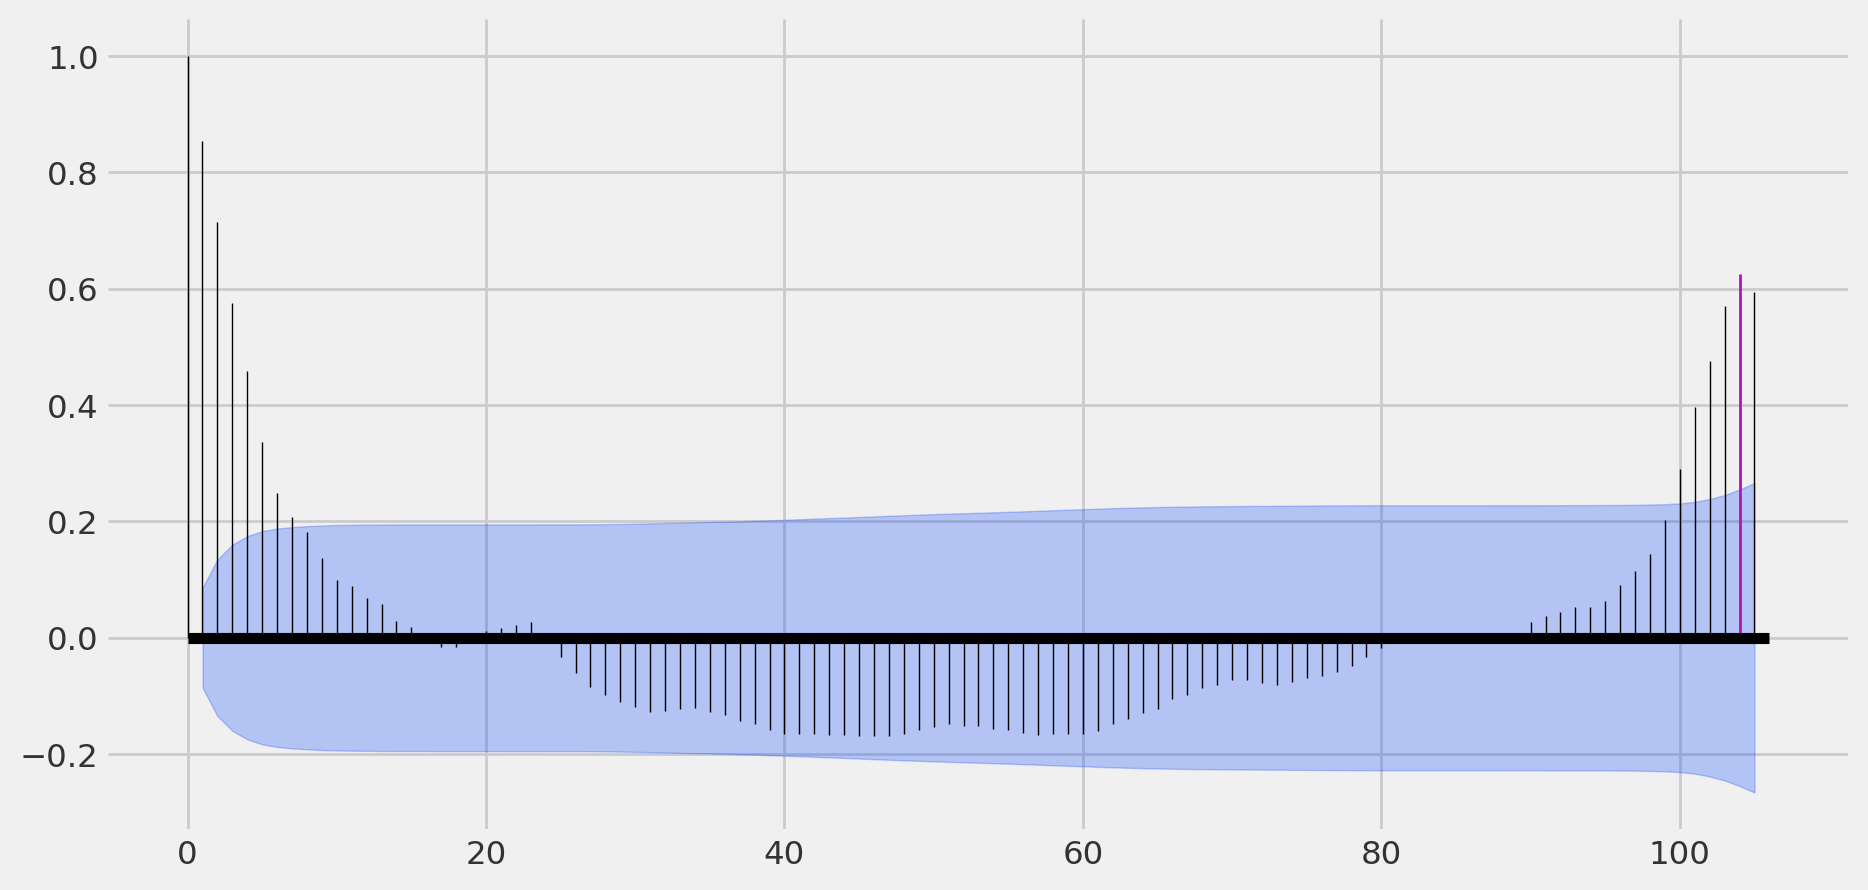

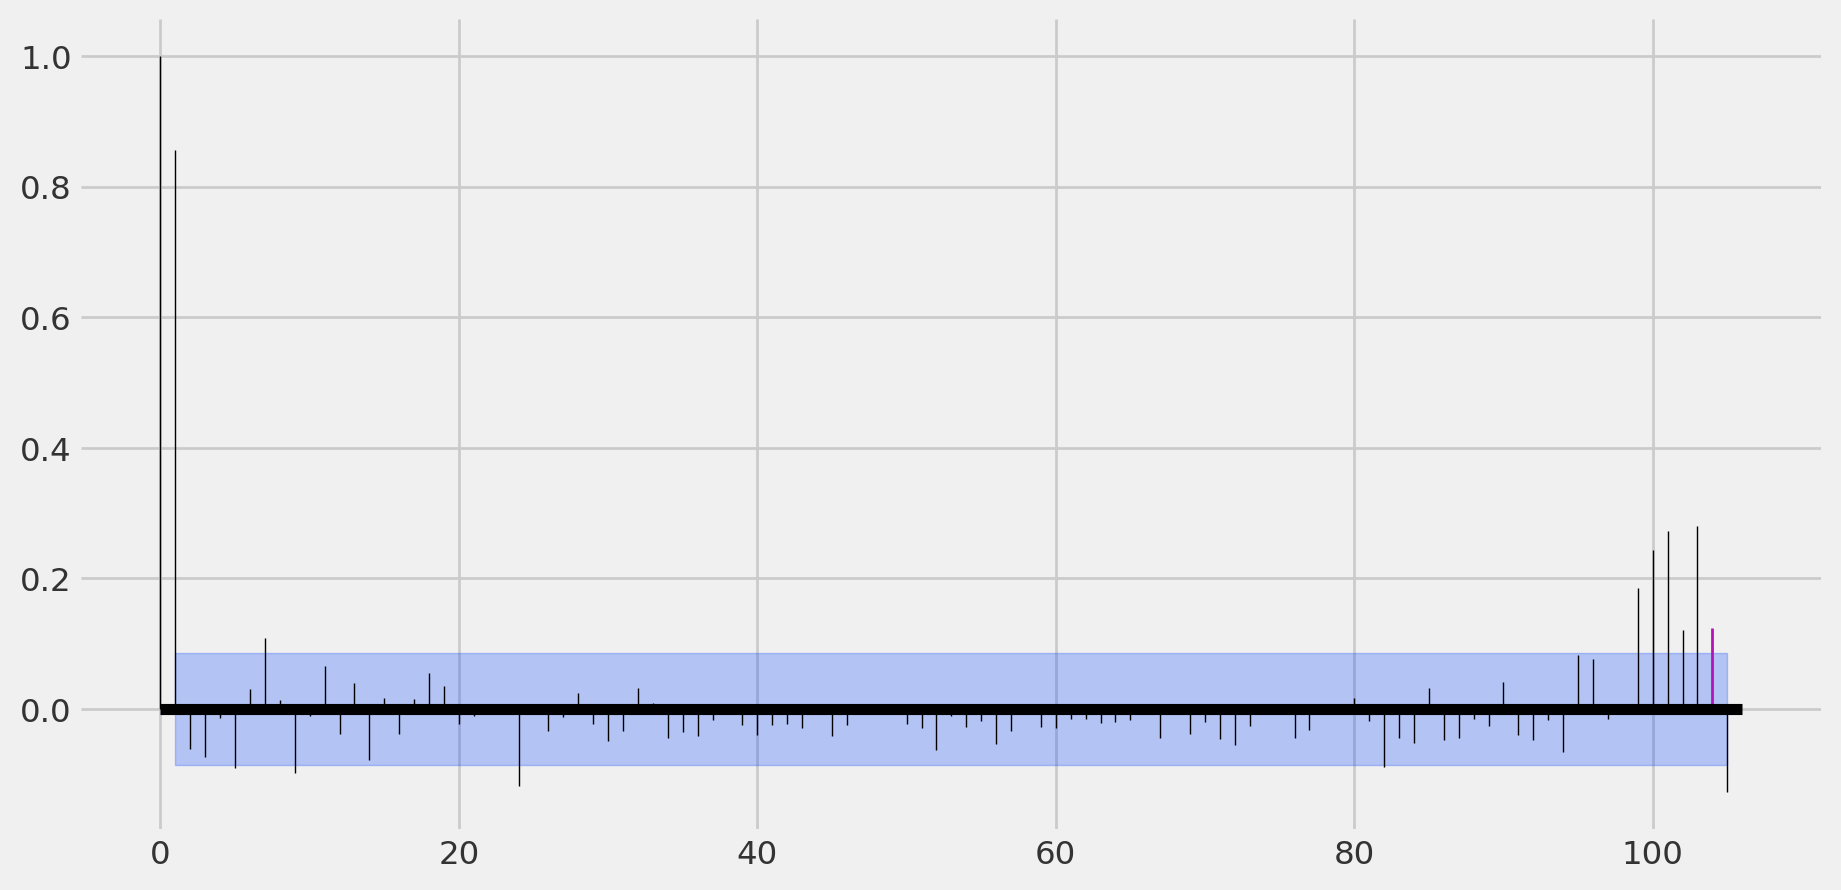

In [60]:
from darts.utils.statistics import plot_acf, check_seasonality, plot_pacf, stationarity_test_kpss

plot_acf(train, m=104, alpha=0.05, max_lag=105)
plot_pacf(train, m=104, alpha=0.05, max_lag=105)

In [61]:
stationarity_test_kpss(train, nlags='auto')

/Users/mreda/opt/anaconda3/envs/pymc-python311/lib/python3.11/site-packages/darts/utils/statistics.py:467: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)


(0.04616345693098766,
 0.1,
 14,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [62]:
for m in range(2, 105):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05, max_lag=106)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

<Axes: xlabel='time'>

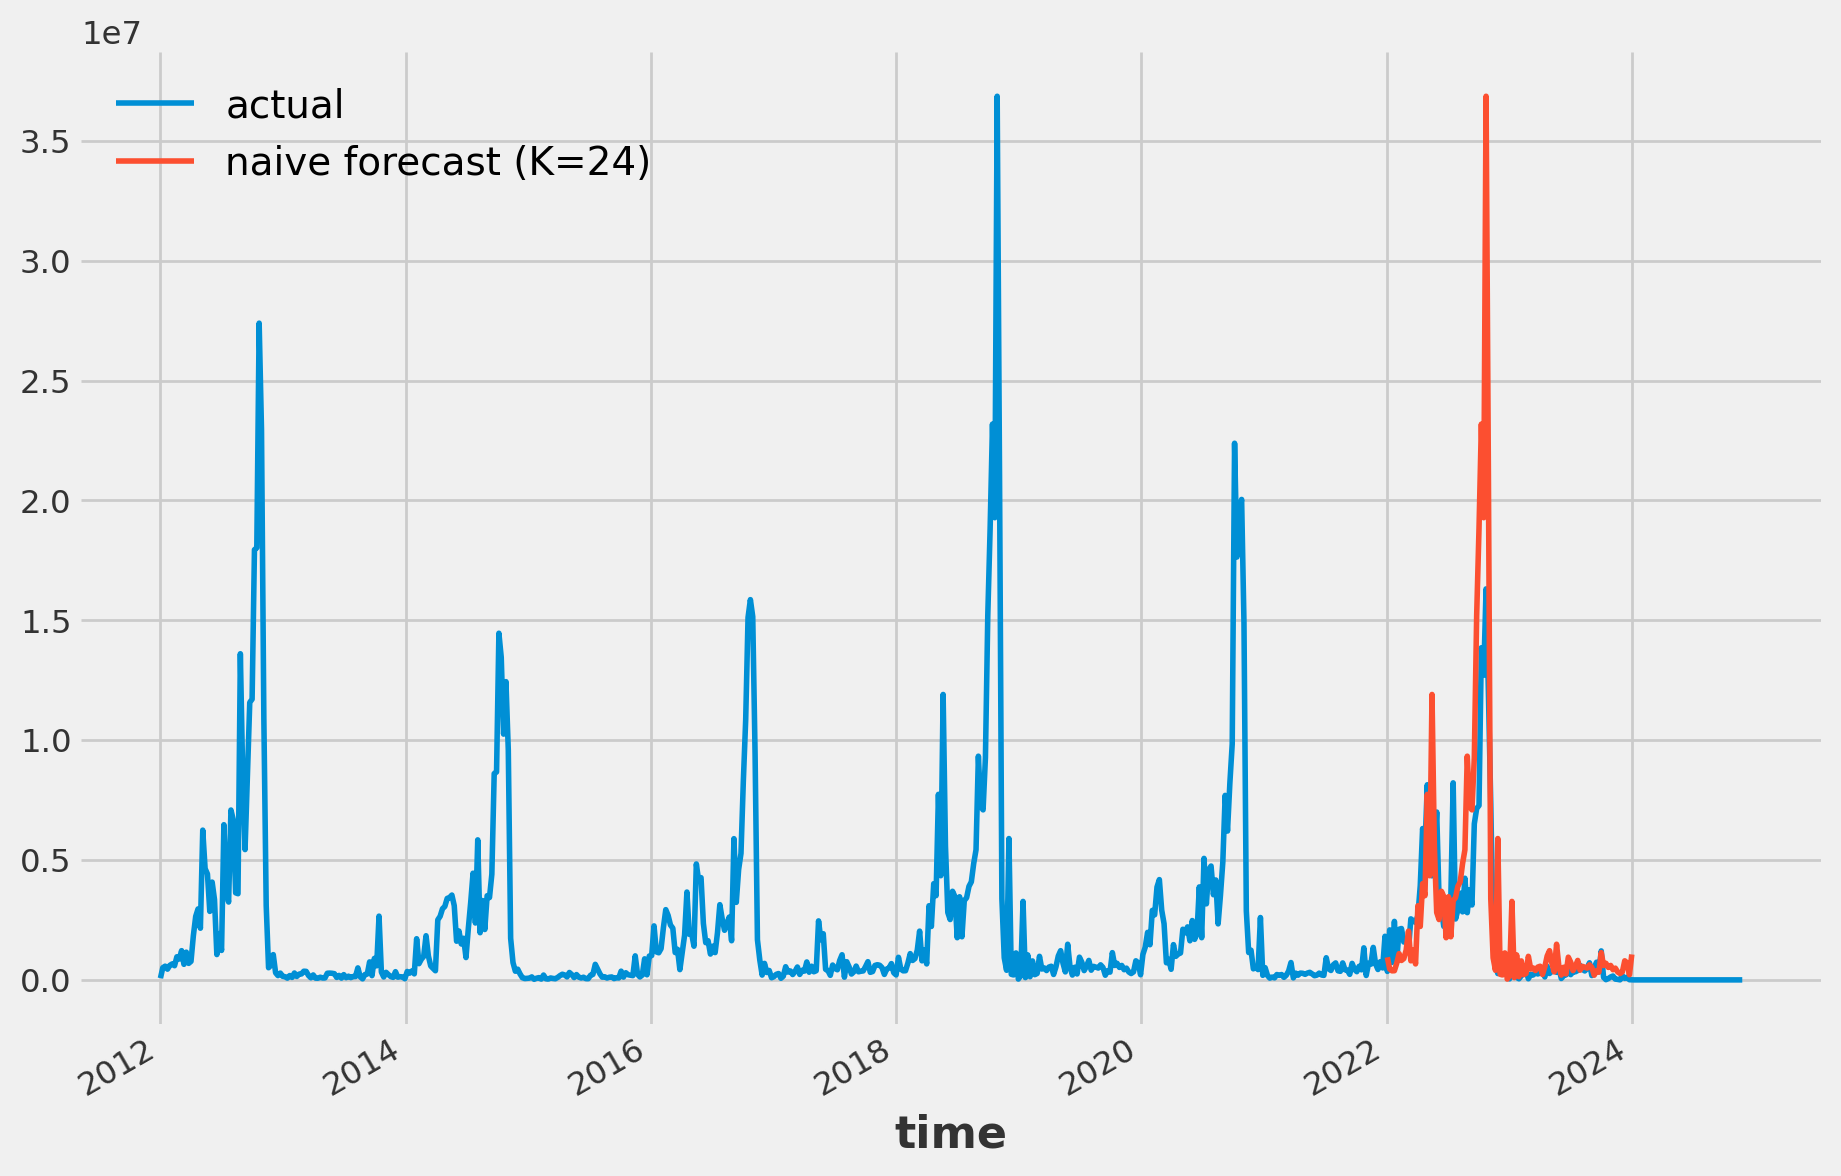

In [63]:
seasonal_model = NaiveSeasonal(K=208)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(105)
my_timeseries.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=24)")

15:29:29 - cmdstanpy - INFO - Chain [1] start processing
15:29:29 - cmdstanpy - INFO - Chain [1] done processing


<Axes: xlabel='time'>

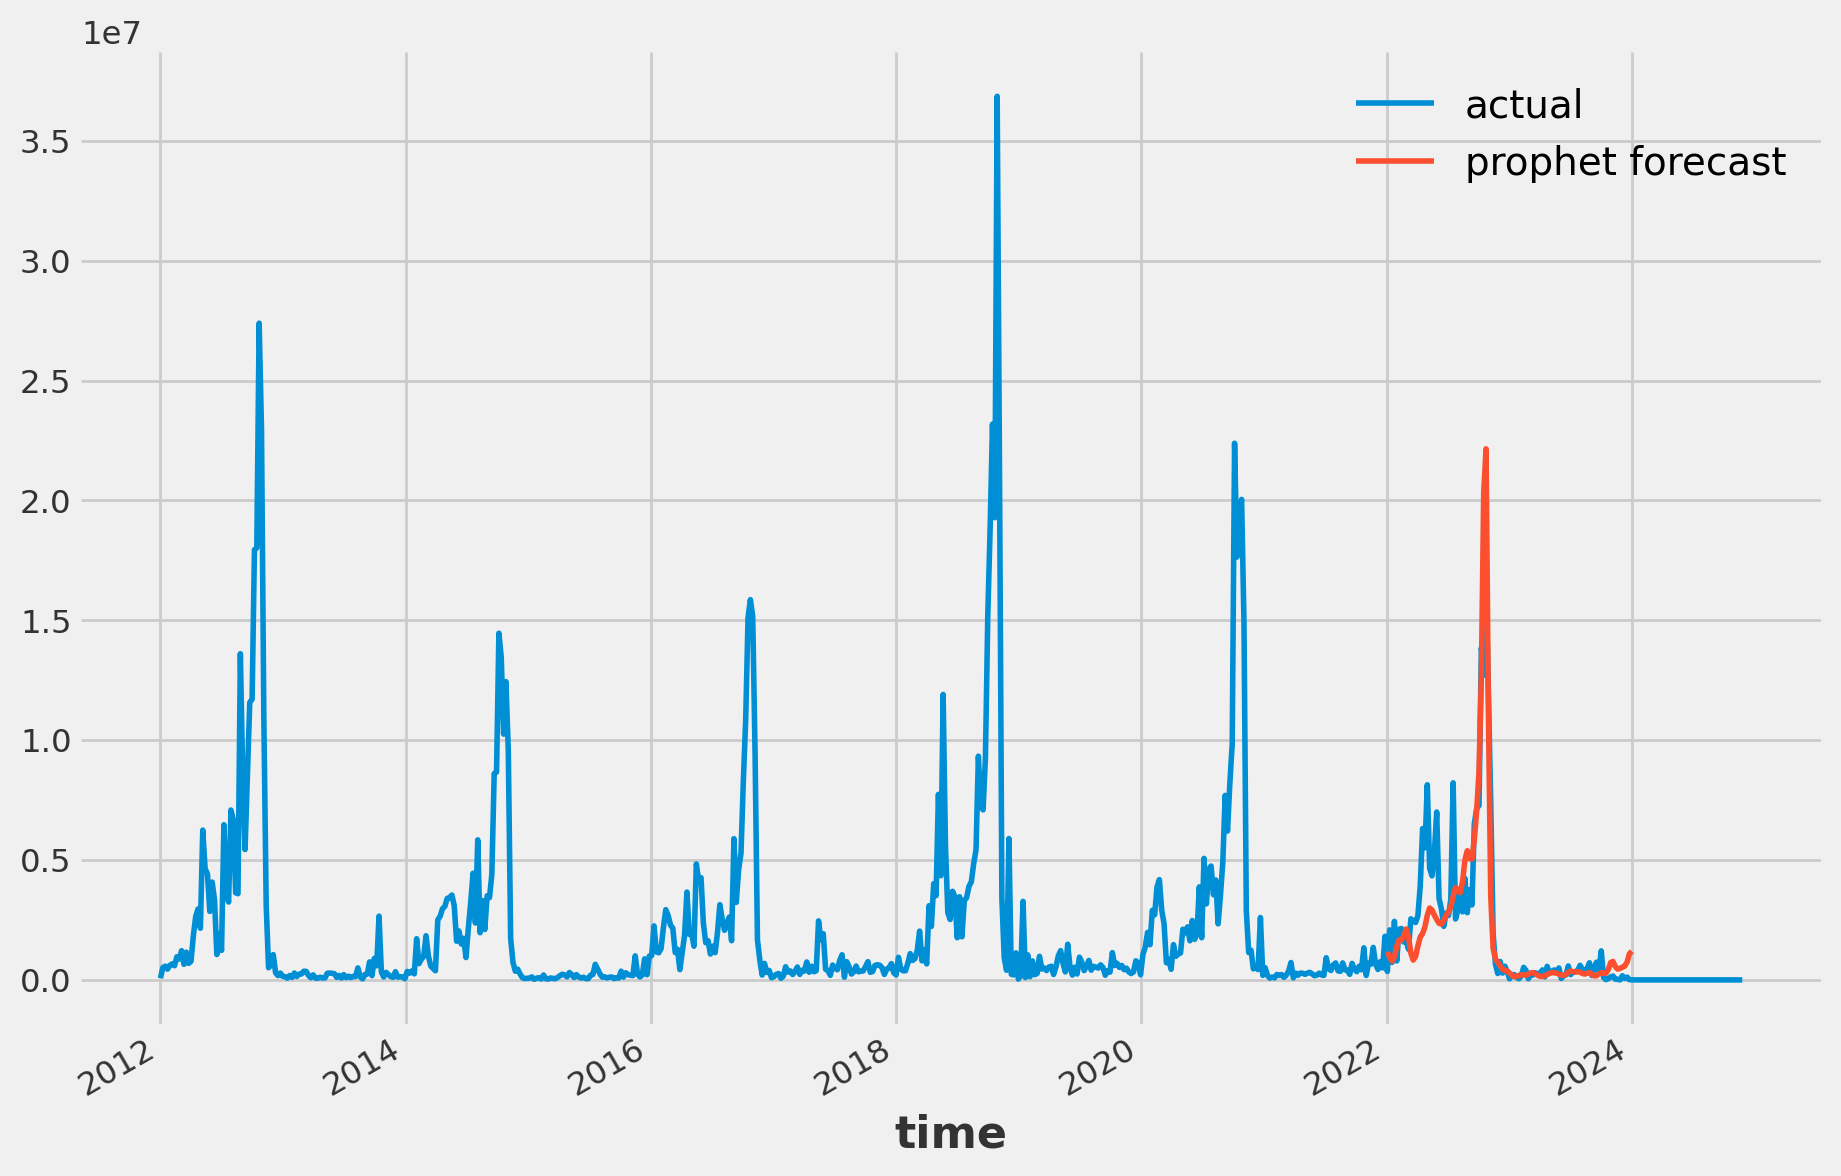

In [64]:
prophet = Prophet(add_seasonalities=[
  {'name': 'Campaign', 'seasonal_periods': 104, 'fourier_order': 25, 'prior_scale': 10.0, 'mode': 'multiplicative'},
  #{'name': 'Election', 'seasonal_periods': 52.145, 'fourier_order': 10, 'prior_scale': 10.0, 'mode': 'multiplicative'}
  ])
prophet.fit(log_train)
prophet_forecast = prophet.predict(105)
my_timeseries.plot(label="actual")
prophet_forecast.map(np.exp).plot(label="prophet forecast")

In [65]:
timeseries["Election_Day"] = timeseries["Election_Day"].astype(int)
timeseries["One_Month_Before_Election"] = timeseries['Election_Day'].shift(-1)

In [66]:
timeseries["Election_Day"].value_counts()

Election_Day
0    645
1     29
Name: count, dtype: int64

In [67]:
#polling_trend = pd.read_csv("politicalExp/multiTimeline (2).csv", header=1, na_values='<1')
#polling_trend.columns = ["Month", "Polling"]
#polling_trend["Month"] = pd.to_datetime(polling_trend["Month"])
#polling_trend.set_index("Month", inplace=True)
#polling_trend = polling_trend.astype(float).resample("W-MON", closed='left', label='right', origin='epoch').mean().shift(-1).dropna()
#polling_trend


In [68]:
period = 24
timeseries['t'] = np.arange(0, len(timeseries))
n_fourior_components = 6

cos_components = [f'cos{f}t' for f in range(1, 1 + n_fourior_components)]
sin_components = [f'sin{f}t' for f in range(1, 1 + n_fourior_components)]
timeseries[cos_components] = np.array([np.cos(2 * np.pi * f * timeseries['t'] / period) for f in range(1, 1 + n_fourior_components)]).T
timeseries[sin_components] = np.array([np.sin(2 * np.pi * f * timeseries['t'] / period) for f in range(1, 1 + n_fourior_components)]).T

timeseries['year'] = timeseries.index.year
timeseries['month'] = timeseries.index.to_timestamp().month_name()
#timeseries = pd.merge(timeseries, polling_trend, how='left', left_index=True, right_index=True)

#timeseries["logPolling"] = np.log(timeseries["Polling"]).fillna(0)

timeseries["24_Month_Dummy"] = timeseries['t']%24
ms_2year = [f"m_{i}" for i in range(1, 24)]
ms_2year_full = [f"m_{i}" for i in range(0, 24)]
timeseries[ms_2year_full] = pd.get_dummies(timeseries["24_Month_Dummy"]).astype(int)

dummies = pd.get_dummies(timeseries['year'], drop_first = True)
year_dummies = dummies.columns.to_list()
dummies = dummies.join(pd.get_dummies(timeseries.month, drop_first = True)).astype(int)
month_dummies = dummies.columns.to_list()
timeseries = timeseries.join(dummies)



In [69]:
dummies.index

PeriodIndex(['2011-12-27/2012-01-02', '2012-01-03/2012-01-09',
             '2012-01-10/2012-01-16', '2012-01-17/2012-01-23',
             '2012-01-24/2012-01-30', '2012-01-31/2012-02-06',
             '2012-02-07/2012-02-13', '2012-02-14/2012-02-20',
             '2012-02-21/2012-02-27', '2012-02-28/2012-03-05',
             ...
             '2024-09-17/2024-09-23', '2024-09-24/2024-09-30',
             '2024-10-01/2024-10-07', '2024-10-08/2024-10-14',
             '2024-10-15/2024-10-21', '2024-10-22/2024-10-28',
             '2024-10-29/2024-11-04', '2024-11-05/2024-11-11',
             '2024-11-12/2024-11-18', '2024-11-19/2024-11-25'],
            dtype='period[W-MON]', name='time', length=674)

In [70]:
np.log1p(timeseries['TRANSACTION_AMT']).min()

0.0

/Users/mreda/opt/anaconda3/envs/pymc-python311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


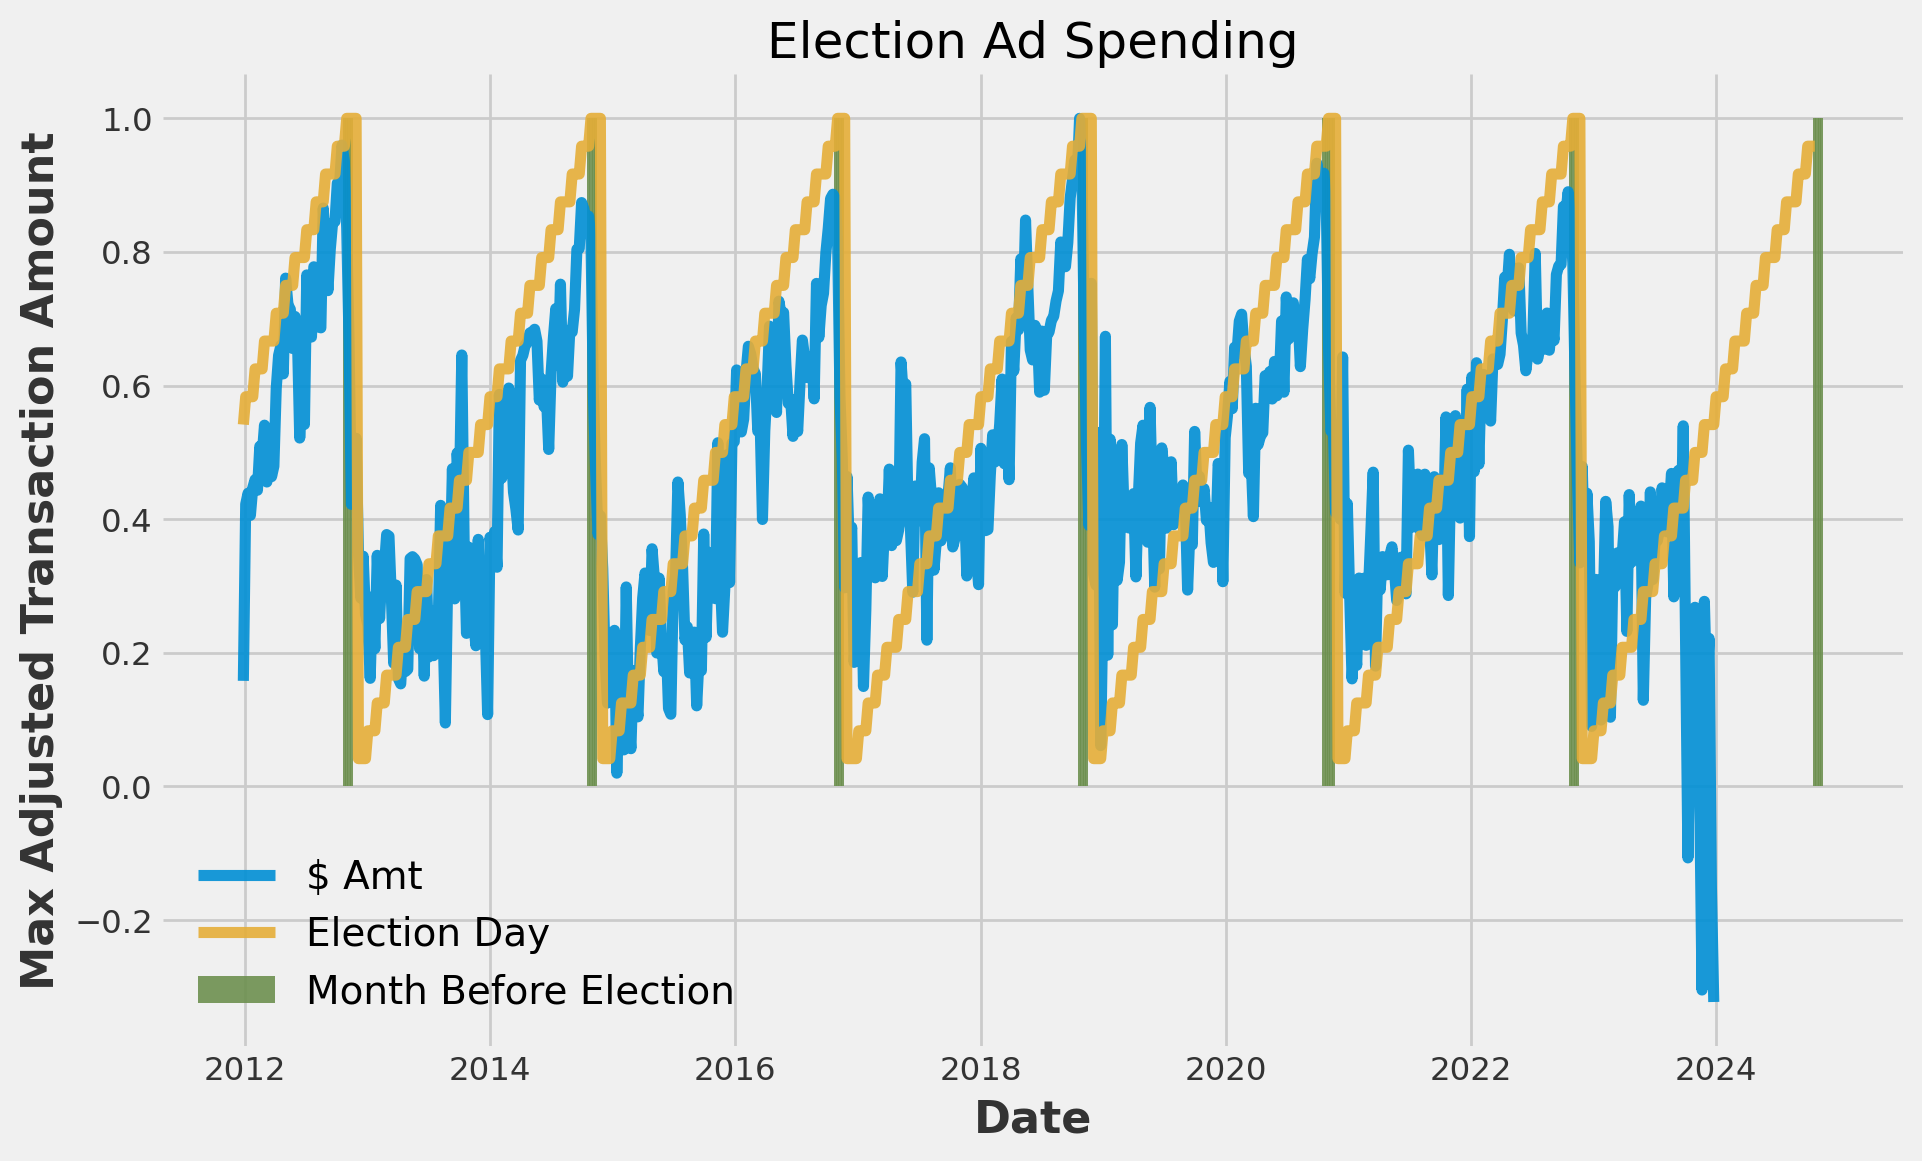

In [71]:
date = [t.to_timestamp() for t in timeseries.index]
plt.plot(date, (np.log(timeseries['TRANSACTION_AMT'])-10)/(np.log(timeseries['TRANSACTION_AMT']).max()-10), color='C0',label='$ Amt', alpha=.9) 
plt.bar(date, timeseries["Election_Day"].shift(-1), width=10, color='C3', label='Month Before Election', alpha=.9)
plt.plot(date, 1-timeseries["Months Before Election"].shift(-4)/24, color='C2', label='Election Day', alpha=.9)
plt.xlabel("Date")
plt.ylabel("Max Adjusted Transaction Amount")
plt.title("Election Ad Spending")
plt.legend();

In [72]:
holdout = timeseries.loc["2021-01-01":].copy()
timeseries_train = timeseries.loc[:"2021-01-01"].copy()

In [73]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sktime.forecasting.compose import TransformedTargetForecaster, ForecastX, ForecastingPipeline
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.impute import Imputer
from sktime.forecasting.compose import make_reduction
from sktime.transformations.series.func_transform import FunctionTransformer
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import YfromX
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.split import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sktime.registry import all_estimators, all_tags

In [74]:
all_estimators('forecaster', as_dataframe=True)

name                                             object
0                ARCH      <class 'sktime.forecasting.arch._uarch.ARCH'>
1                ARDL             <class 'sktime.forecasting.ardl.ARDL'>
2               ARIMA           <class 'sktime.forecasting.arima.ARIMA'>
3           AutoARIMA       <class 'sktime.forecasting.arima.AutoARIMA'>
4             AutoETS           <class 'sktime.forecasting.ets.AutoETS'>
..                ...                                                ...
69  UpdateRefitsEvery  <class 'sktime.forecasting.stream._update.Upda...
70                VAR               <class 'sktime.forecasting.var.VAR'>
71             VARMAX         <class 'sktime.forecasting.varmax.VARMAX'>
72               VECM             <class 'sktime.forecasting.vecm.VECM'>
73             YfromX  <class 'sktime.forecasting.compose._reduce.Yfr...

[74 rows x 2 columns]

/Users/mreda/opt/anaconda3/envs/pymc-python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mreda/opt/anaconda3/envs/pymc-python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mreda/opt/anaconda3/envs/pymc-python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mreda/opt/anaconda3/envs/pymc-python311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

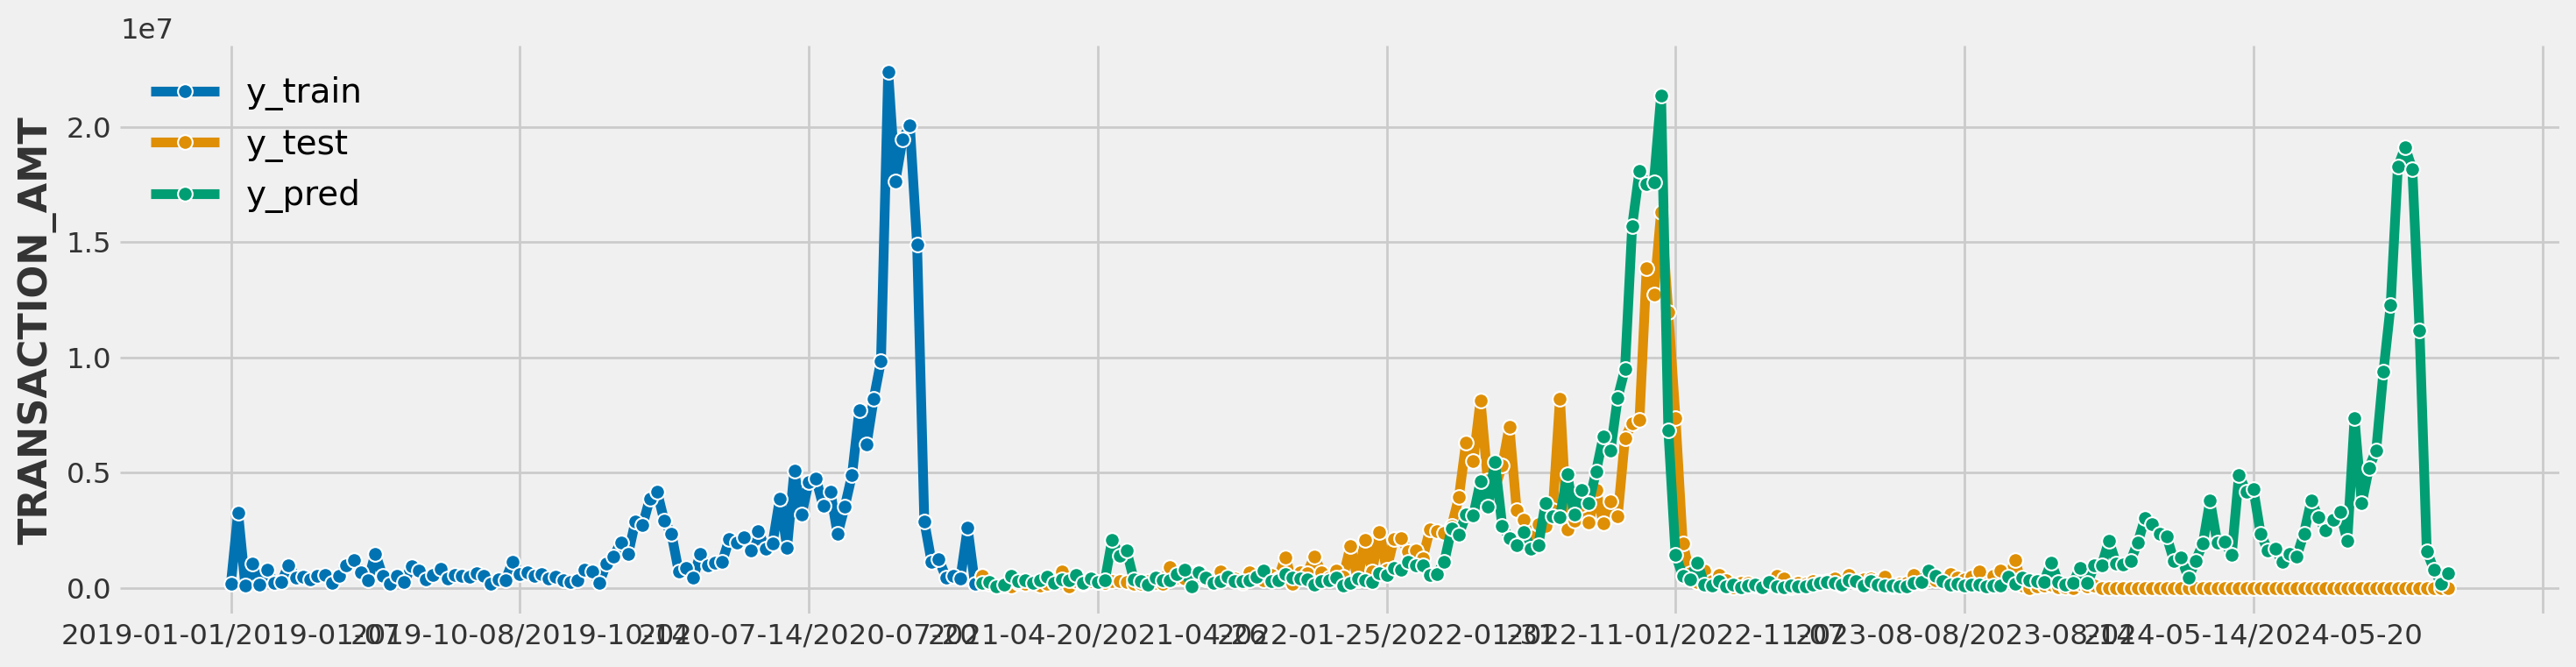

In [76]:
forecaster = TransformedTargetForecaster(
    [
        ('log', FunctionTransformer(func=np.log1p, inverse_func=np.expm1)),
        ("deseasonalize election year", Deseasonalizer(model="additive", sp=104)),
        ("deseasonalize presidential year", Deseasonalizer(model="additive", sp=208)),
        (
            "forecast",
            
            YfromX(RandomForestRegressor(max_depth=10, criterion='absolute_error', n_estimators=100, random_state=0)),
            
        ),
    ]
)

complete_pipeline = ForecastingPipeline([
    (
        "imputer",
        Imputer(method="mean")
    ),
    
    (
        "forecast",
        forecaster
    ),
])
naive_forecast = NaiveForecaster(strategy="last")

pipe = ForecastX(
    forecaster_y=forecaster,
    forecaster_X=naive_forecast,
    behaviour="refit"
)

fh = ForecastingHorizon([i for i in range(204)])
complete_pipeline.fit(timeseries_train[['TRANSACTION_AMT']], timeseries_train[['Months Before Election']])
y_pred = complete_pipeline.predict(fh=fh, X=holdout[['Months Before Election']])
plot_series(timeseries_train['TRANSACTION_AMT'].loc['2019':], holdout['TRANSACTION_AMT'], y_pred, labels=["y_train", "y_test", "y_pred"]);
#mean_absolute_percentage_error(holdout['TRANSACTION_AMT'], y_pred, symmetric=True)

In [78]:
holdout['TRANSACTION_AMT']

2020-12-29/2021-01-04    509792.74
2021-01-05/2021-01-11    183634.28
2021-01-12/2021-01-18     72790.74
2021-01-19/2021-01-25    116670.64
2021-01-26/2021-02-01     84604.43
                           ...    
2024-10-22/2024-10-28         0.00
2024-10-29/2024-11-04         0.00
2024-11-05/2024-11-11         0.00
2024-11-12/2024-11-18         0.00
2024-11-19/2024-11-25         0.00
Freq: W-MON, Name: TRANSACTION_AMT, Length: 204, dtype: float64

In [79]:
holdout['TRANSACTION_AMT'].iloc[:157]

2020-12-29/2021-01-04    509792.74
2021-01-05/2021-01-11    183634.28
2021-01-12/2021-01-18     72790.74
2021-01-19/2021-01-25    116670.64
2021-01-26/2021-02-01     84604.43
                           ...    
2023-11-28/2023-12-04    172257.44
2023-12-05/2023-12-11     63706.74
2023-12-12/2023-12-18    114168.54
2023-12-19/2023-12-25      7163.62
2023-12-26/2024-01-01      2010.07
Freq: W-MON, Name: TRANSACTION_AMT, Length: 157, dtype: float64

In [80]:
mean_absolute_percentage_error(holdout['TRANSACTION_AMT'].iloc[:155], y_pred.iloc[1:156])

3.667535905007592

In [100]:
# declarative forecaster specification - just two lines!
regressor = RandomForestRegressor(n_estimators=100)
forecaster = make_reduction(regressor, window_length=105, strategy="recursive")
forecaster.fit(timeseries_train["TRANSACTION_AMT"])
y_pred = forecaster.predict(holdout["TRANSACTION_AMT"].index[1:])


<Axes: >

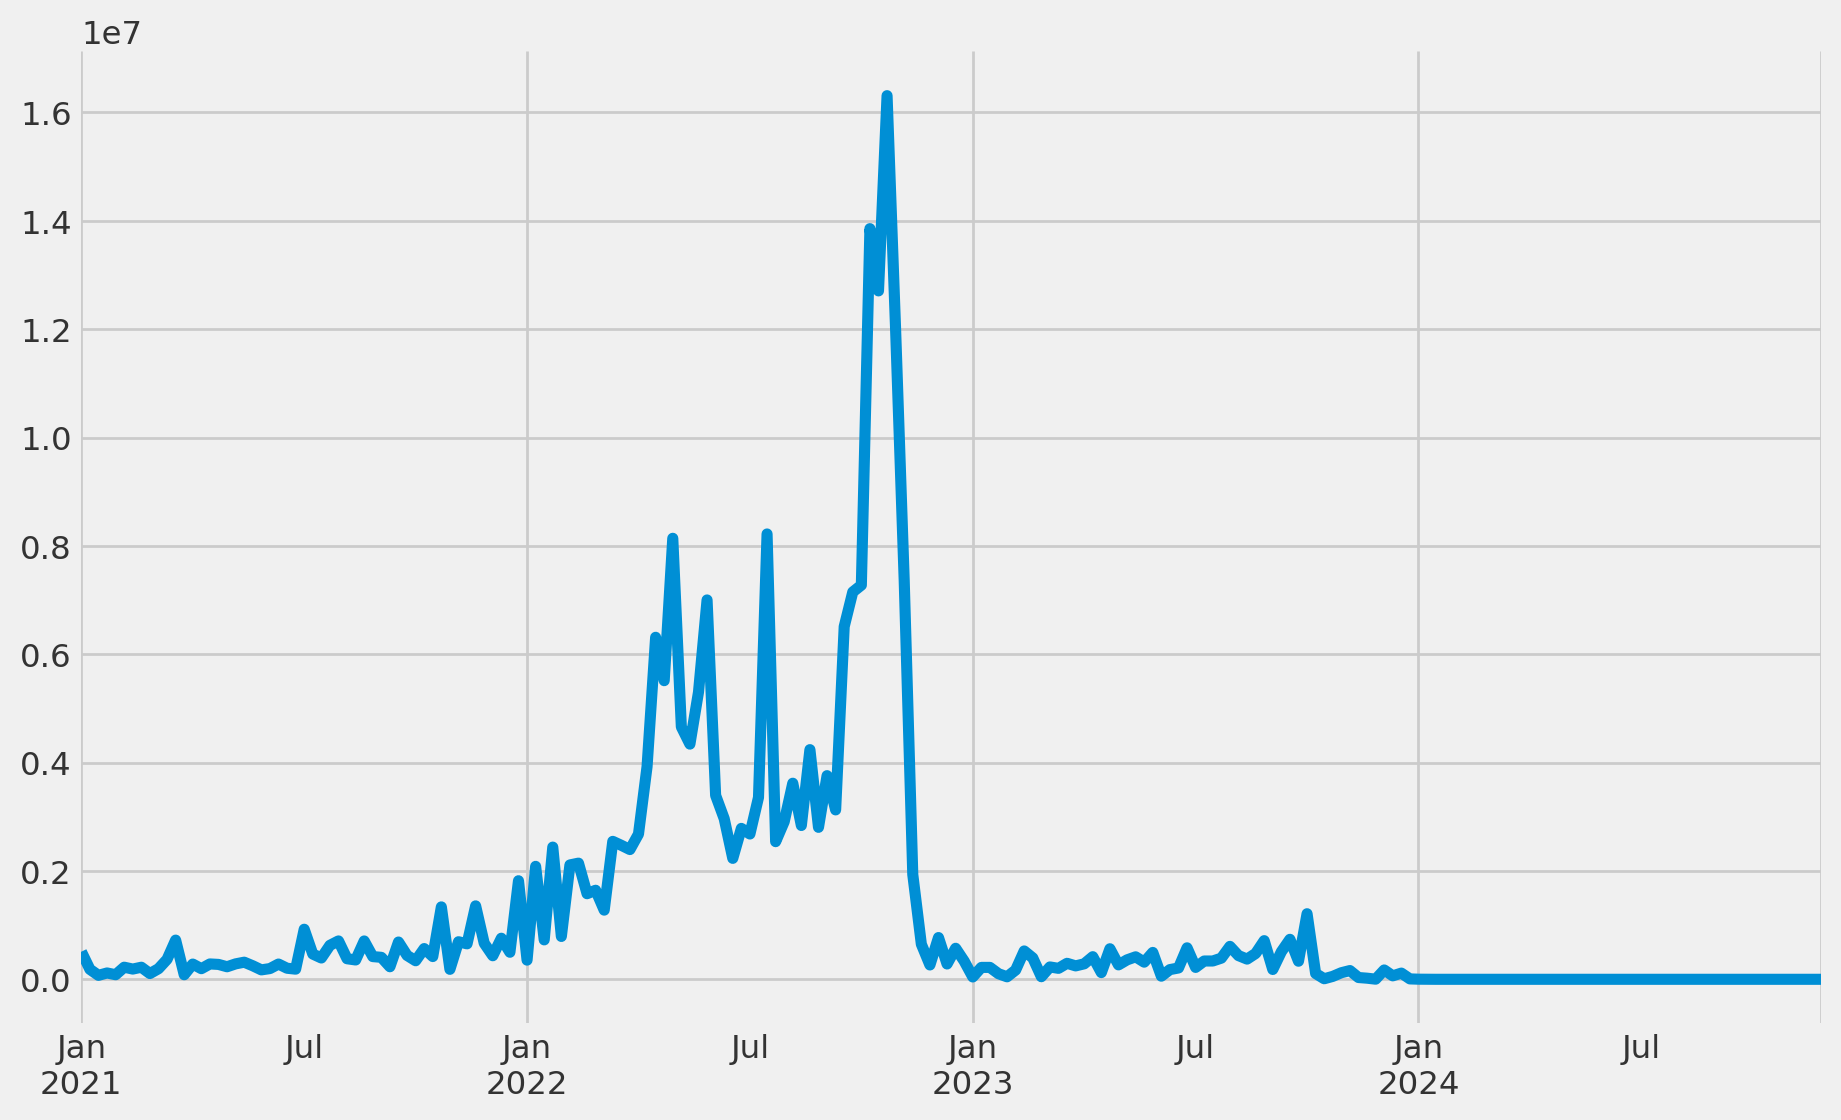

In [101]:
holdout['TRANSACTION_AMT'].plot()

In [102]:
y_pred

2021-01-05/2021-01-11    1.113401e+06
2021-01-12/2021-01-18    6.833398e+05
2021-01-19/2021-01-25    8.416282e+05
2021-01-26/2021-02-01    5.252068e+05
2021-02-02/2021-02-08    5.806954e+05
                             ...     
2024-10-22/2024-10-28    2.141512e+07
2024-10-29/2024-11-04    1.585327e+07
2024-11-05/2024-11-11    1.017053e+07
2024-11-12/2024-11-18    8.485164e+06
2024-11-19/2024-11-25    5.790825e+06
Freq: W-MON, Name: TRANSACTION_AMT, Length: 203, dtype: float64

In [103]:
y_pred.index.to_timestamp()

DatetimeIndex(['2021-01-05', '2021-01-12', '2021-01-19', '2021-01-26',
               '2021-02-02', '2021-02-09', '2021-02-16', '2021-02-23',
               '2021-03-02', '2021-03-09',
               ...
               '2024-09-17', '2024-09-24', '2024-10-01', '2024-10-08',
               '2024-10-15', '2024-10-22', '2024-10-29', '2024-11-05',
               '2024-11-12', '2024-11-19'],
              dtype='datetime64[ns]', length=203, freq='W-TUE')

In [104]:
import statsmodels.tsa.api as smt

In [105]:
smt.adfuller(np.log(timeseries_train['TRANSACTION_AMT']))

(-3.6896023151199167,
 0.0042618068198890975,
 2,
 468,
 {'1%': -3.4444002781824477,
  '5%': -2.867735576537528,
  '10%': -2.57007000456571},
 1024.6478384139496)

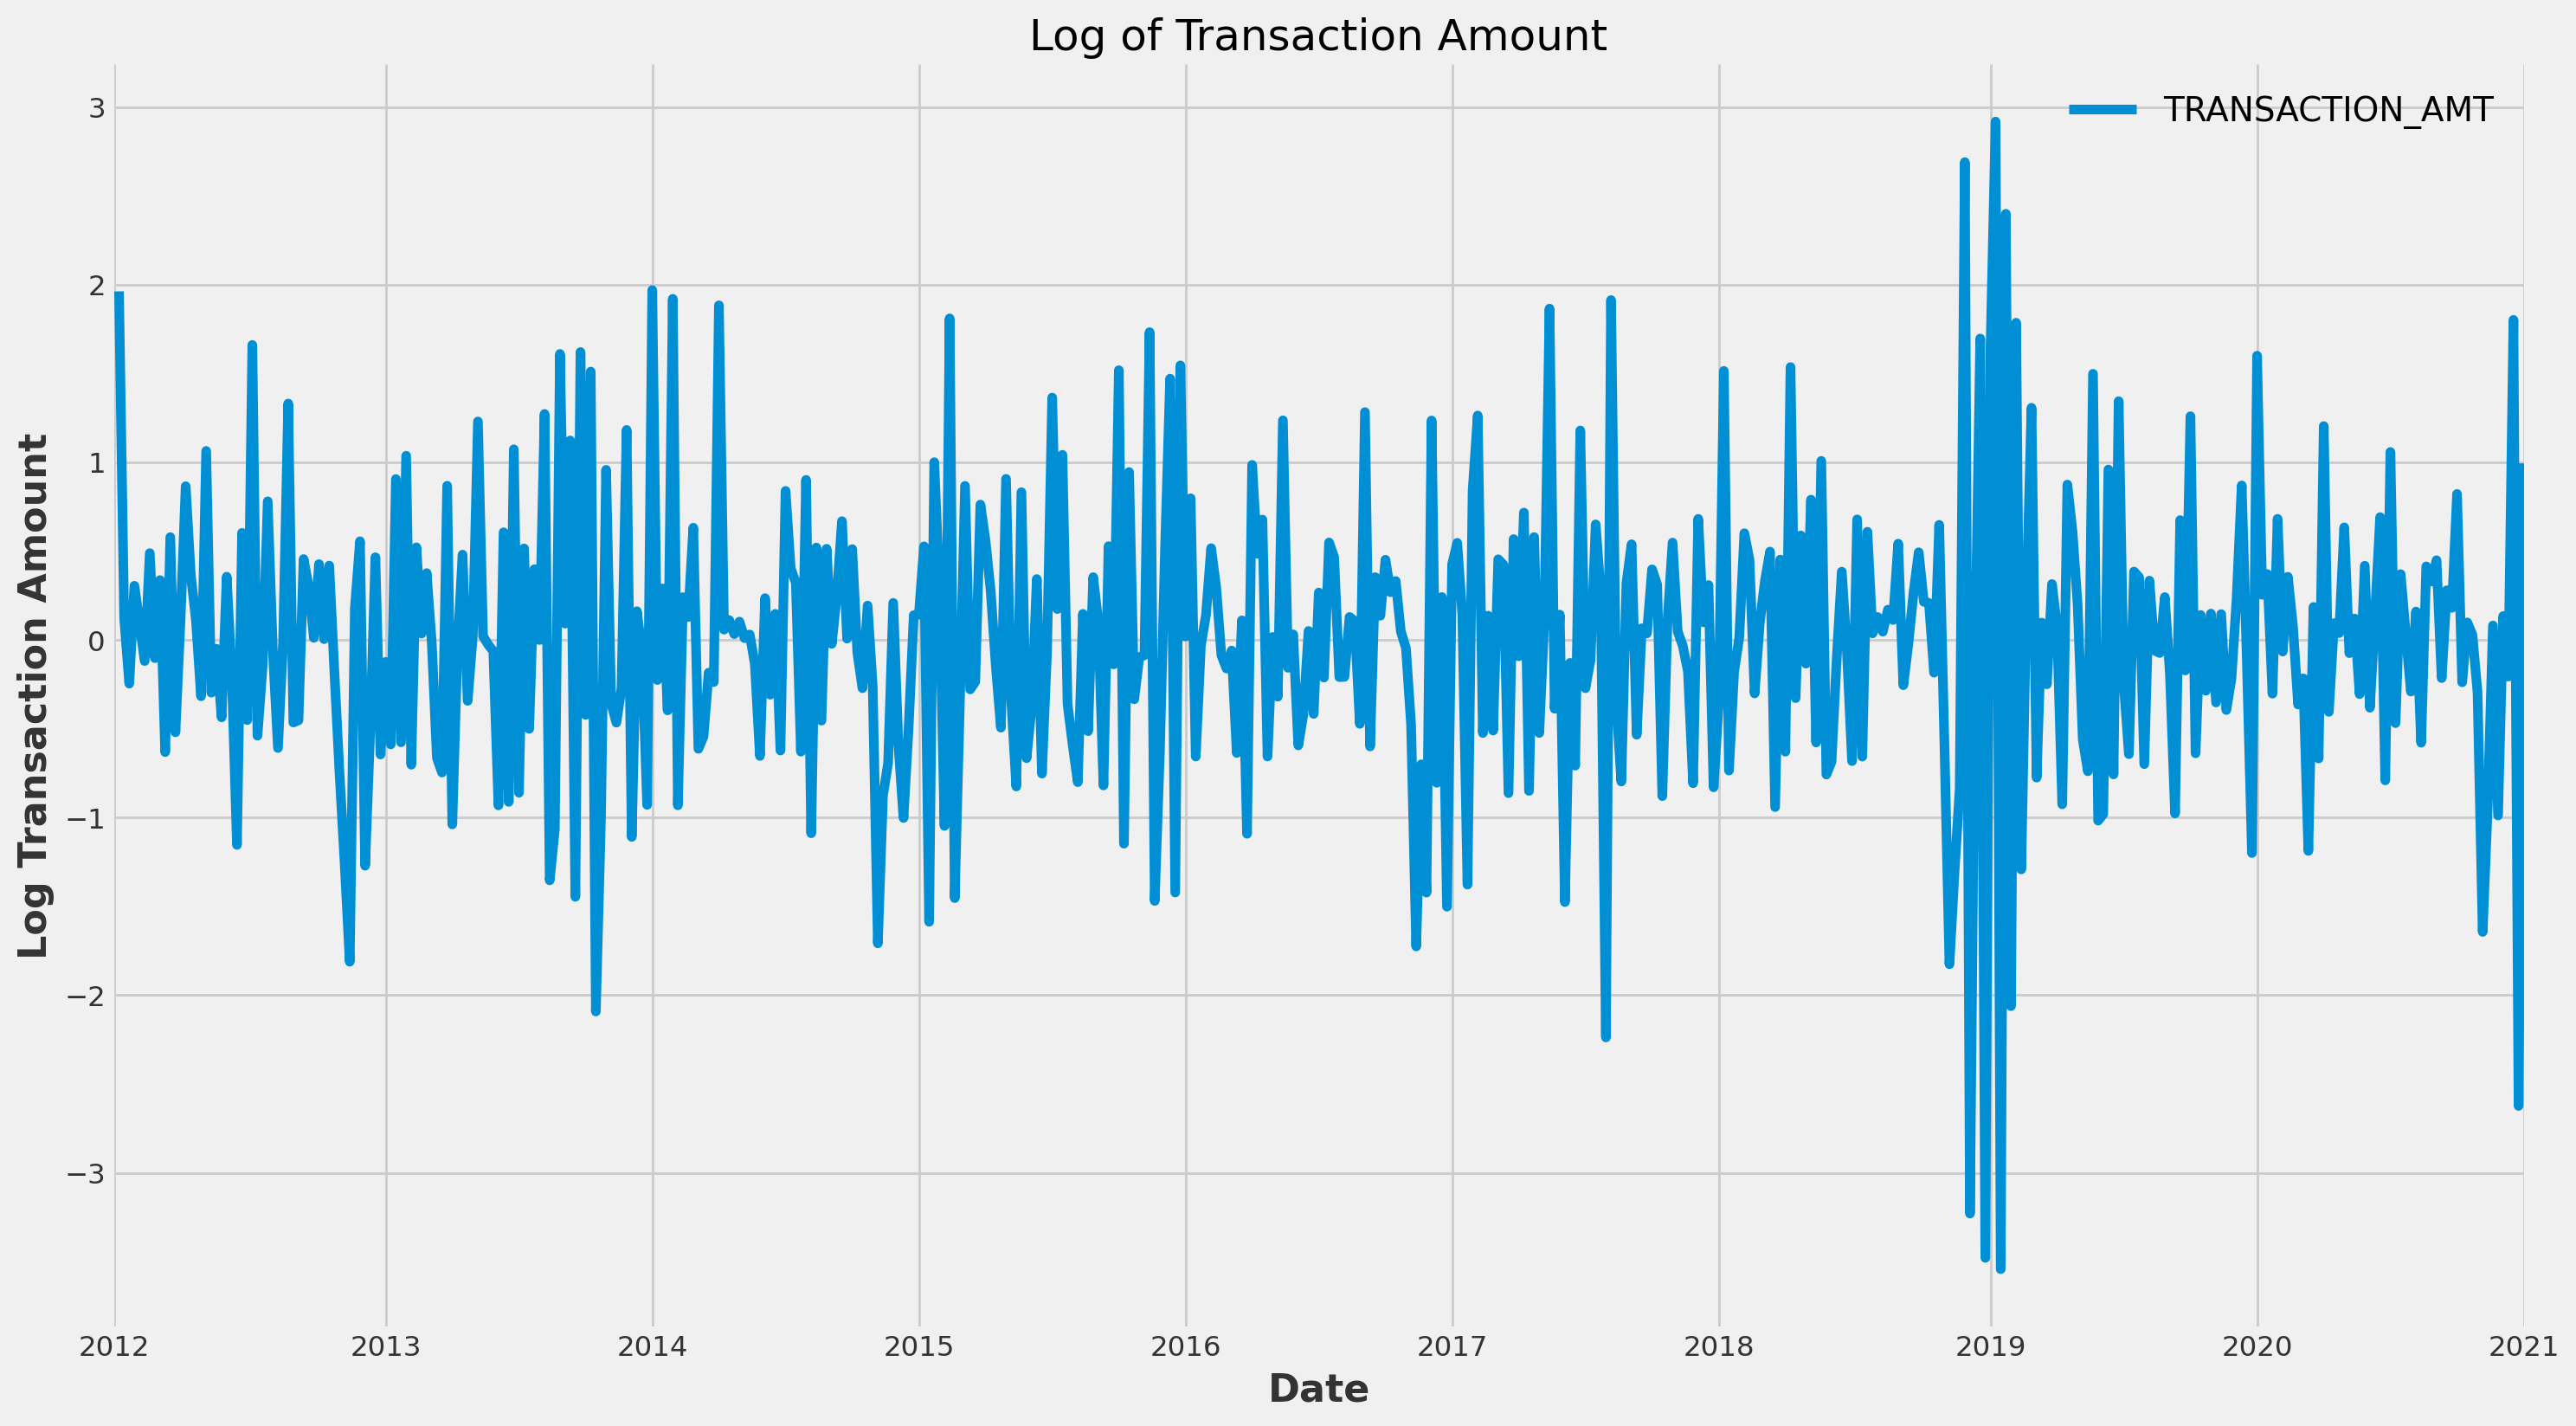

In [106]:
np.log(timeseries_train['TRANSACTION_AMT']).diff(1).plot(figsize=(16, 9))
plt.xlabel("Date")
plt.ylabel("Log Transaction Amount")
plt.title("Log of Transaction Amount")
plt.legend();

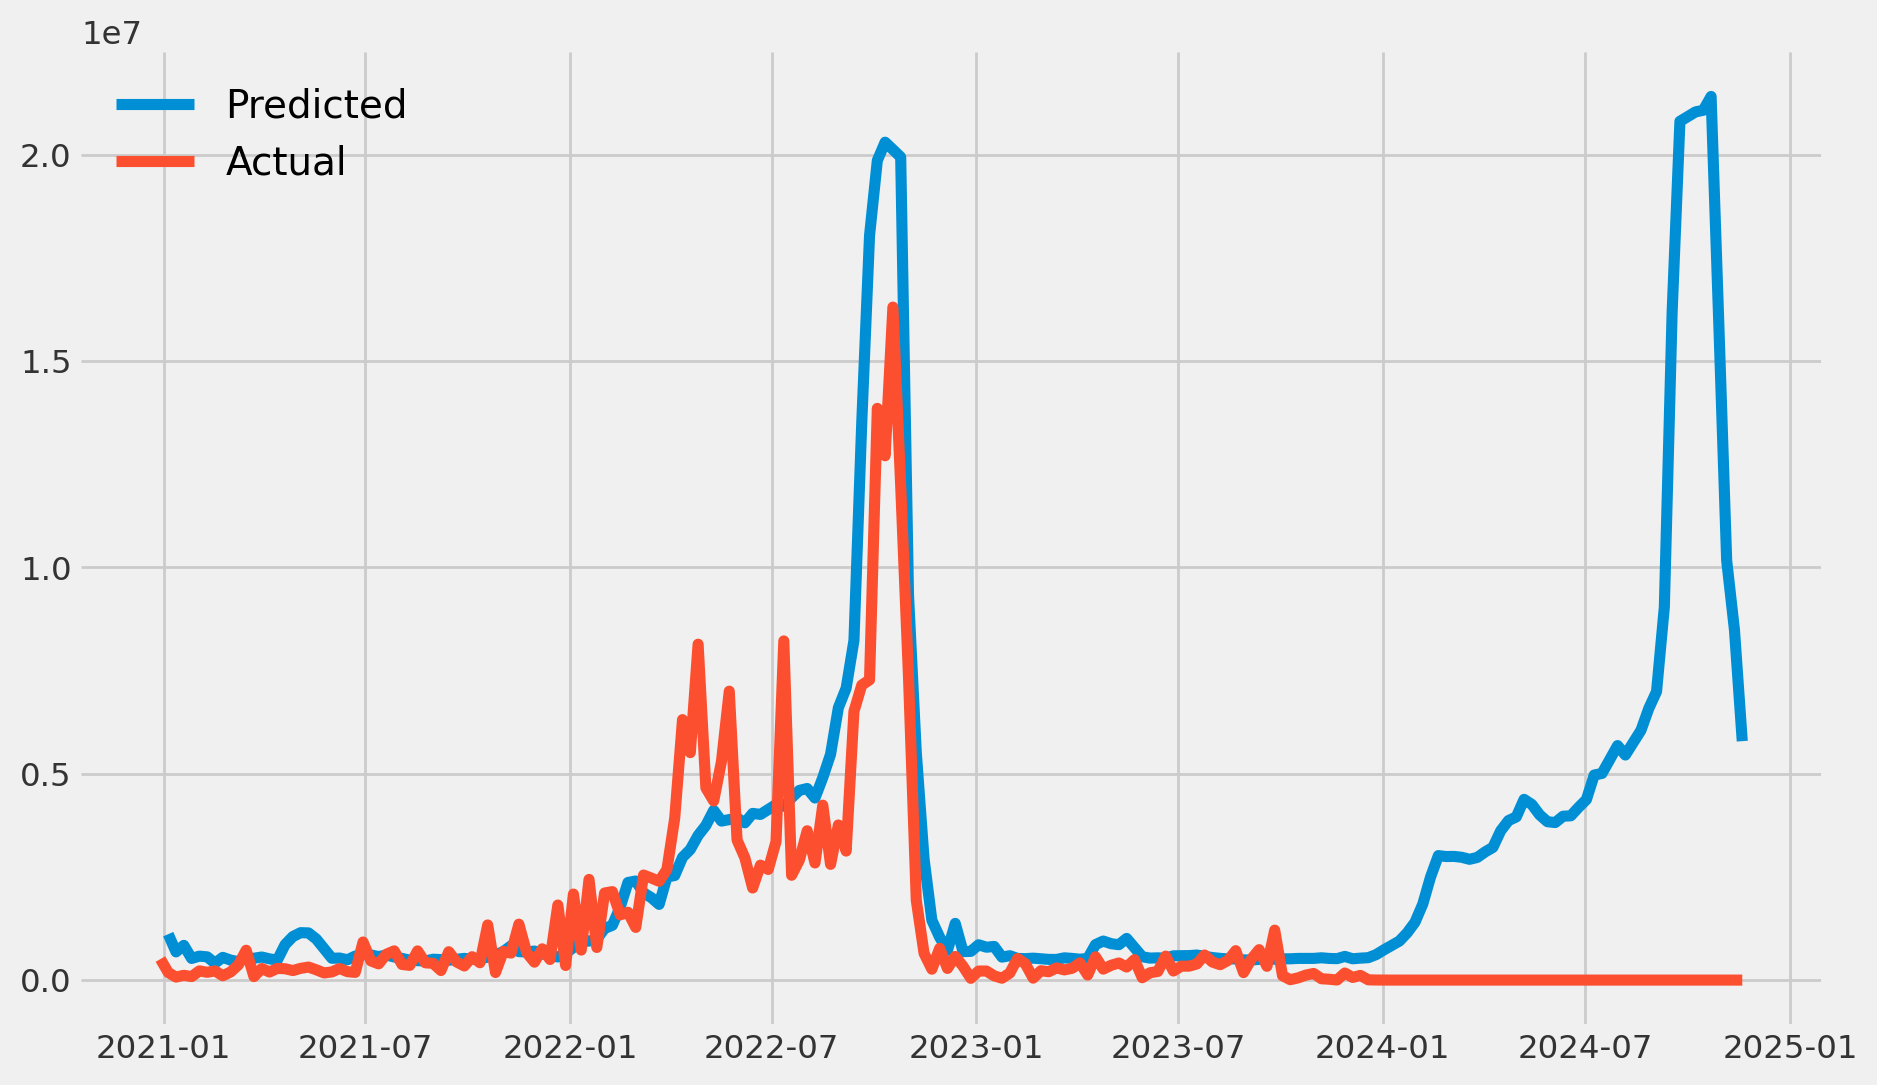

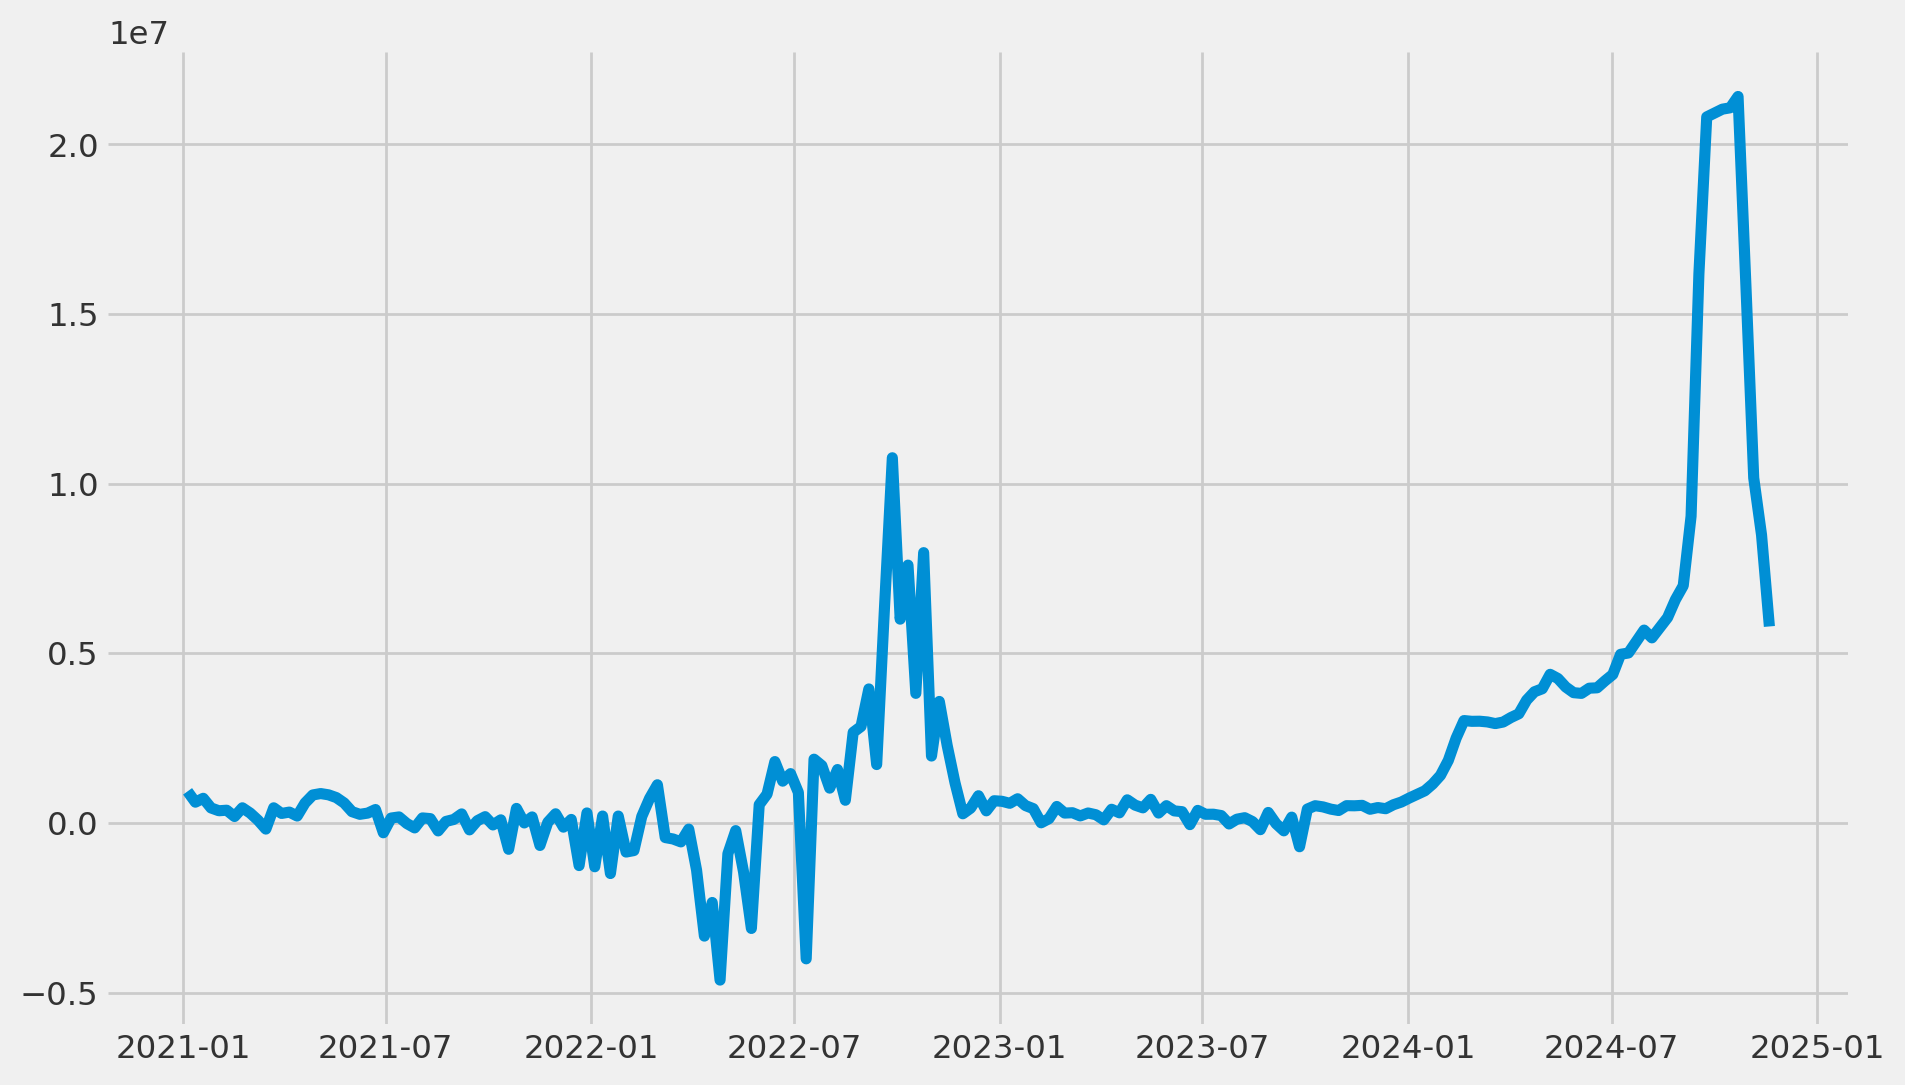

In [107]:
plt.plot(y_pred.index.to_timestamp(), y_pred.values, label='Predicted')
plt.plot(holdout.index.to_timestamp(), holdout["TRANSACTION_AMT"].values, label='Actual')
plt.legend()
plt.show()
plt.plot(y_pred.index.to_timestamp(), y_pred-holdout['TRANSACTION_AMT'].iloc[1:], label='Predicted')

In [108]:
import statsmodels.tsa.api as smt

In [111]:
timeseries[timeseries['TRANSACTION_AMT']<=0]

TRANSACTION_AMT  Election_Day  Months Before Election  \
time                                                                           
2024-01-02/2024-01-08              0.0             0                      11   
2024-01-09/2024-01-15              0.0             0                      11   
2024-01-16/2024-01-22              0.0             0                      11   
2024-01-23/2024-01-29              0.0             0                      11   
2024-01-30/2024-02-05              0.0             0                      10   
2024-02-06/2024-02-12              0.0             0                      10   
2024-02-13/2024-02-19              0.0             0                      10   
2024-02-20/2024-02-26              0.0             0                      10   
2024-02-27/2024-03-04              0.0             0                       9   
2024-03-05/2024-03-11              0.0             0                       9   
2024-03-12/2024-03-18              0.0             0                       9   
2024-03-19/2024-03-25              0.0             0                       9   
2024-03-26/2024-04-01              0.0             0                       8   
2024-04-02/2024-04-08              0.0             0                       8   
2024-04-09/2024-04-15              0.0             0                       8   
2024-04-16/2024-04-22              0.0             0                       8   
2024-04-23/2024-04-29              0.0             0                       8   
2024-04-30/2024-05-06              0.0             0                       7   
2024-05-07/2024-05-13              0.0             0                       7   
2024-05-14/2024-05-20              0.0             0                       7   
2024-05-21/2024-05-27              0.0             0                       7   
2024-05-28/2024-06-03              0.0             0                       6   
2024-06-04/2024-06-10              0.0             0                       6   
2024-06-11/2024-06-17              0.0             0                       6   
2024-06-18/2024-06-24              0.0             0                       6   
2024-06-25/2024-07-01              0.0             0                       5   
2024-07-02/2024-07-08              0.0             0                       5   
2024-07-09/2024-07-15              0.0             0                       5   
2024-07-16/2024-07-22              0.0             0                       5   
2024-07-23/2024-07-29              0.0             0                       5   
2024-07-30/2024-08-05              0.0             0                       4   
2024-08-06/2024-08-12              0.0             0                       4   
2024-08-13/2024-08-19              0.0             0                       4   
2024-08-20/2024-08-26              0.0             0                       4   
2024-08-27/2024-09-02              0.0             0                       3   
2024-09-03/2024-09-09              0.0             0                       3   
2024-09-10/2024-09-16              0.0             0                       3   
2024-09-17/2024-09-23              0.0             0                       3   
2024-09-24/2024-09-30              0.0             0                       3   
2024-10-01/2024-10-07              0.0             0                       2   
2024-10-08/2024-10-14              0.0             0                       2   
2024-10-15/2024-10-21              0.0             0                       2   
2024-10-22/2024-10-28              0.0             0                       2   
2024-10-29/2024-11-04              0.0             1                       1   
2024-11-05/2024-11-11              0.0             1                       1   
2024-11-12/2024-11-18              0.0             1                       1   
2024-11-19/2024-11-25              0.0             1                       1   

                       One_Month_Before_Election    t         cos1t  \
time                           

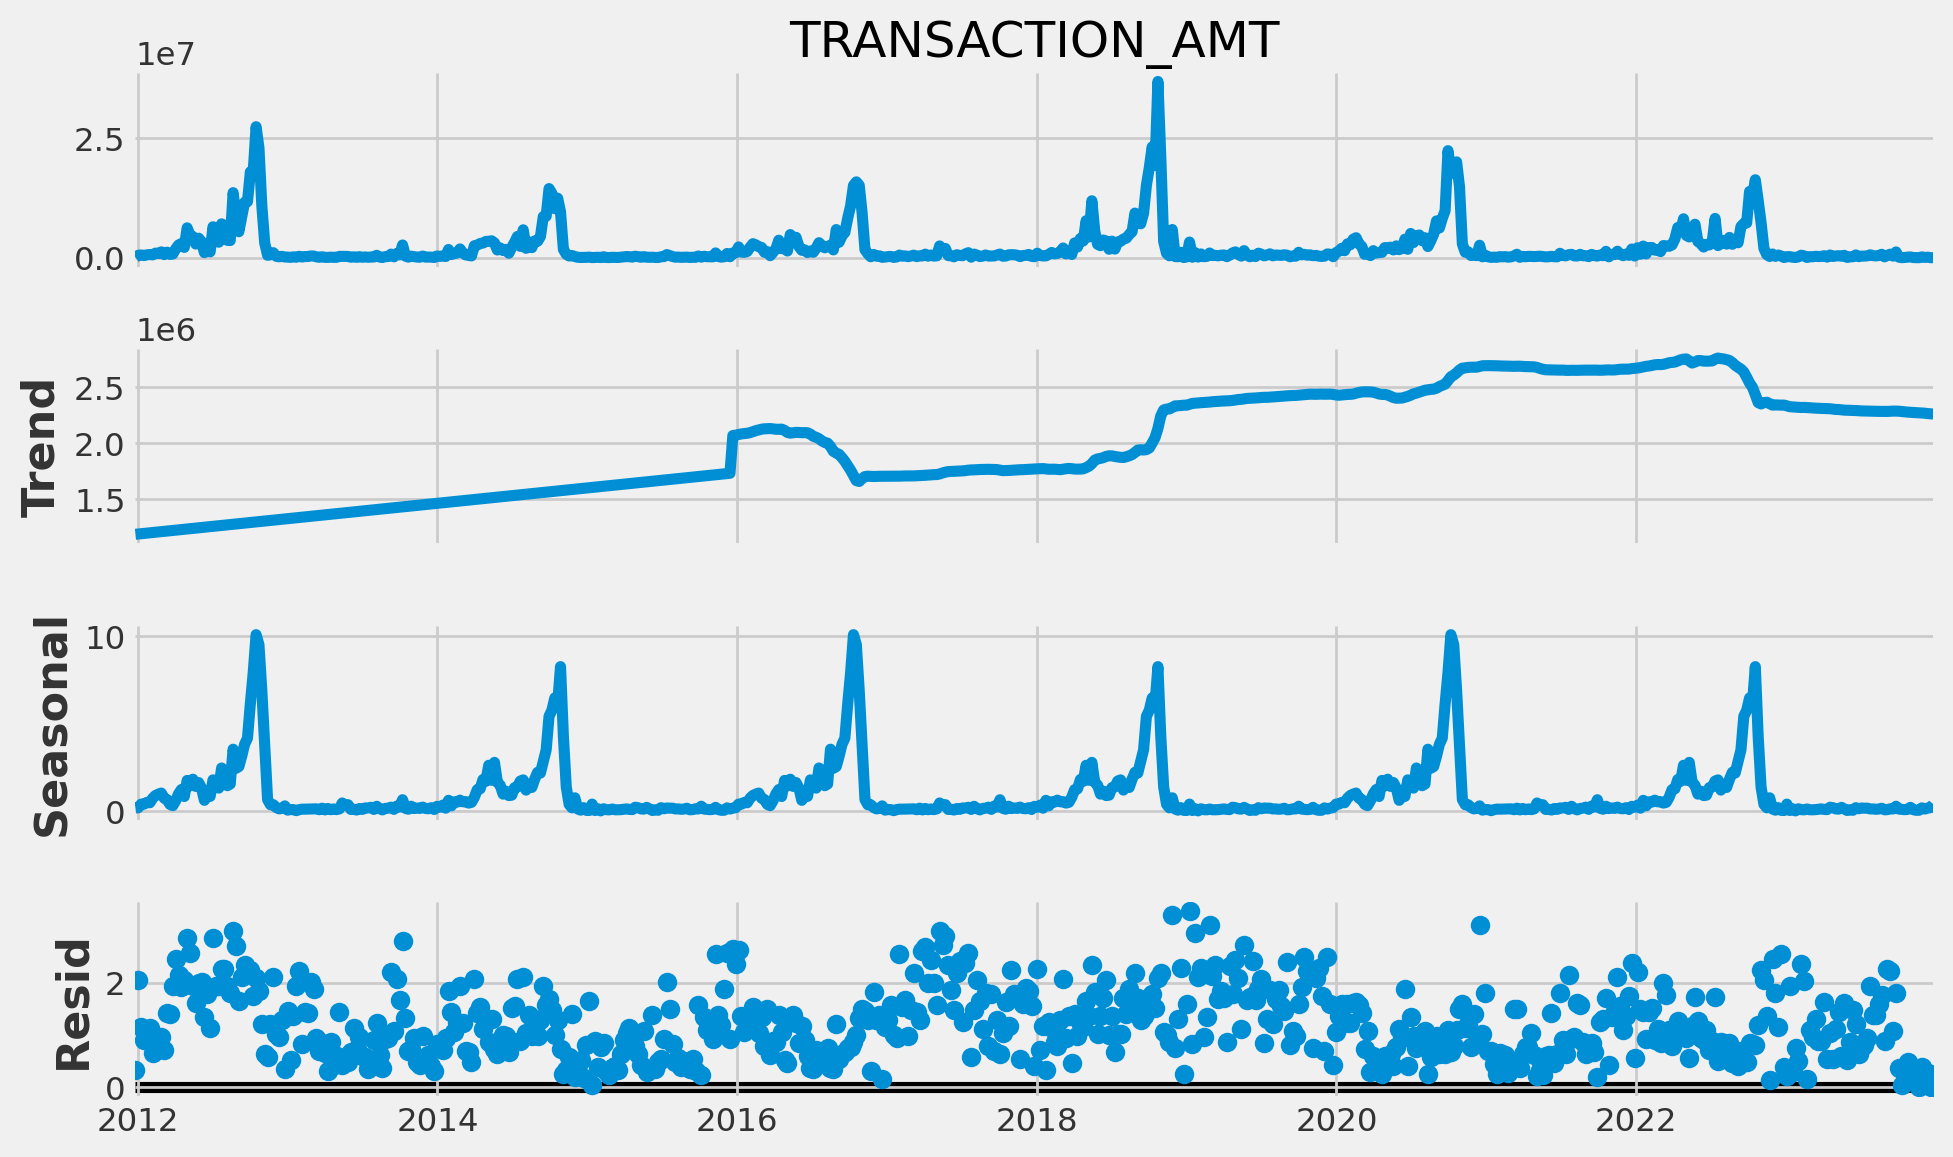

In [119]:
timeseries_datetime = timeseries.copy()
timeseries_datetime.index = timeseries.index.to_timestamp()
decomp = smt.seasonal_decompose(timeseries_datetime['TRANSACTION_AMT'].loc[:'2024-01-01'], 
                                model='multiplicative', period=208, two_sided=False,);
decomp.plot();

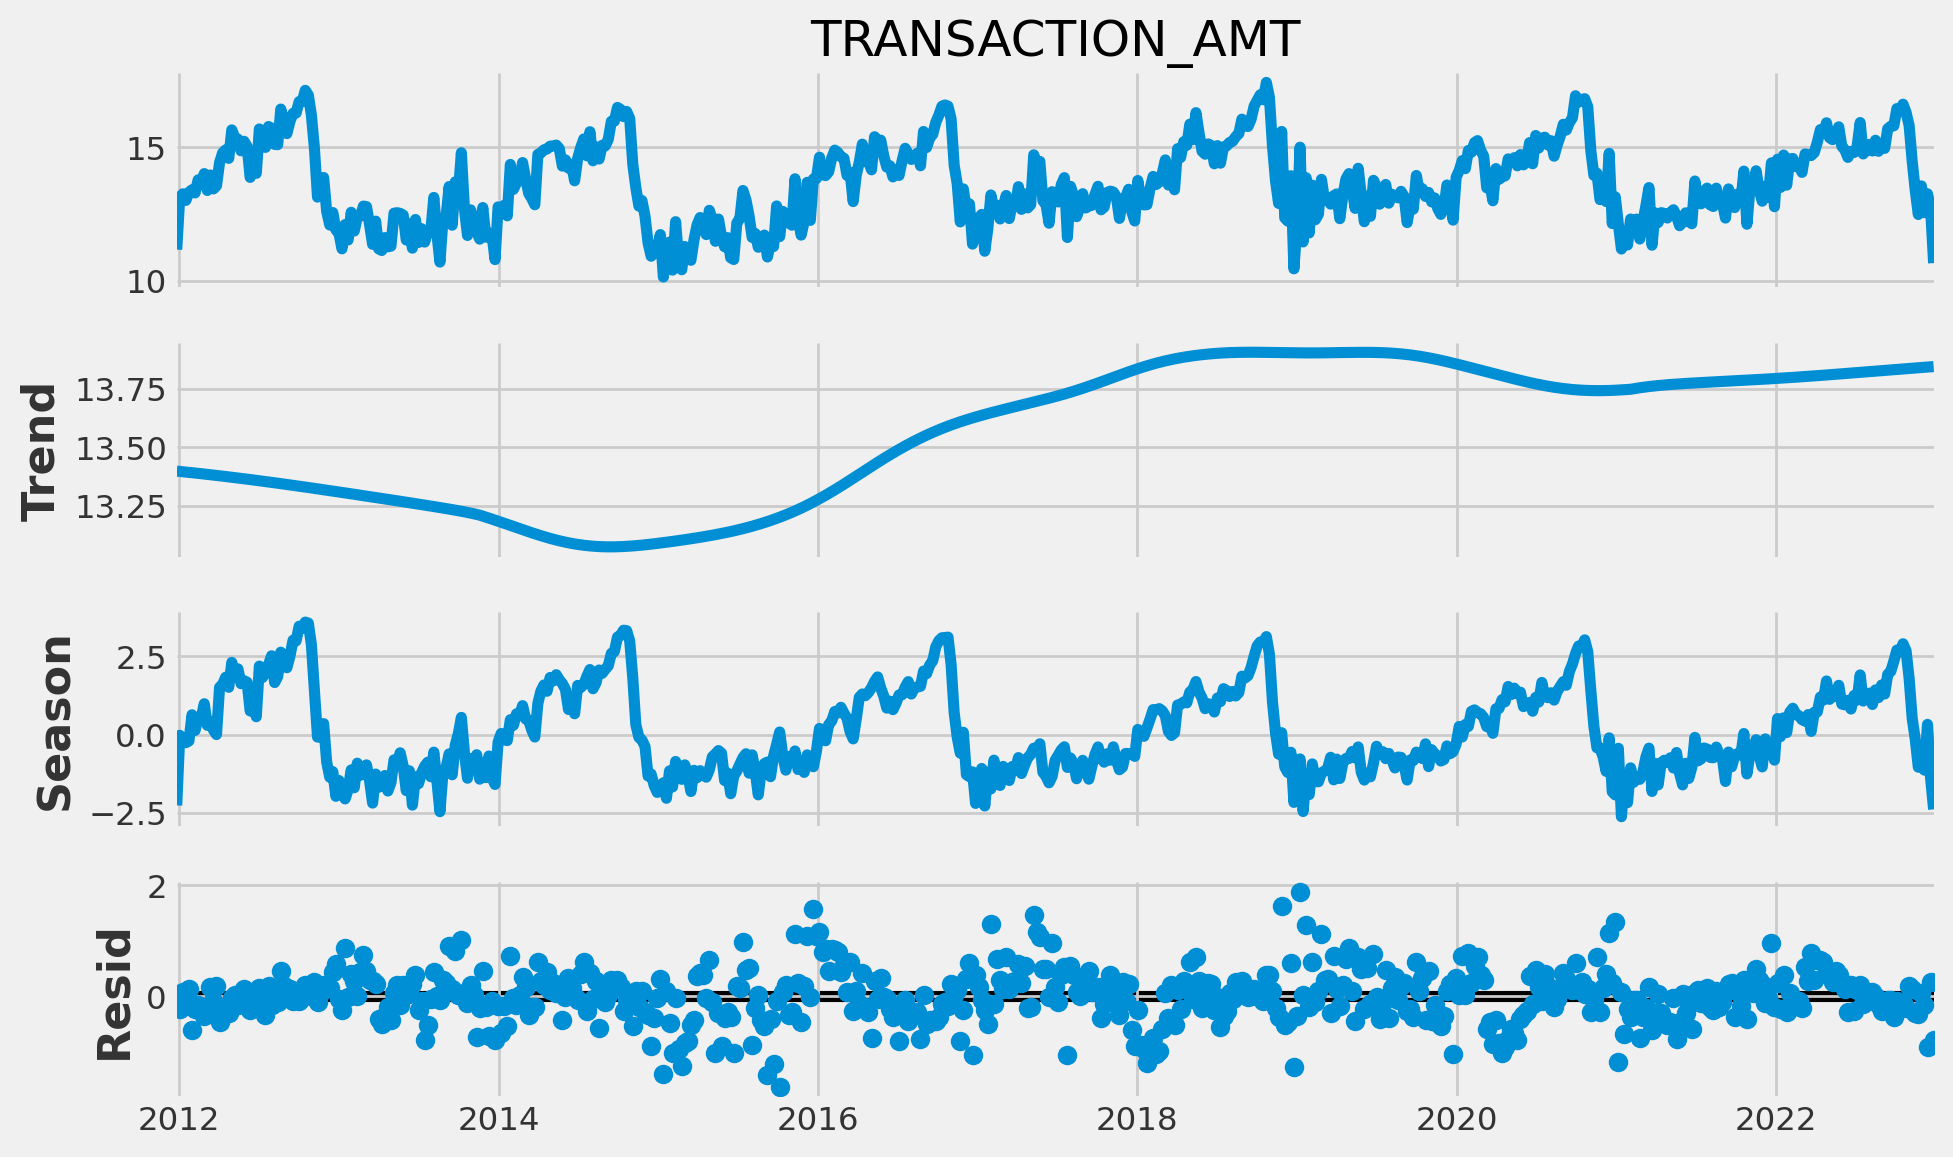

In [127]:
smt.STL(np.log(timeseries_datetime['TRANSACTION_AMT'].loc[:'2023-01-01']), period=104).fit().plot();

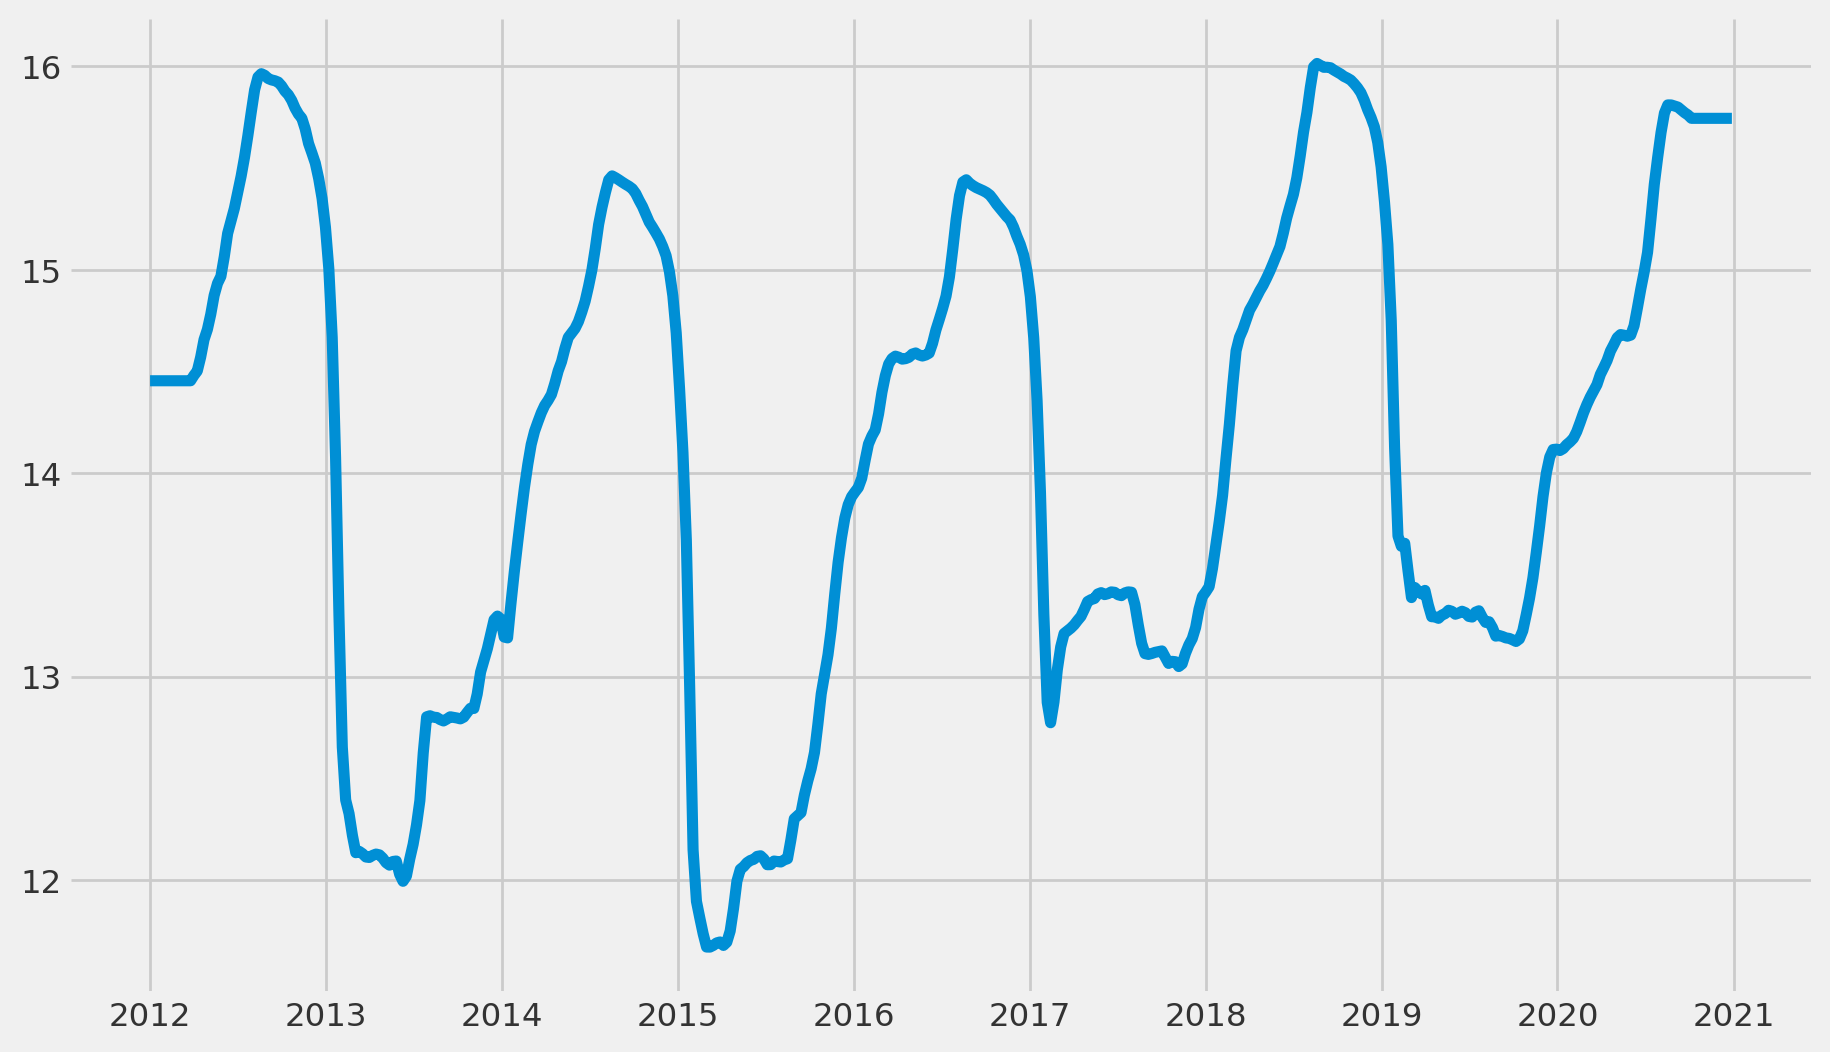

In [89]:
season = decomp.seasonal
trend  = decomp.trend
resid  = decomp.resid
plt.plot(np.log(trend.ffill().bfill()))

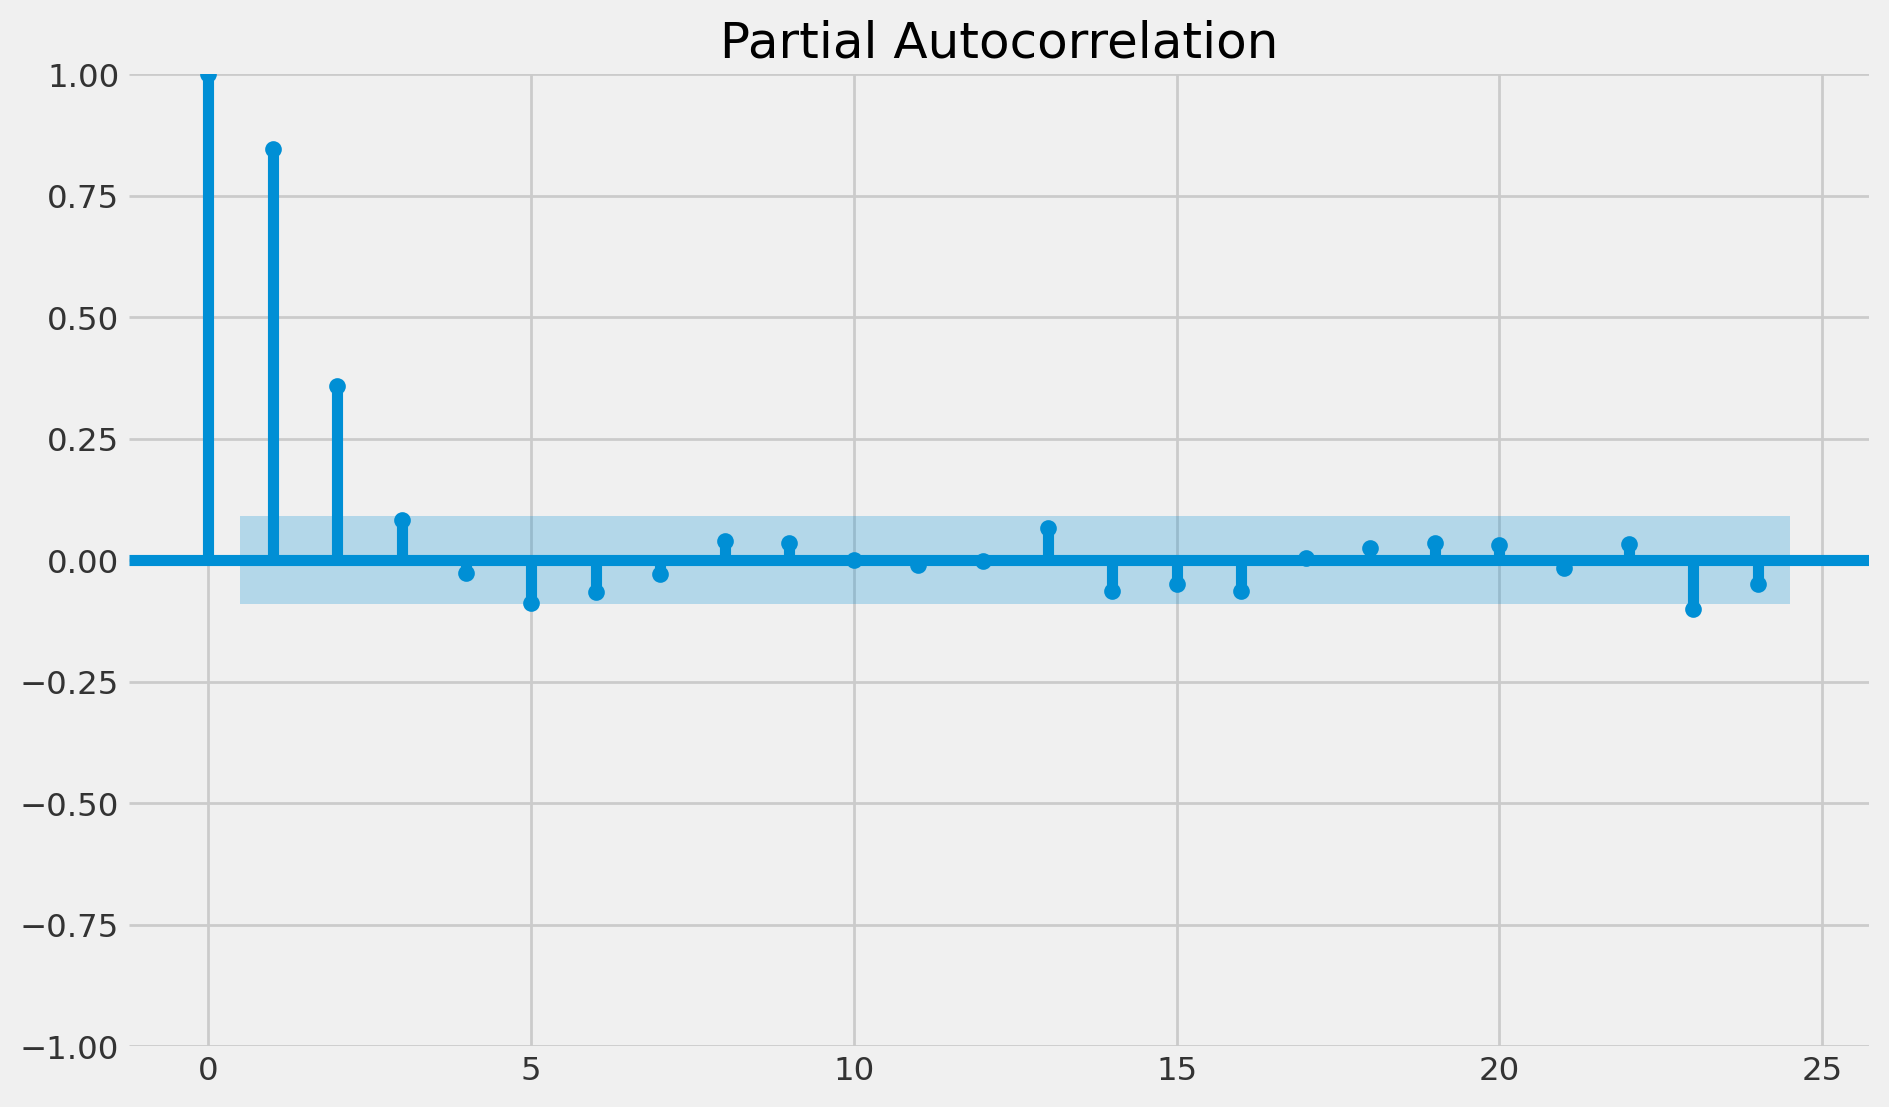

In [90]:
smt.graphics.plot_pacf(np.log(timeseries['TRANSACTION_AMT']).dropna(), lags=24);

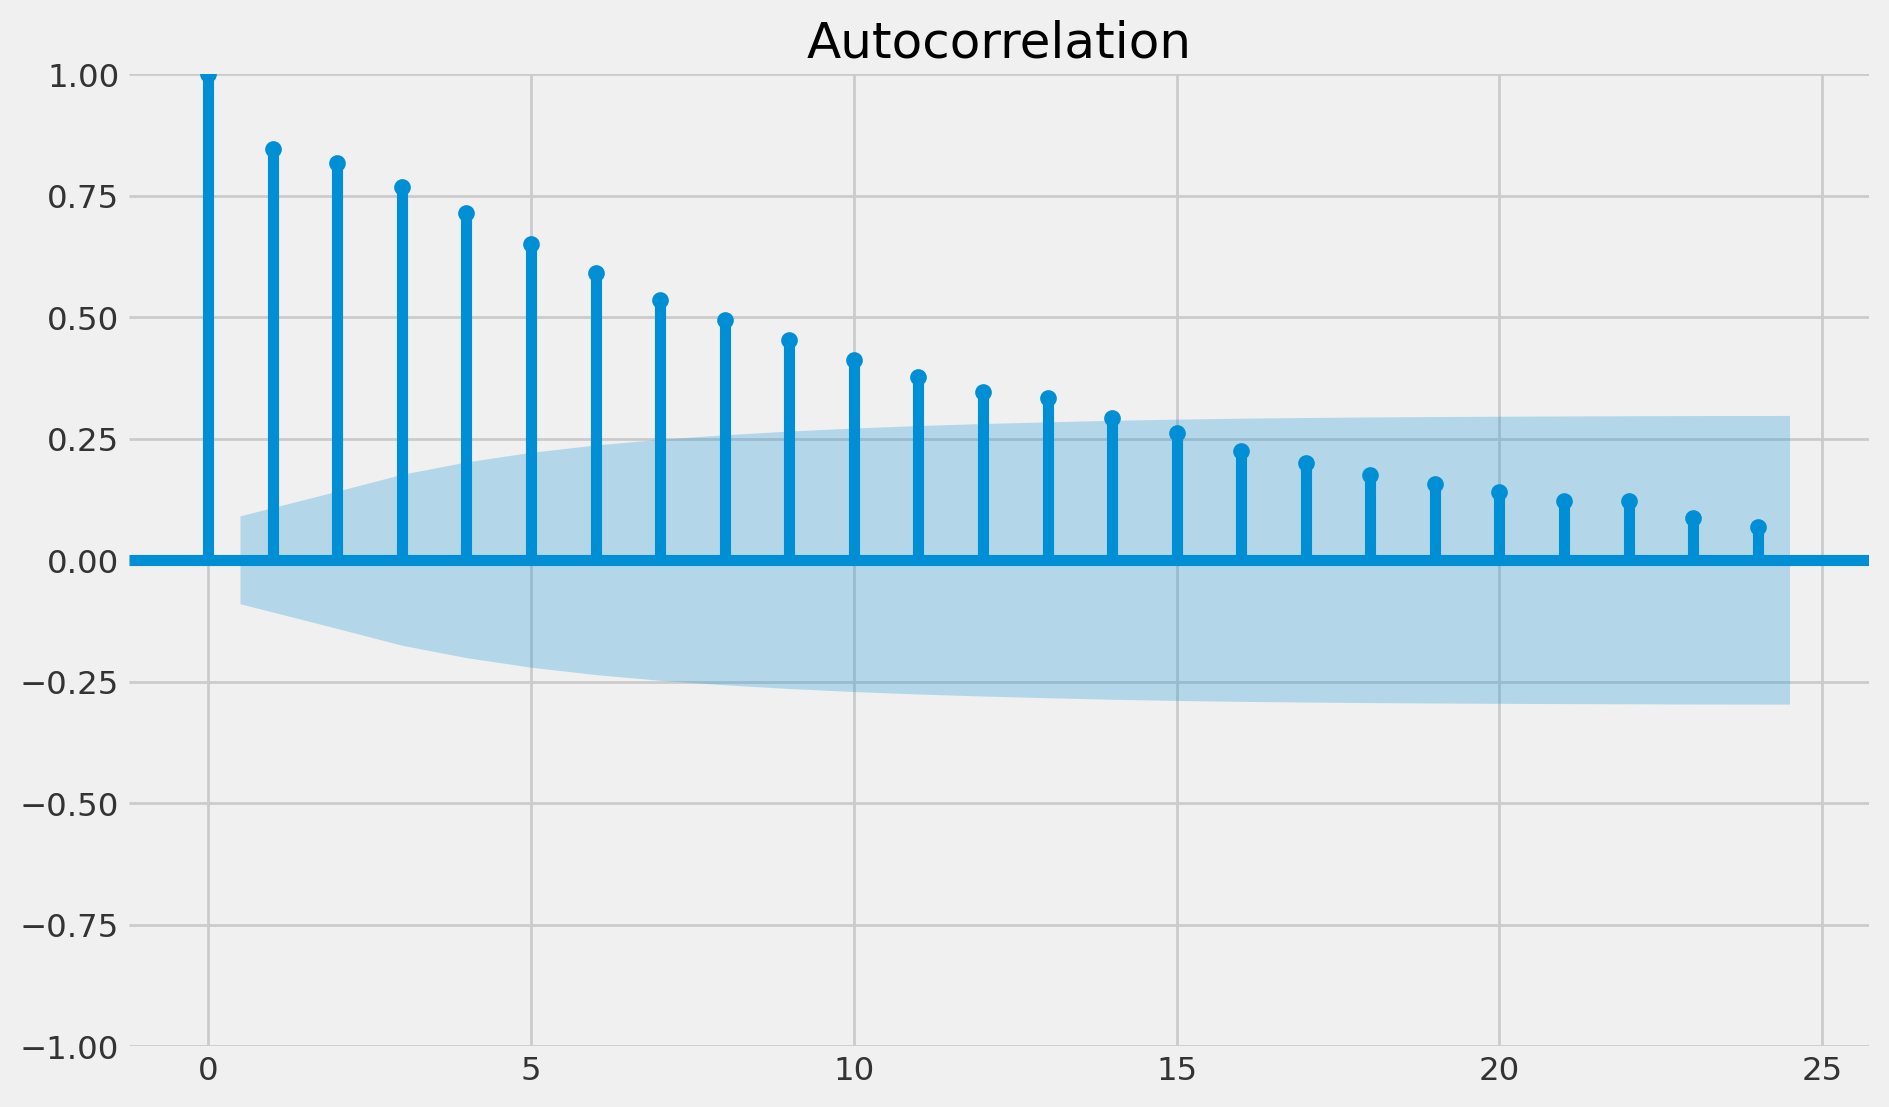

In [91]:
smt.graphics.plot_acf(np.log(timeseries['TRANSACTION_AMT']).dropna(), lags=24);

In [92]:
model_1 = smt.SARIMAX(np.log(timeseries['TRANSACTION_AMT']), order=(1, 1, 0), seasonal_order=(1, 1, 0, 104), trend='c').fit()
model_1.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66622D-01    |proj g|=  1.73206D-01

At iterate    5    f=  9.57561D-01    |proj g|=  2.23839D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   2.550D-05   9.576D-01
  F =  0.95755629119043217     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                     TRANSACTION_AMT   No. Observations:                  470
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 104)   Log Likelihood                -450.051
Date:                             Sat, 10 Feb 2024   AIC                            908.103
Time:                                     01:12:58   BIC                            923.703
Sample:                                 01-02-2012   HQIC                           914.302
                                      - 12-28-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0036      0.049      0.074      0.941      -0.092       0.099
ar.L1         -0.5307      0.038    -13.838      0.000      -0.606      -0.456
ar.S.L104     -0.4514      0.040    -11.267      0.000      -0.530      -0.373
sigma2         0.6455      0.034     19.127      0.000       0.579       0.712
===================================================================================
Ljung-Box (L1) (Q):                   9.40   Jarque-Bera (JB):                83.92
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.36
Prob(H) (two-sided):                  0.44   Kurtosis:                         5.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [93]:
timeseries["logPolling"] = np.log(timeseries["Polling"]).fillna(0)

In [132]:
timeseries["Shifted Months"] = (23-timeseries["Months Before Election"].shift(-9).fillna(0))

In [148]:
model_2 = smt.SARIMAX(np.log(timeseries['TRANSACTION_AMT']), exog=timeseries[cos_components + sin_components], order=(1, 0, 0), trend='c').fit(cov_type='robust', maxiter=1000)
model_2_summary = model_2.summary()
model_2_summary

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19649D+00    |proj g|=  6.78777D-02

At iterate    5    f=  1.18630D+00    |proj g|=  3.58820D-02

At iterate   10    f=  1.18299D+00    |proj g|=  1.16297D-02

At iterate   15    f=  1.18260D+00    |proj g|=  5.86524D-04

At iterate   20    f=  1.18259D+00    |proj g|=  4.83106D-04

At iterate   25    f=  1.18259D+00    |proj g|=  2.98753D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     25     43      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        TRANSACTION_AMT   No. Observations:                  470
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -555.819
Date:                Sat, 10 Feb 2024   AIC                           1141.638
Time:                        01:39:27   BIC                           1203.929
Sample:                    01-02-2012   HQIC                          1166.145
                         - 12-28-2020                                         
Covariance Type:               robust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.0179      0.336      6.009      0.000       1.360       2.676
cos1t         -0.0061      0.181     -0.034      0.973      -0.361       0.349
cos2t         -0.0267      0.103     -0.261      0.794      -0.228       0.174
cos3t         -0.0023      0.071     -0.033      0.974      -0.141       0.136
cos4t          0.0246      0.053      0.460      0.645      -0.080       0.129
cos5t         -0.0817      0.044     -1.860      0.063      -0.168       0.004
cos6t         -0.0063      0.039     -0.160      0.873      -0.083       0.071
sin1t         -0.1754      0.183     -0.961      0.337      -0.533       0.182
sin2t          0.0598      0.103      0.583      0.560      -0.141       0.261
sin3t          0.0847      0.071      1.185      0.236      -0.055       0.225
sin4t         -0.0146      0.056     -0.260      0.795      -0.125       0.096
sin5t         -0.0256      0.047     -0.549      0.583      -0.117       0.066
sin6t         -0.0108      0.039     -0.277      0.782      -0.087       0.066
ar.L1          0.8516      0.024     35.345      0.000       0.804       0.899
sigma2         0.6216      0.055     11.405      0.000       0.515       0.728
===================================================================================
Ljung-Box (L1) (Q):                  45.17   Jarque-Bera (JB):                60.10
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                            -0.34
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.61
===================================================================================

Warnings:
[1] Quasi-maximum likelihood covariance matrix used for robustness to some misspecifications; calculated using the observed information matrix (complex-step) described in Harvey (1989).
"""

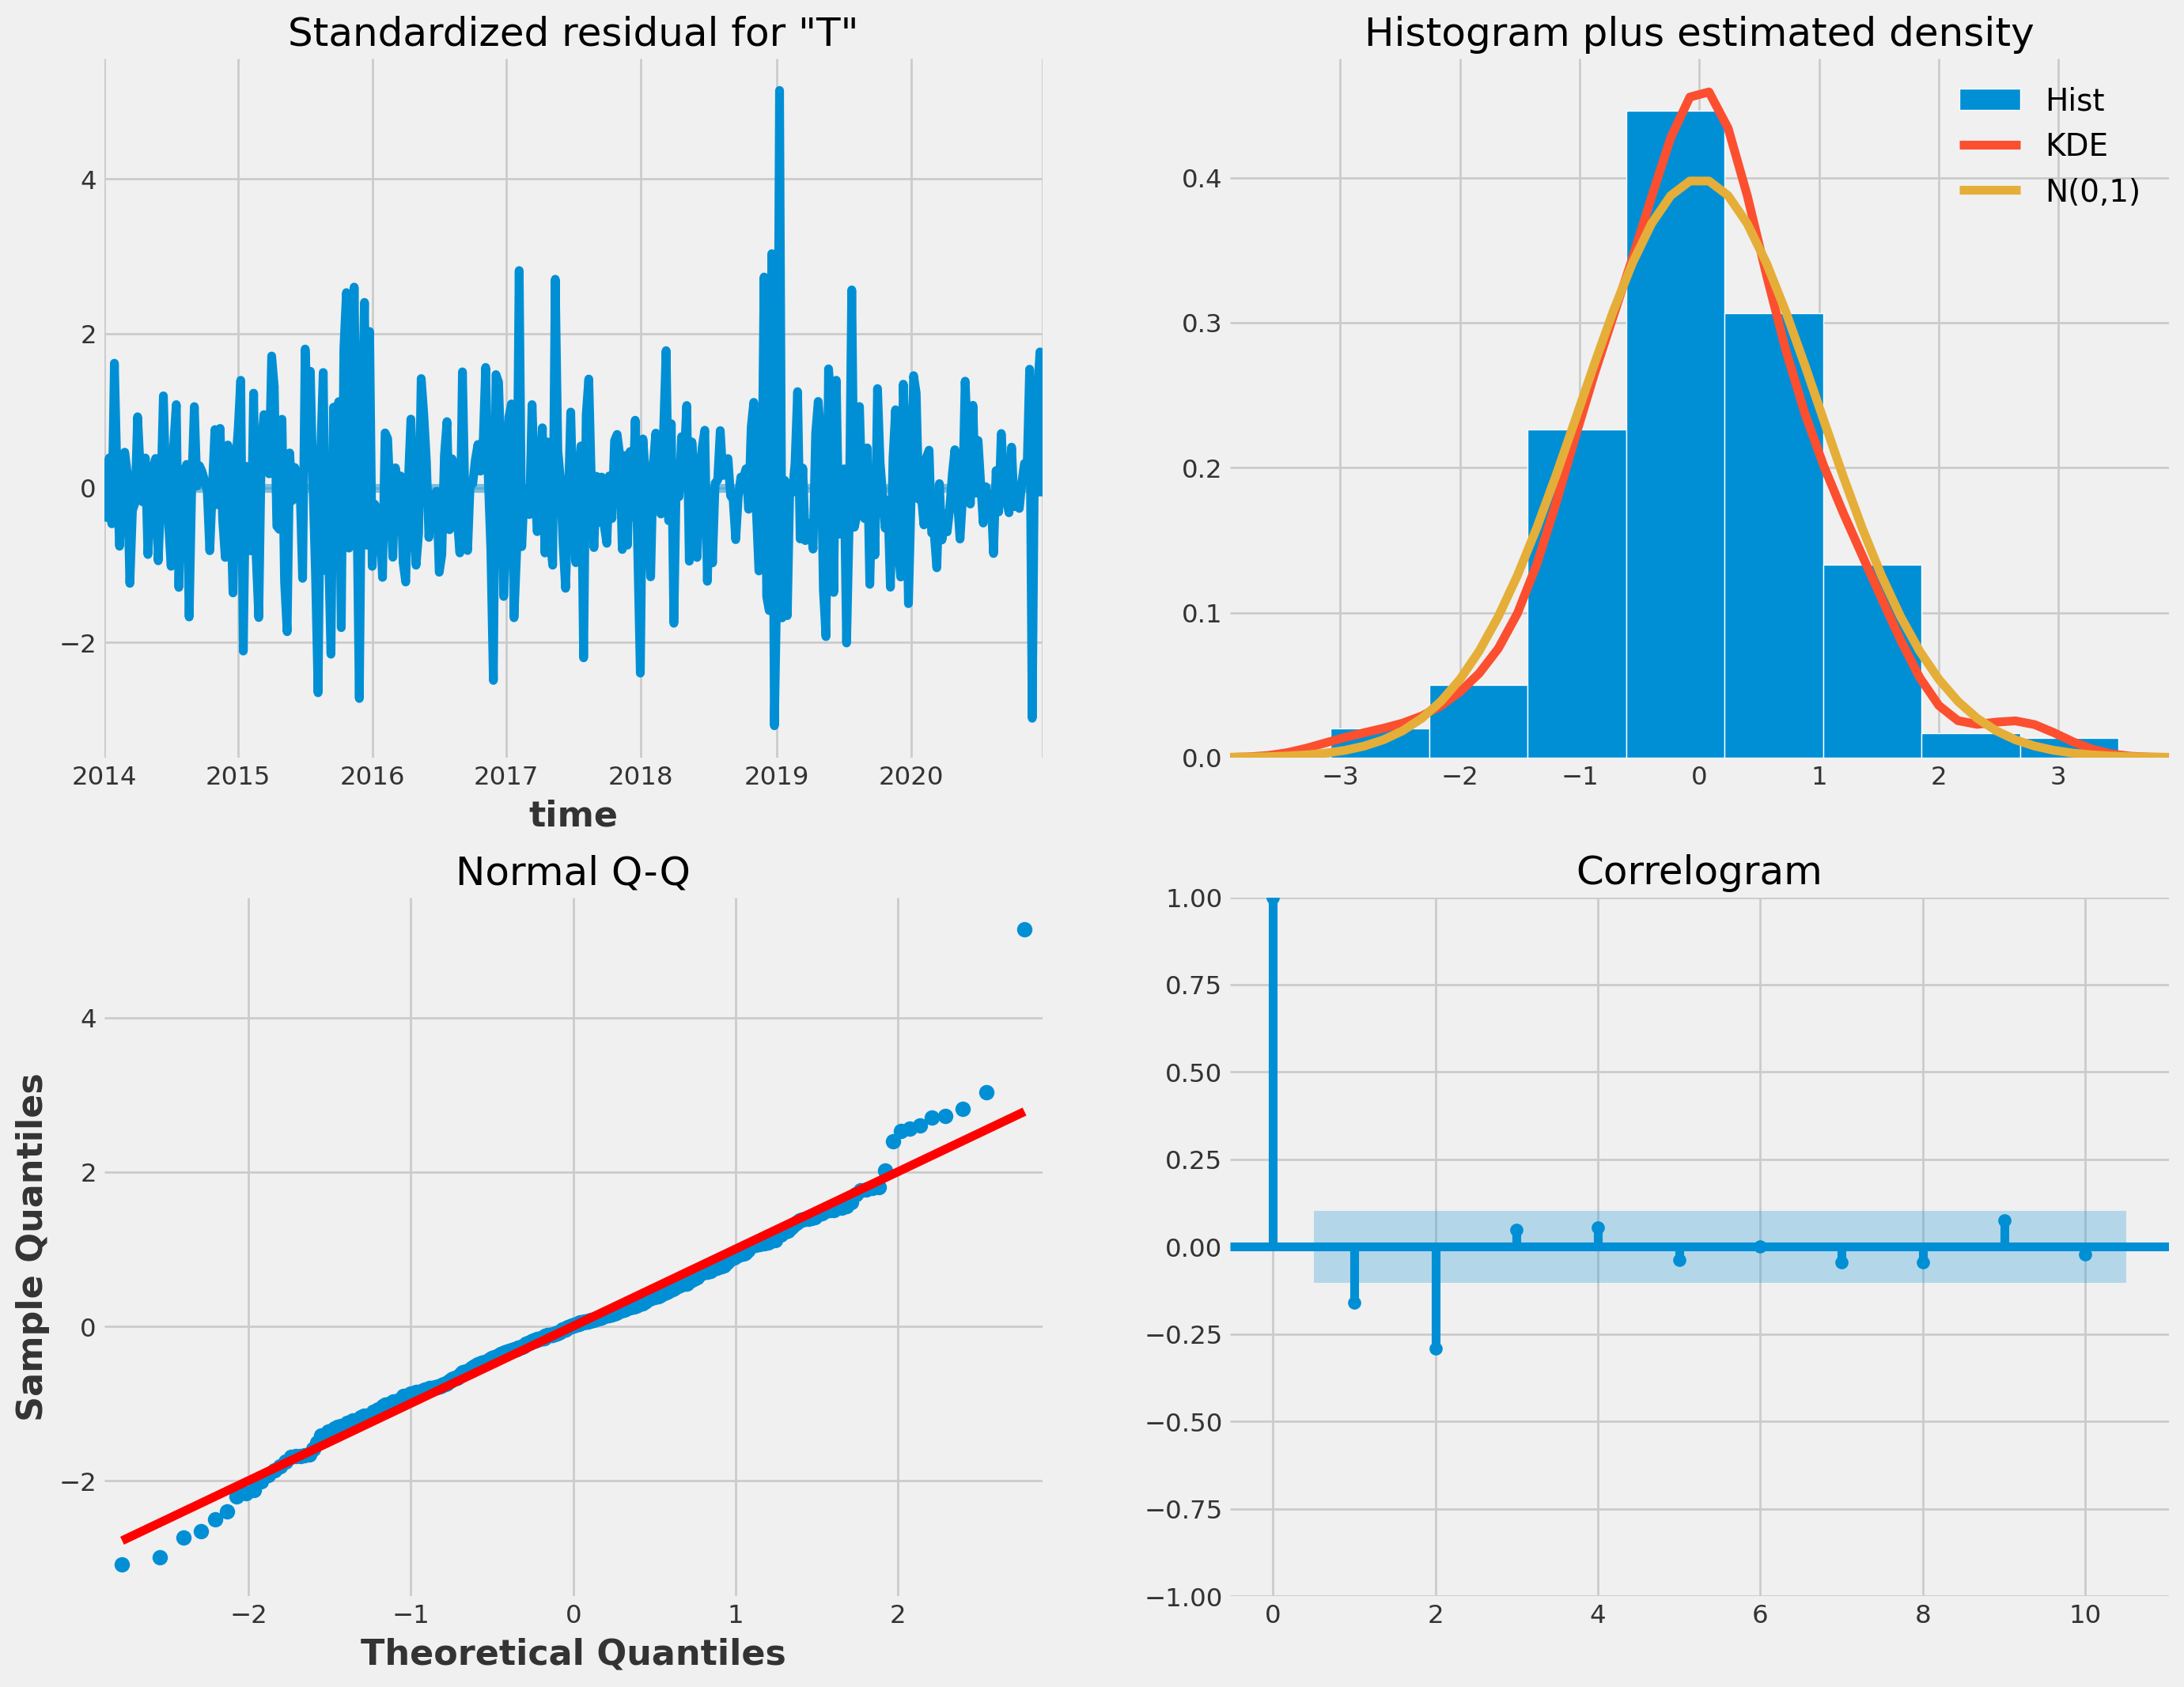

In [149]:
model_1.plot_diagnostics(figsize=(15, 12));

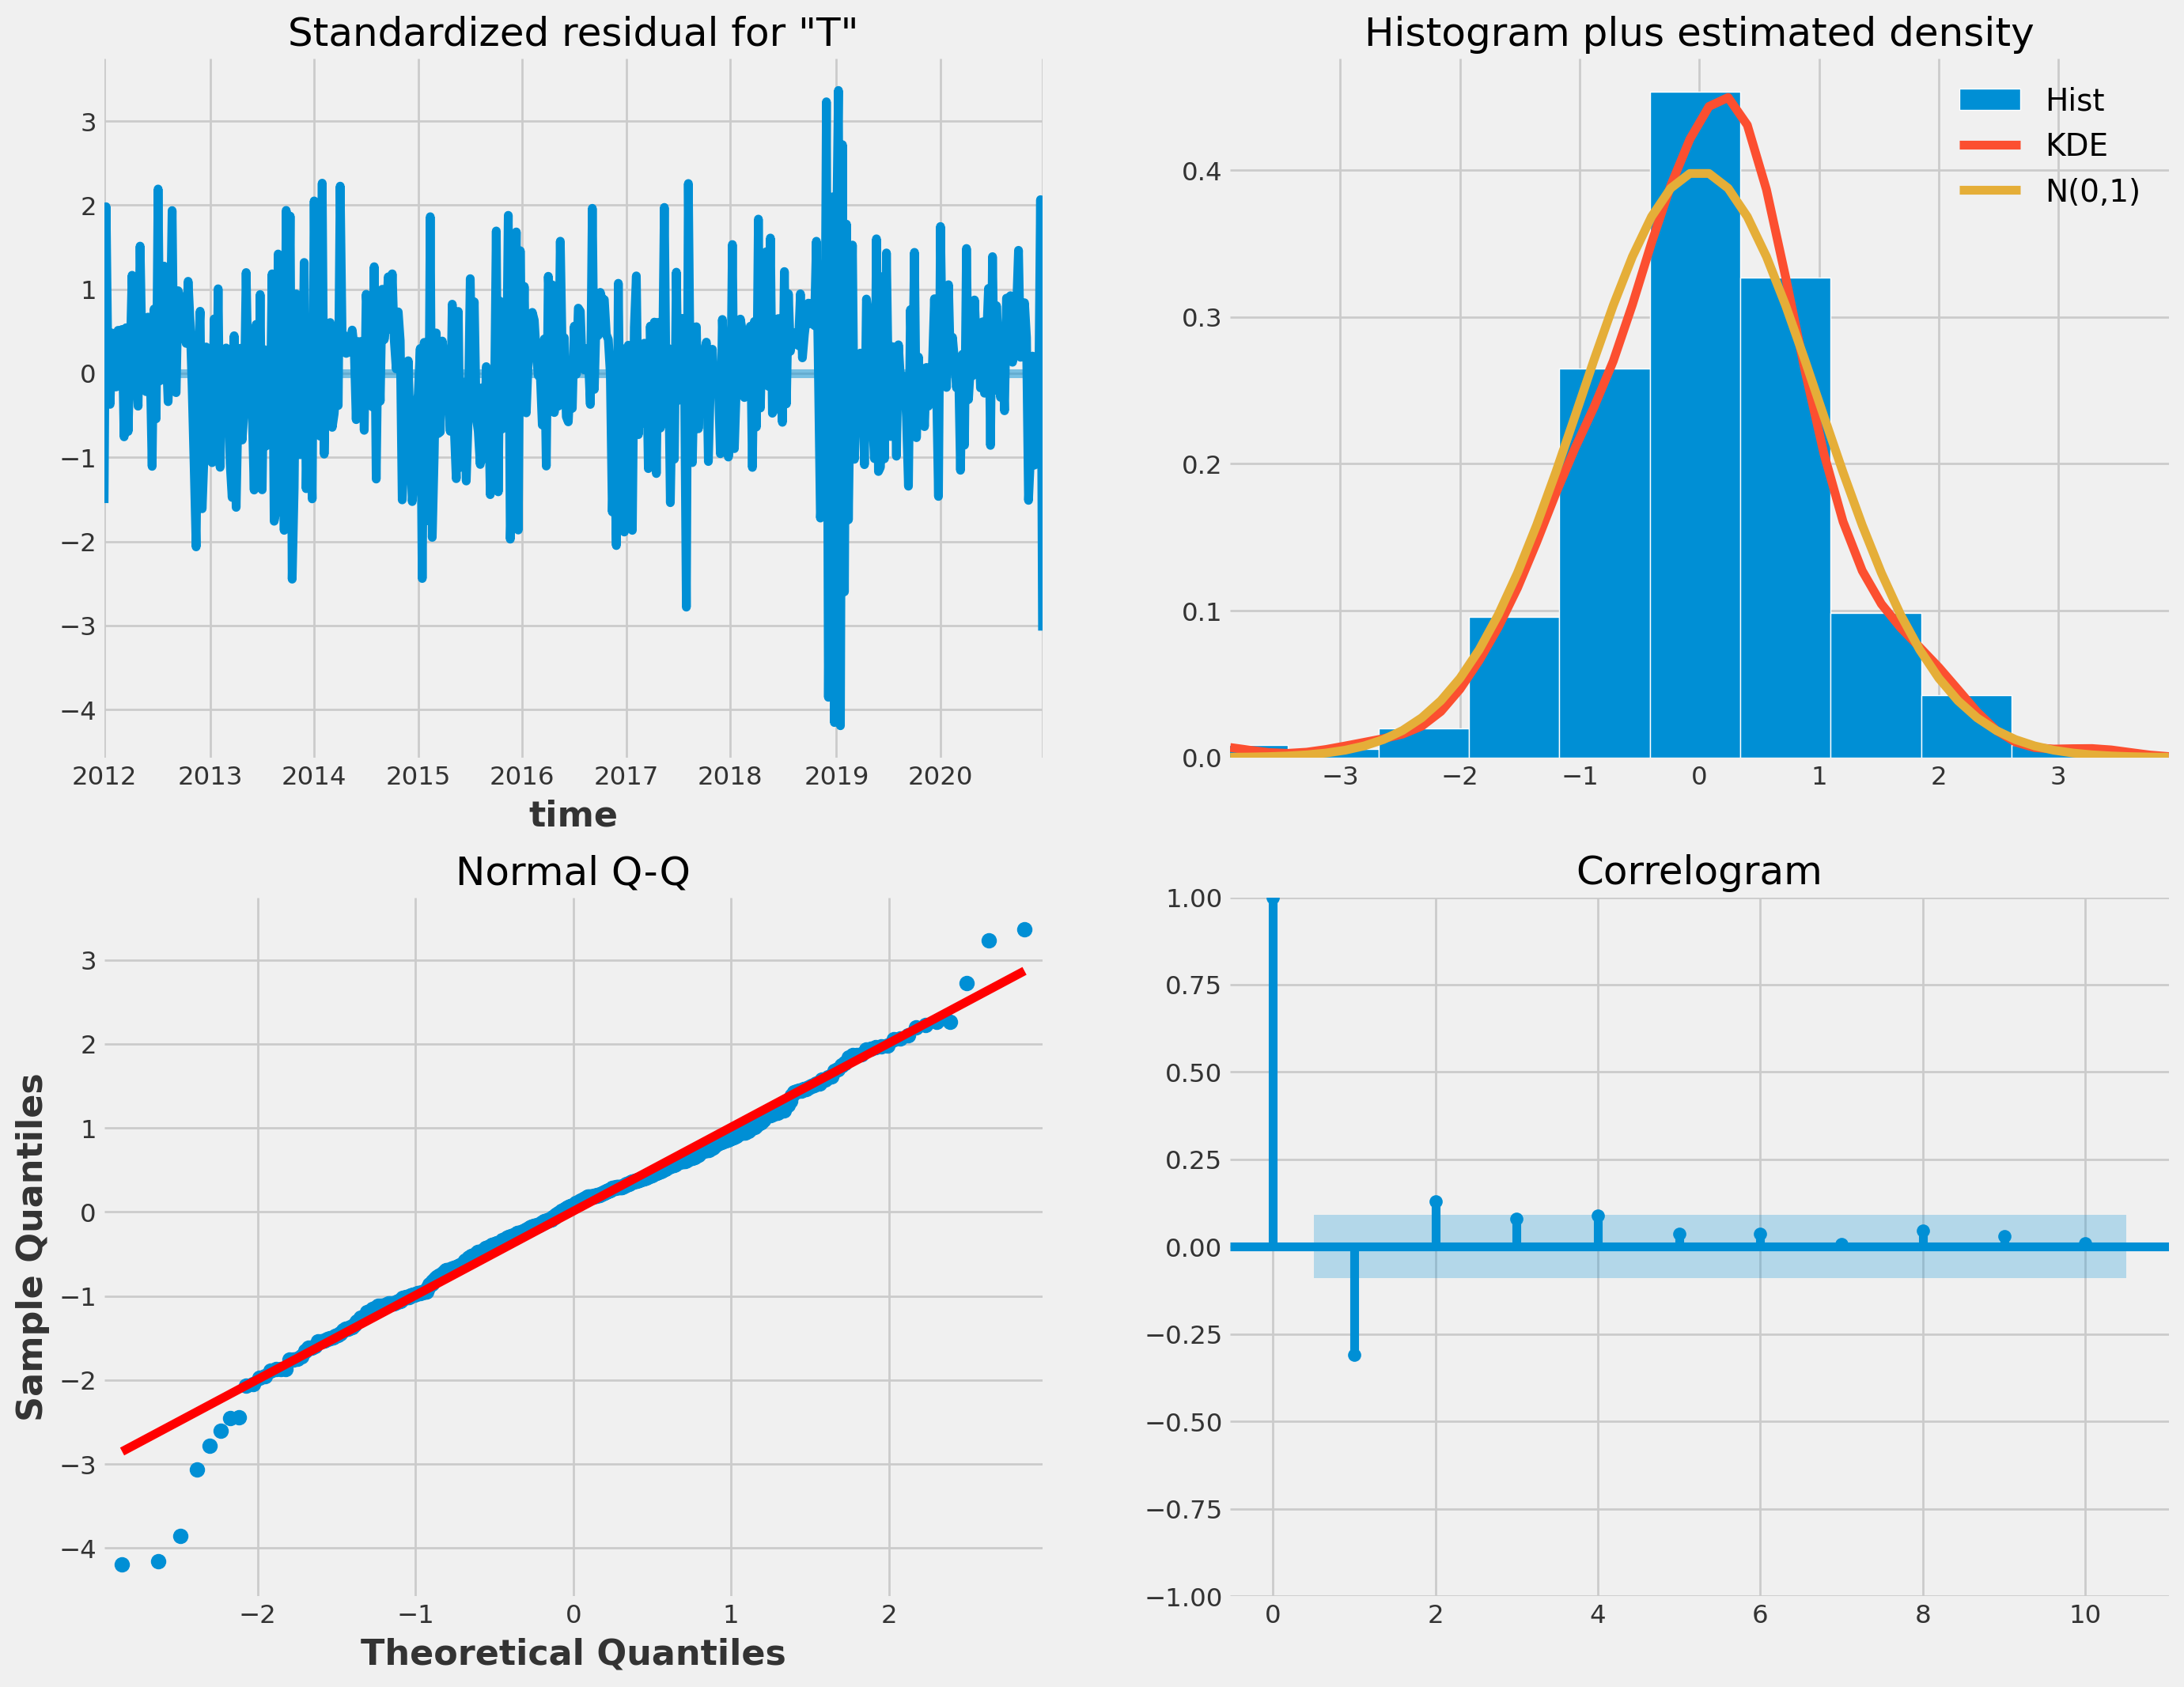

In [150]:
model_2.plot_diagnostics(figsize=(15, 12));


In [151]:
holdout['logPolling'] = np.log(holdout['Polling']).fillna(0)
holdout

TRANSACTION_AMT  Election_Day  ...  September  Shifted Months
time                                       ...                           
2021-01-04        509792.74             0  ...          0             4.0
2021-01-11        183634.28             0  ...          0             4.0
2021-01-18         72790.74             0  ...          0             4.0
2021-01-25        116670.64             0  ...          0             4.0
2021-02-01         84604.43             0  ...          0             9.0
...                     ...           ...  ...        ...             ...
2024-10-28             0.00             0  ...          0             NaN
2024-11-04             0.00             1  ...          0             NaN
2024-11-11             0.00             1  ...          0             NaN
2024-11-18             0.00             1  ...          0             NaN
2024-11-25             0.00             1  ...          0             NaN

[204 rows x 70 columns]

In [152]:
holdout["Shifted Months"] = (23-holdout["Months Before Election"].shift(-9))**2

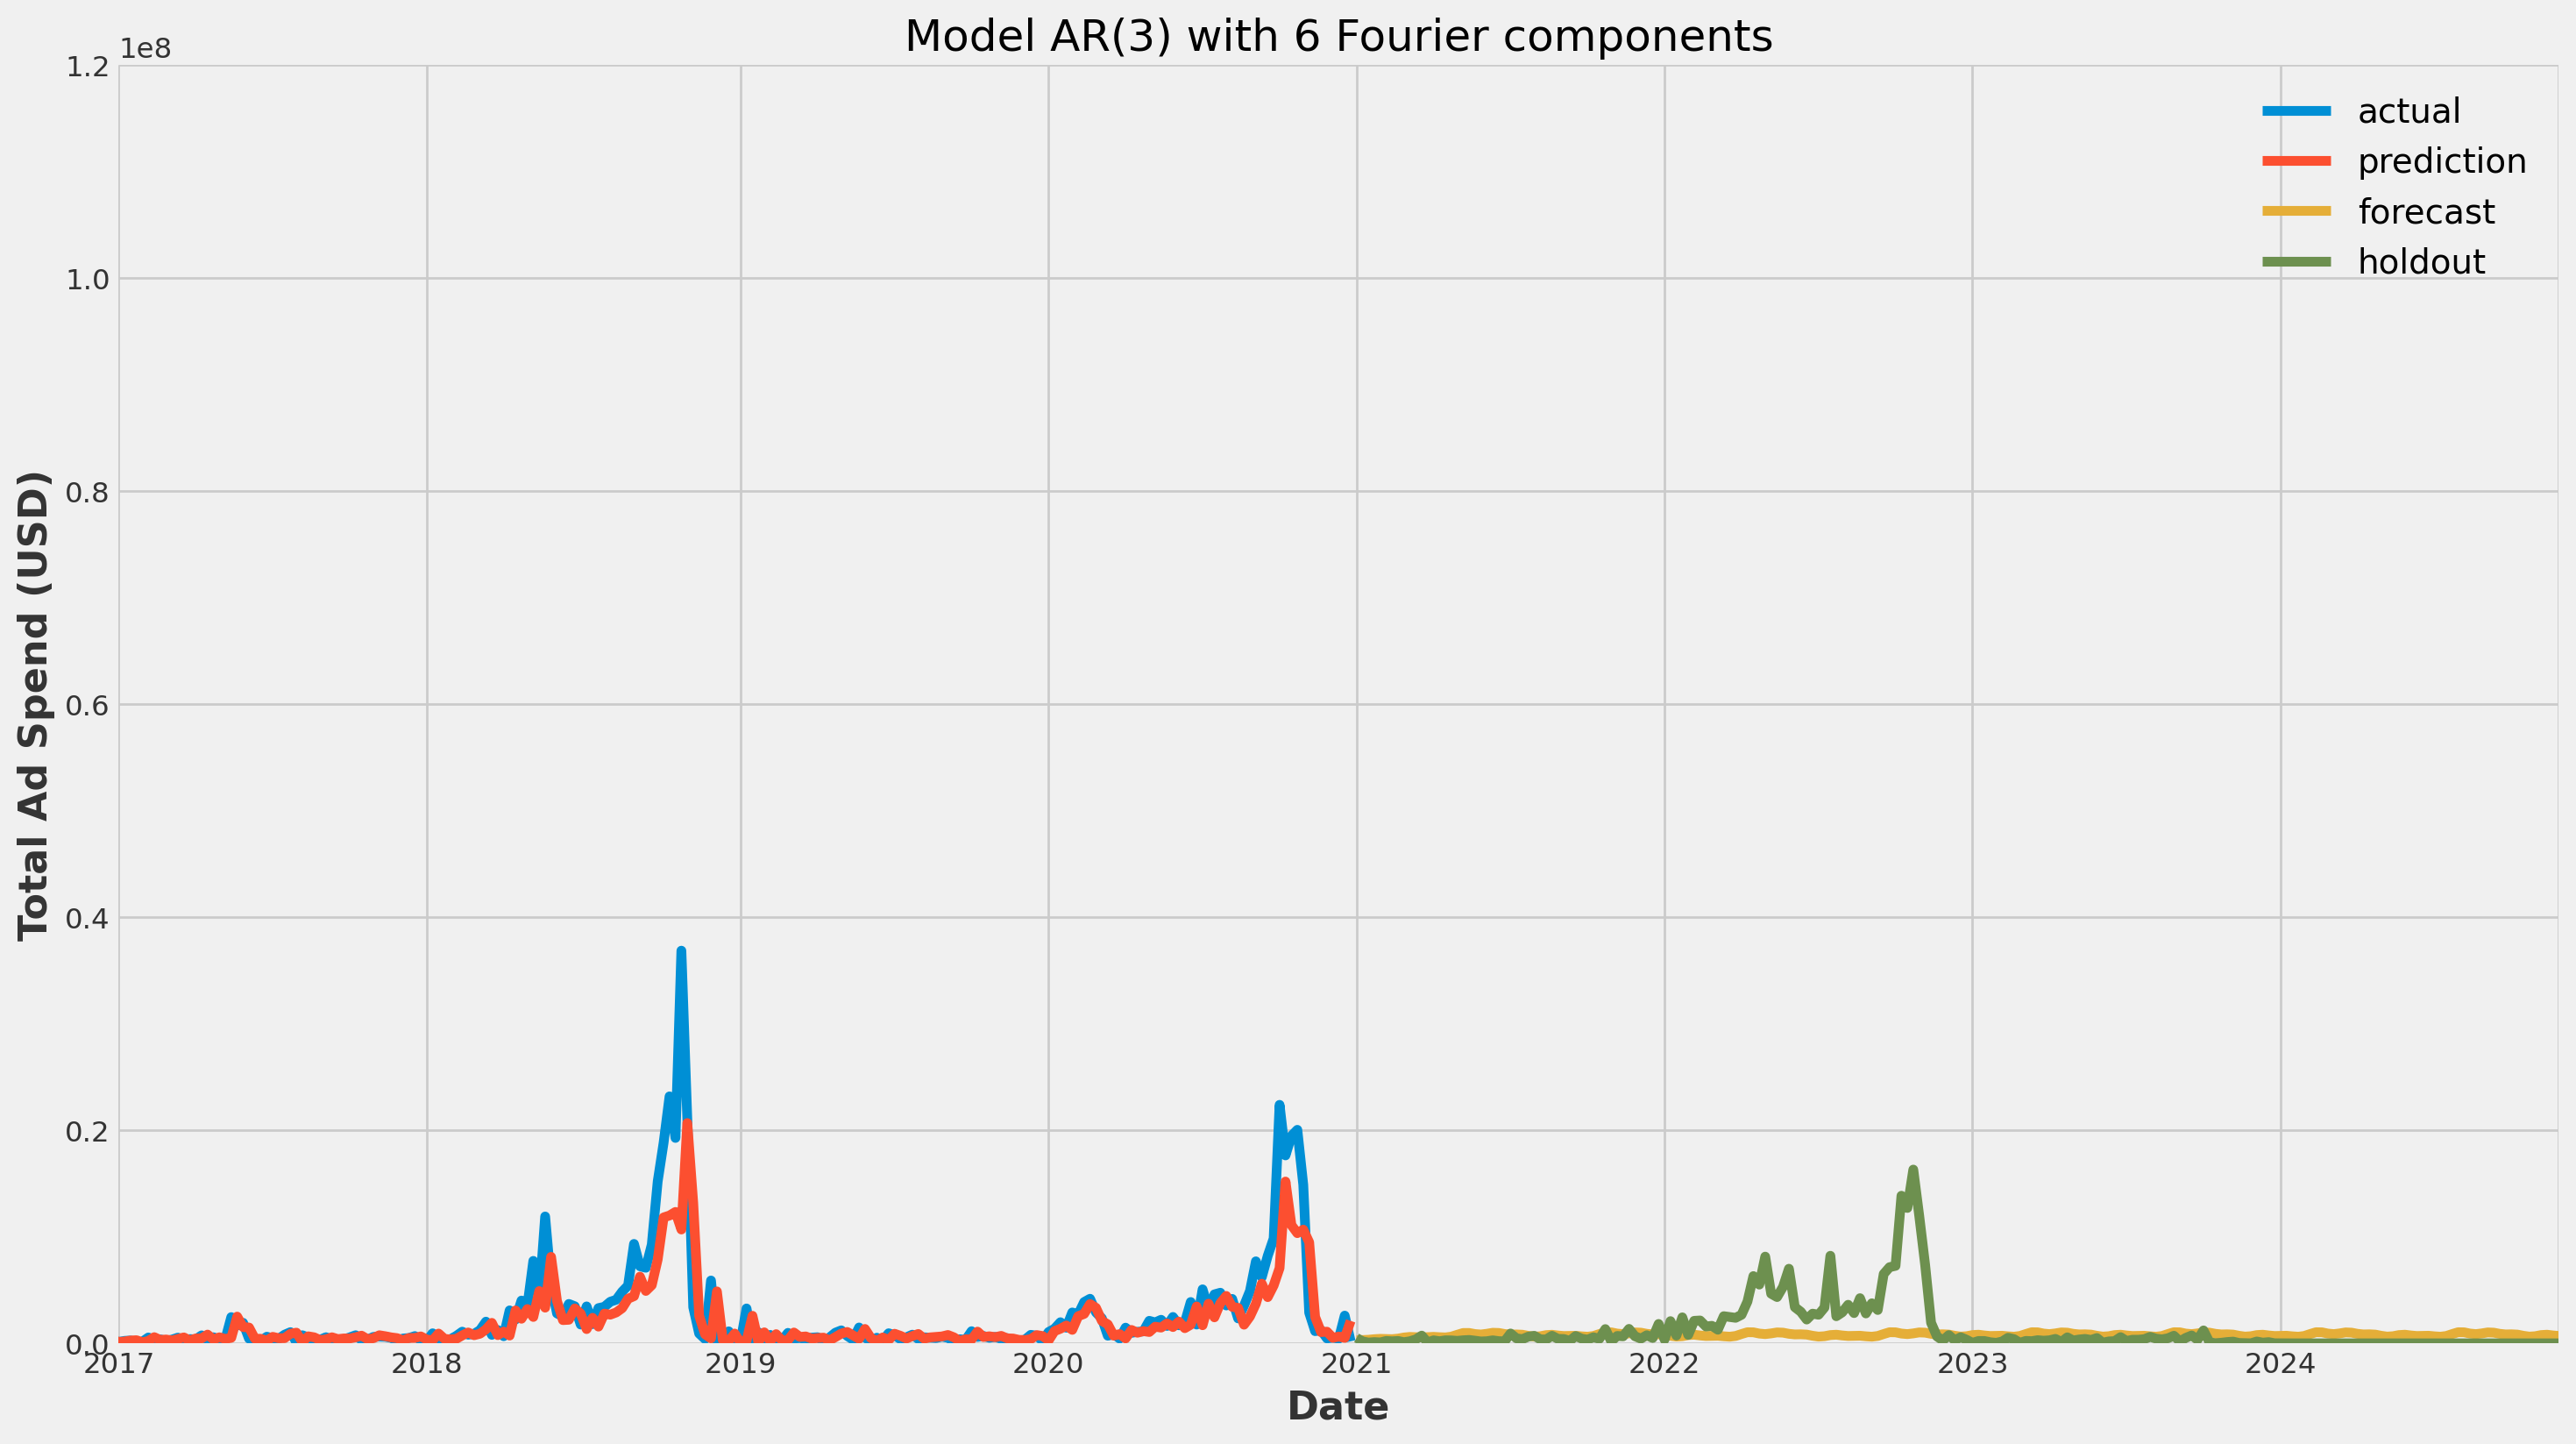

In [153]:
model_2_df = pd.DataFrame(
  {
    'actual': timeseries['TRANSACTION_AMT'],
    'prediction': np.exp(model_2.predict()), 
    'forecast': np.exp(model_2.forecast(exog=holdout[sin_components+cos_components].fillna(0), steps=len(holdout))), 
    "holdout": holdout['TRANSACTION_AMT']
  }
)
model_2_df.plot(figsize=(16, 9));
plt.xlim(pd.to_datetime('2017-01-01'));
plt.ylim(0, 1.2e8);
plt.title("Model AR(3) with 6 Fourier components");
plt.ylabel("Total Ad Spend (USD)");
plt.xlabel("Date");

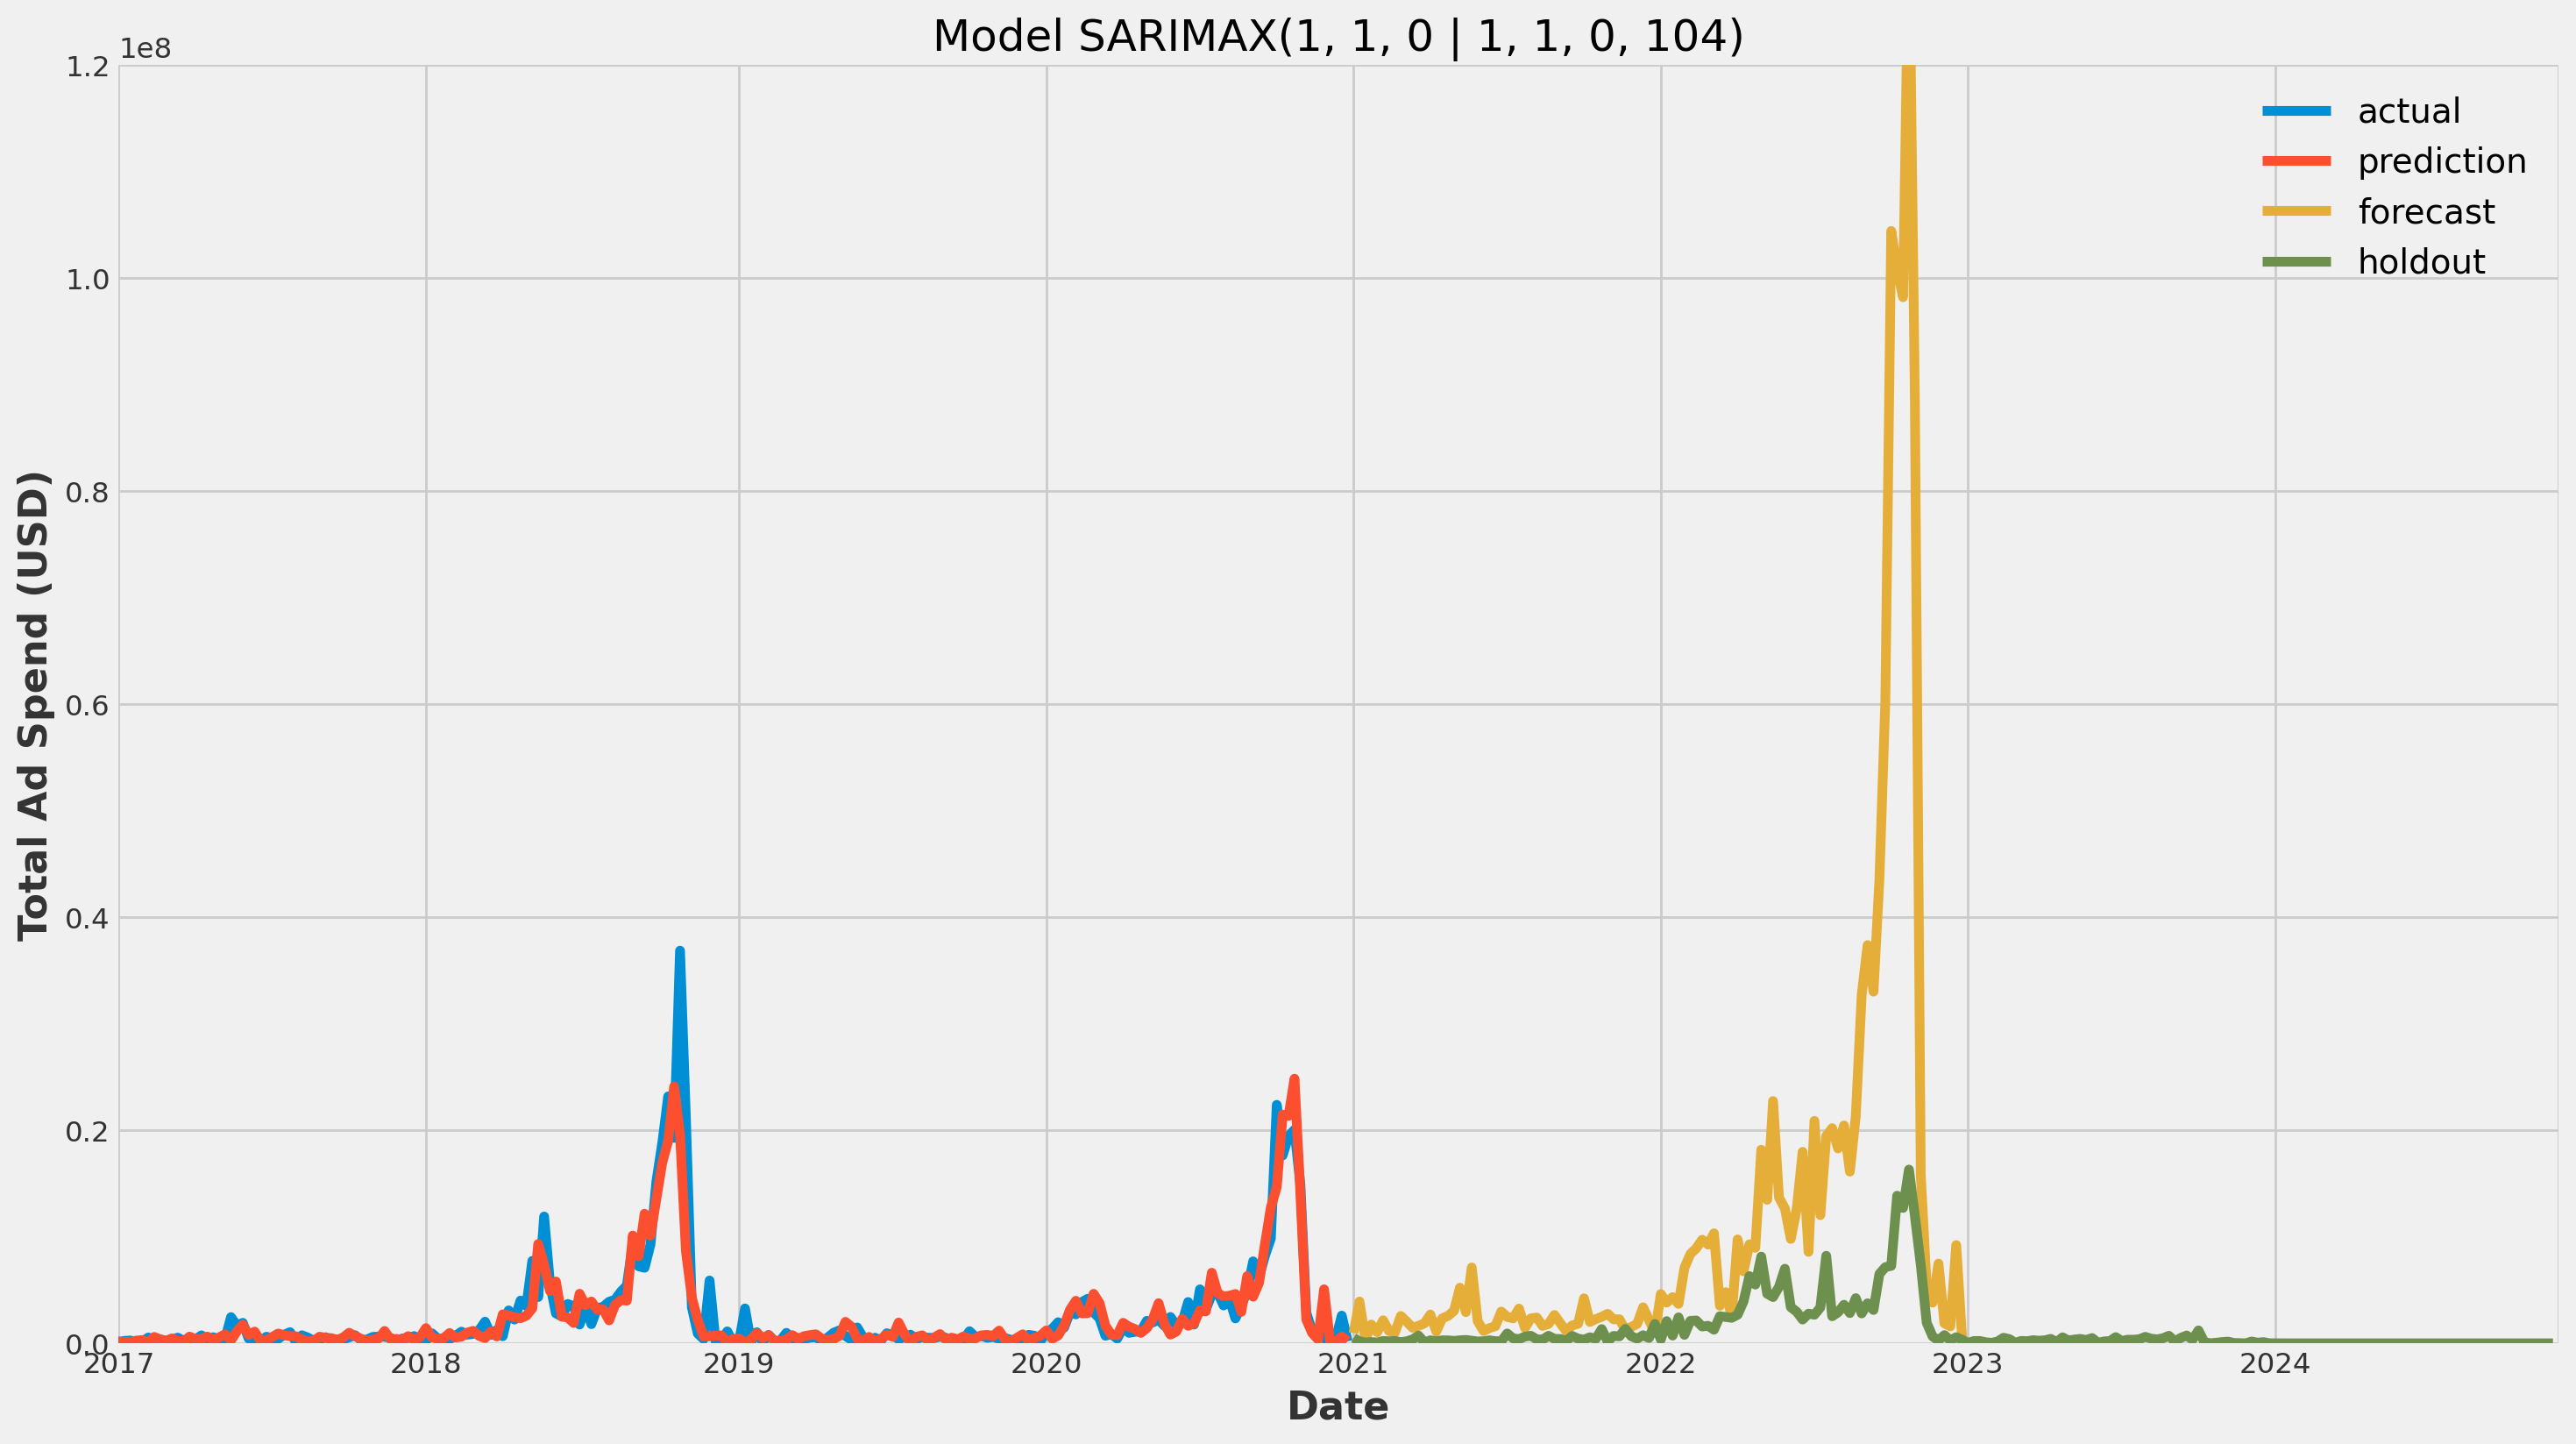

In [154]:
model_1_df = pd.DataFrame(
  {
    'actual': timeseries['TRANSACTION_AMT'],
    'prediction': np.exp(model_1.predict()), 
    'forecast': np.exp(model_1.forecast(steps=104)), 
    "holdout": holdout['TRANSACTION_AMT']
  }
)
model_1_df.plot(figsize=(16, 9));
plt.xlim(pd.to_datetime('2017-01-01'), pd.to_datetime('2024-12-01'));
plt.ylim(0, 1.2e8);
plt.title("Model SARIMAX(1, 1, 0 | 1, 1, 0, 104)");
plt.ylabel("Total Ad Spend (USD)");
plt.xlabel("Date");

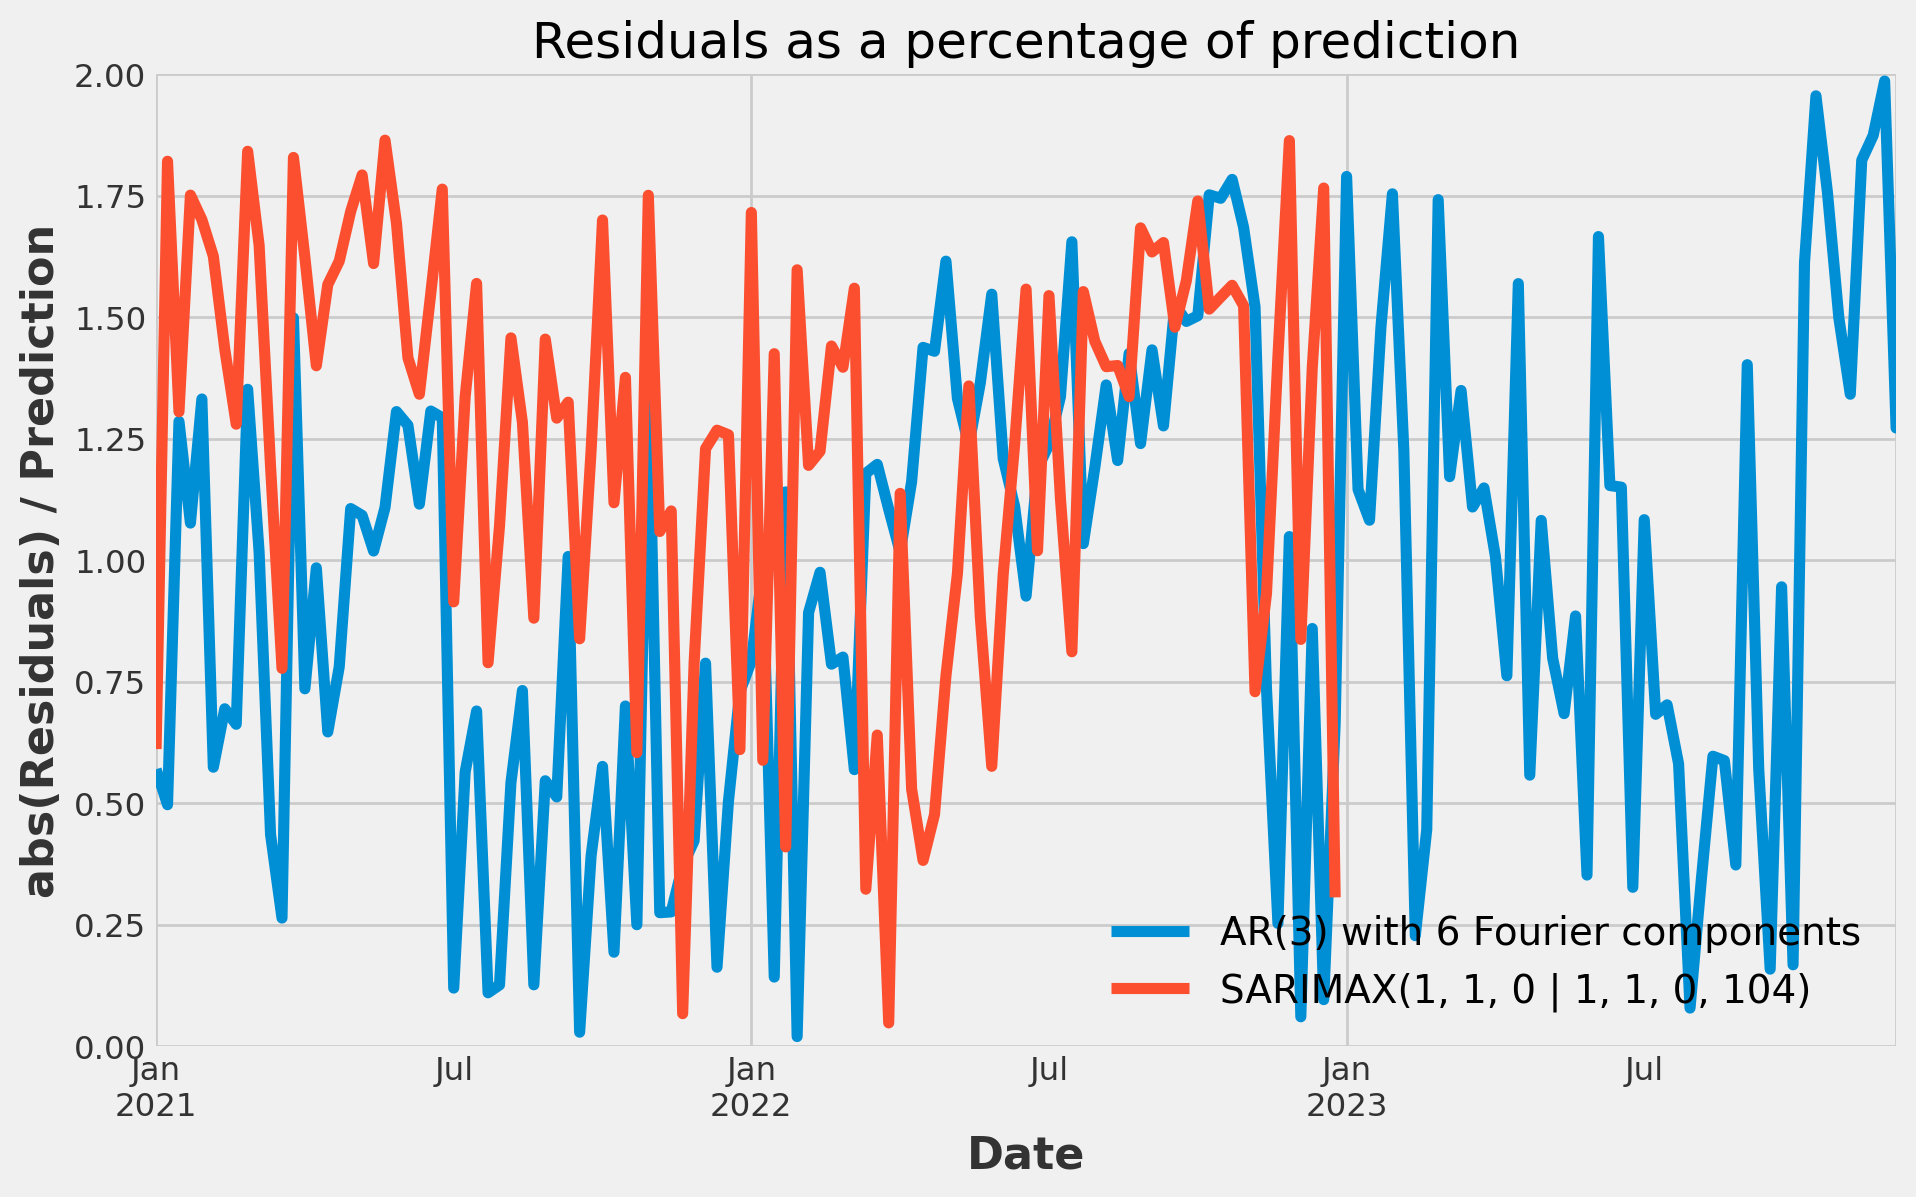

In [155]:
model_2_df['residuals'] = (model_2_df['actual'] - model_2_df['prediction']).fillna(0)
model_1_df['residuals'] = (model_1_df['actual'] - model_1_df['prediction']).fillna(0)
model_2_df['holdout_residuals'] = (model_2_df['holdout'] - model_2_df['forecast']).fillna(0)
model_1_df['holdout_residuals'] = (model_1_df['holdout'] - model_1_df['forecast']).fillna(0)

(np.abs(model_2_df['holdout_residuals'])/(model_2_df['holdout'] + model_2_df['forecast'])*2).plot(label="AR(3) with 6 Fourier components")
(np.abs(model_1_df['holdout_residuals'])/(model_1_df['holdout'] + model_1_df['forecast'])*2).plot(label='SARIMAX(1, 1, 0 | 1, 1, 0, 104)')
plt.legend()
plt.xlabel("Date");
plt.ylabel("abs(Residuals) / Prediction");
plt.title("Residuals as a percentage of prediction");
plt.xlim(pd.to_datetime('2021-01-01'), pd.to_datetime('2023-12-01'));
plt.ylim(0, 2);


In [156]:
(np.abs(model_2_df['residuals'])/model_2_df['prediction']).mean()

0.7411317706356305

In [202]:
(np.abs(model_1_df['residuals'])/model_1_df['prediction']).mean()

21591.751940717255

In [203]:
import statsmodels.api as sm

In [204]:
from sklearn.ensemble import RandomForestRegressor

In [215]:
rf = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=0)
rf.fit(timeseries[['Shifted Months']]-1, np.log(timeseries['TRANSACTION_AMT']))
rf.score(holdout.dropna()[["Shifted Months"]]-1, np.log(holdout.dropna()['TRANSACTION_AMT']))

0.7451488740534493

In [226]:
model_ols = sm.OLS(np.log(timeseries['TRANSACTION_AMT'].iloc[:-2]), sm.add_constant(timeseries['Shifted Months'].shift(-2).iloc[:-2]**2)).fit()
summary = model_ols.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        TRANSACTION_AMT   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     222.7
Date:                Thu, 08 Feb 2024   Prob (F-statistic):           1.34e-27
Time:                        04:03:04   Log-Likelihood:                -125.78
No. Observations:                 106   AIC:                             255.6
Df Residuals:                     104   BIC:                             260.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             13.8766      0.120    116.032      0.000      13.639      14.114
Shifted Months     0.0069      0.000     14.922      0.000       0.006       0.008
==============================================================================
Omnibus:                       18.140   Durbin-Watson:                   1.118
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.085
Skew:                           0.744   Prob(JB):                     2.93e-07
Kurtosis:                       5.144   Cond. No.                         397.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

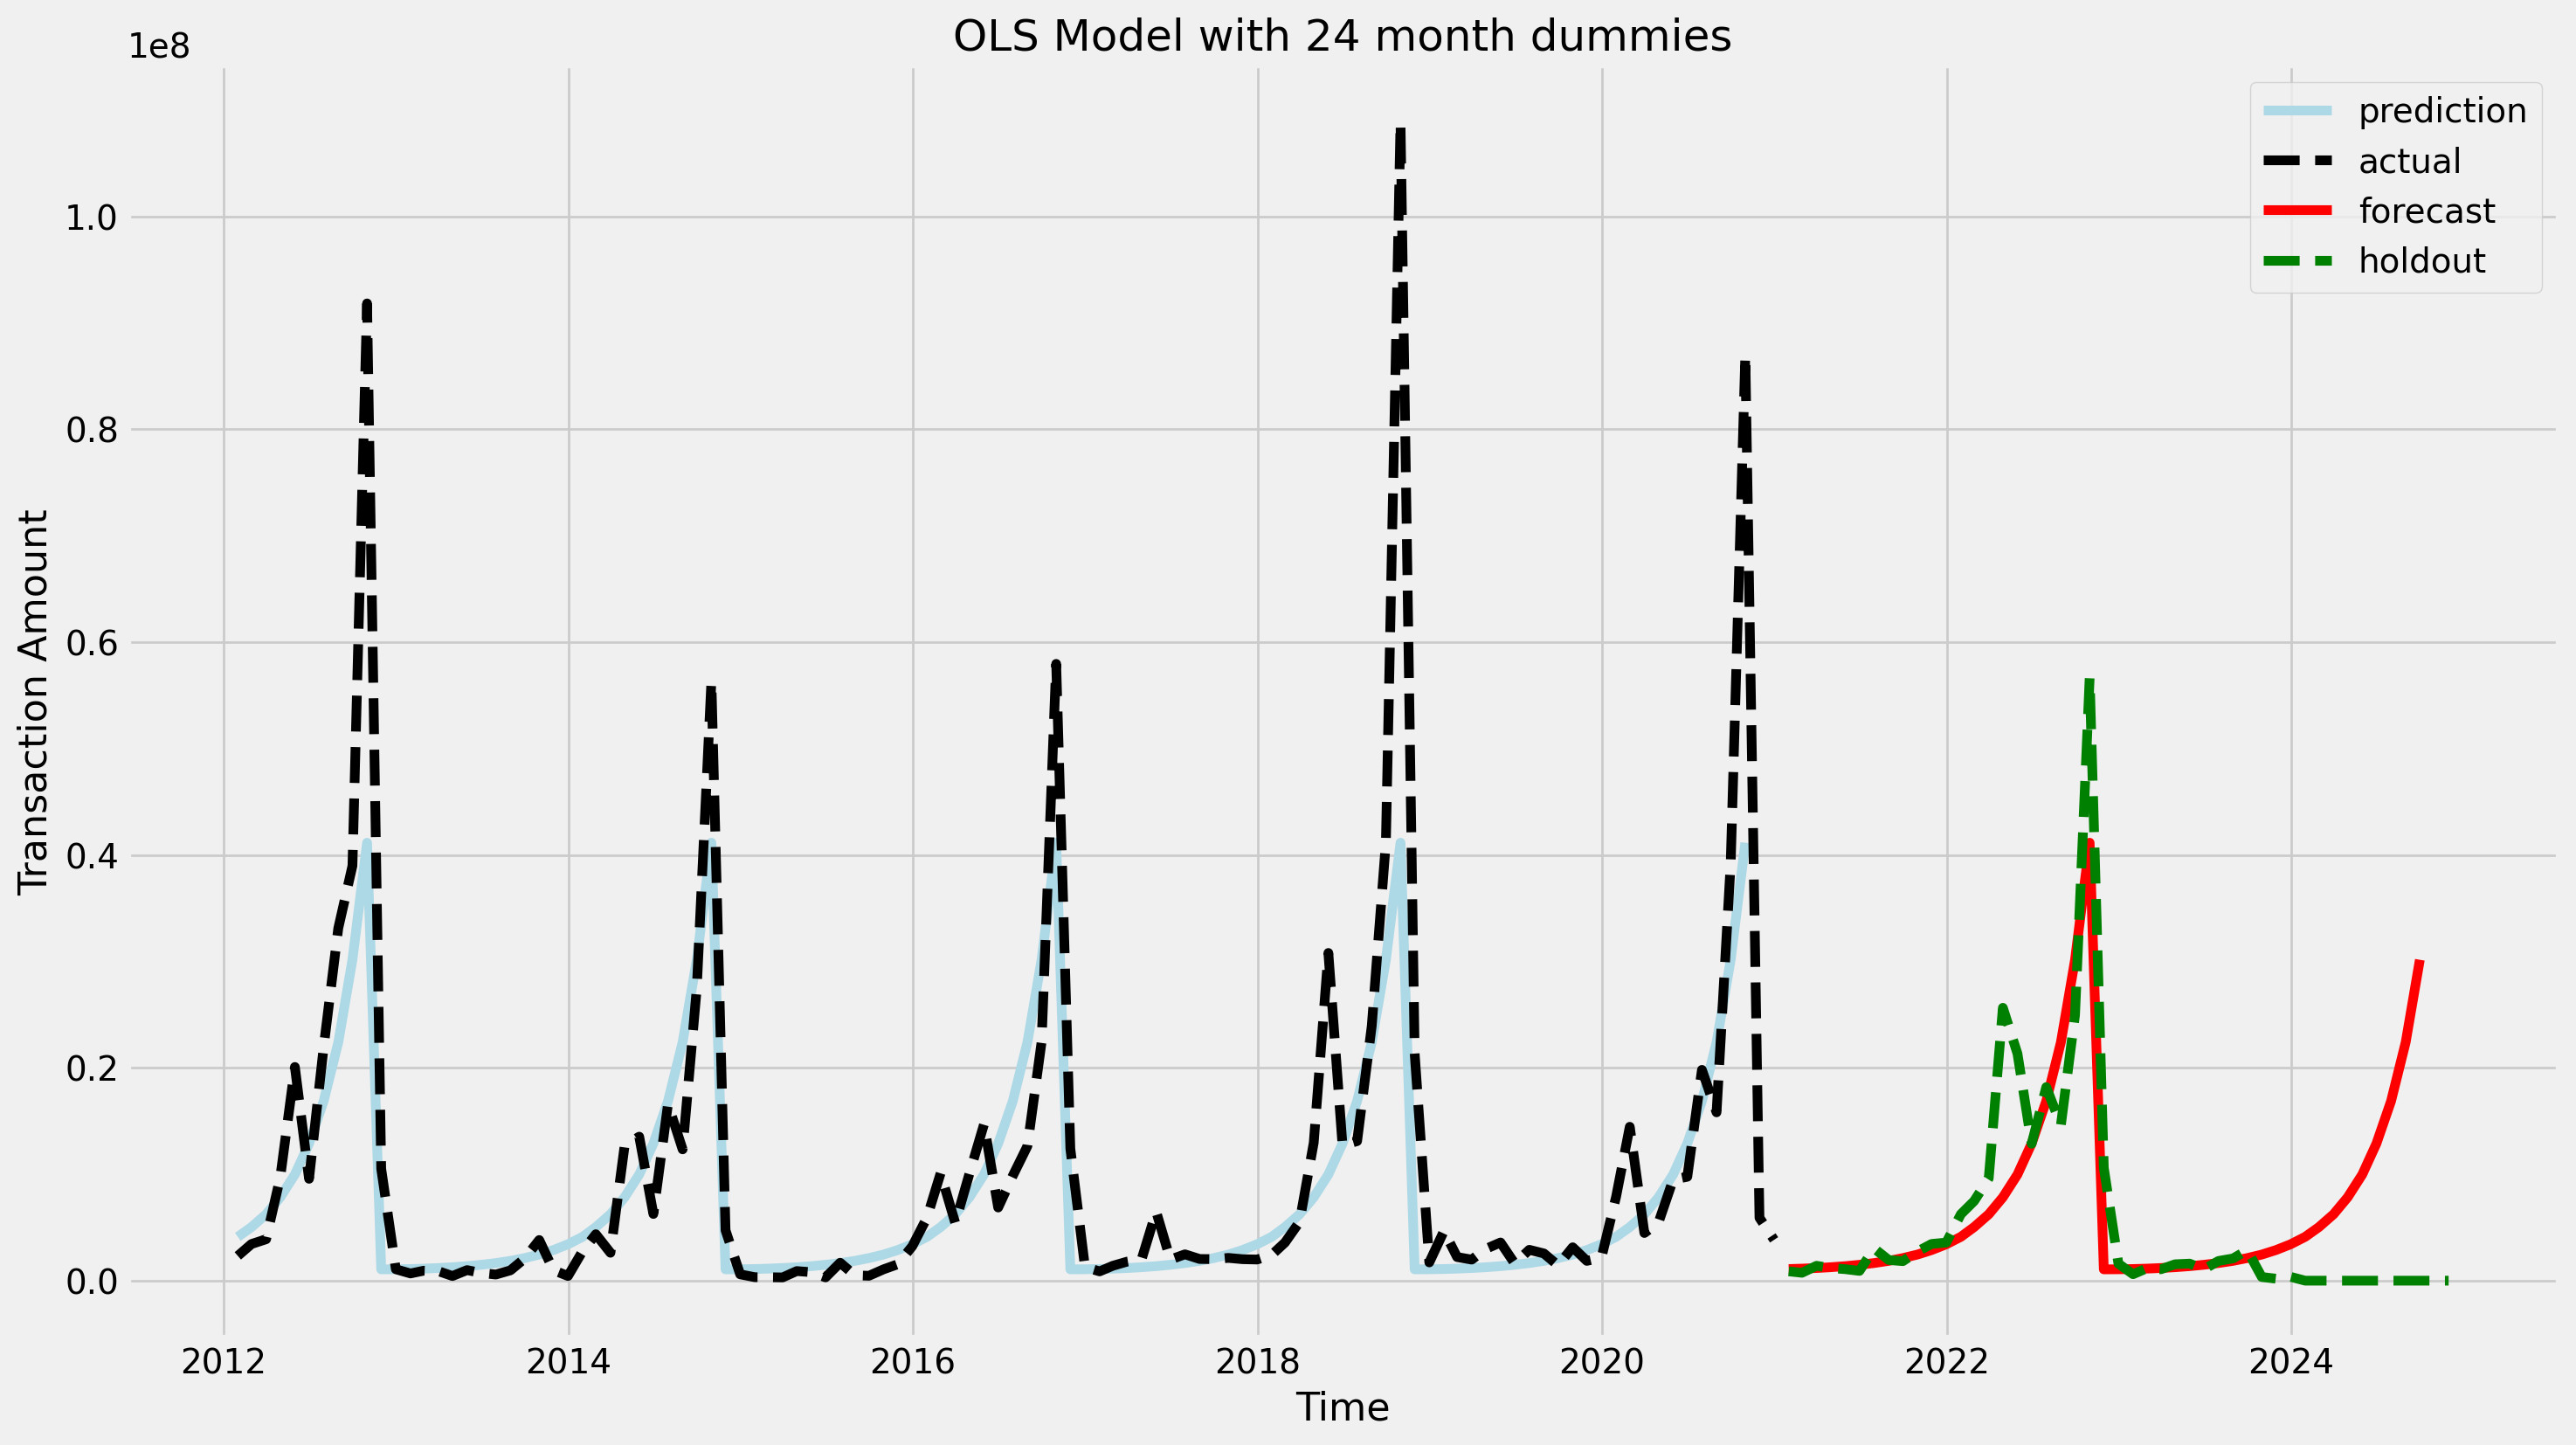

In [227]:
plt.figure(figsize=(16, 9))
plt.plot(np.exp(model_ols.predict(sm.add_constant(timeseries['Shifted Months'].shift(-2))**2)), color='lightblue', label='prediction')
plt.plot((timeseries['TRANSACTION_AMT']), color='k', label='actual', ls='--')
plt.plot(np.exp(model_ols.predict(sm.add_constant(holdout['Shifted Months'].shift(-2))**2)), color='red', label='forecast')
plt.plot(holdout['TRANSACTION_AMT'], color='green', label='holdout', ls='--')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Transaction Amount');
plt.title("OLS Model with 24 month dummies");

In [228]:
plt.plot(np.exp(model_ols.predict((timeseries[ms_2year_full])))-timeseries['TRANSACTION_AMT'], color='lightblue', label='prediction')

ValueError: shapes (108,24) and (2,) not aligned: 24 (dim 1) != 2 (dim 0)

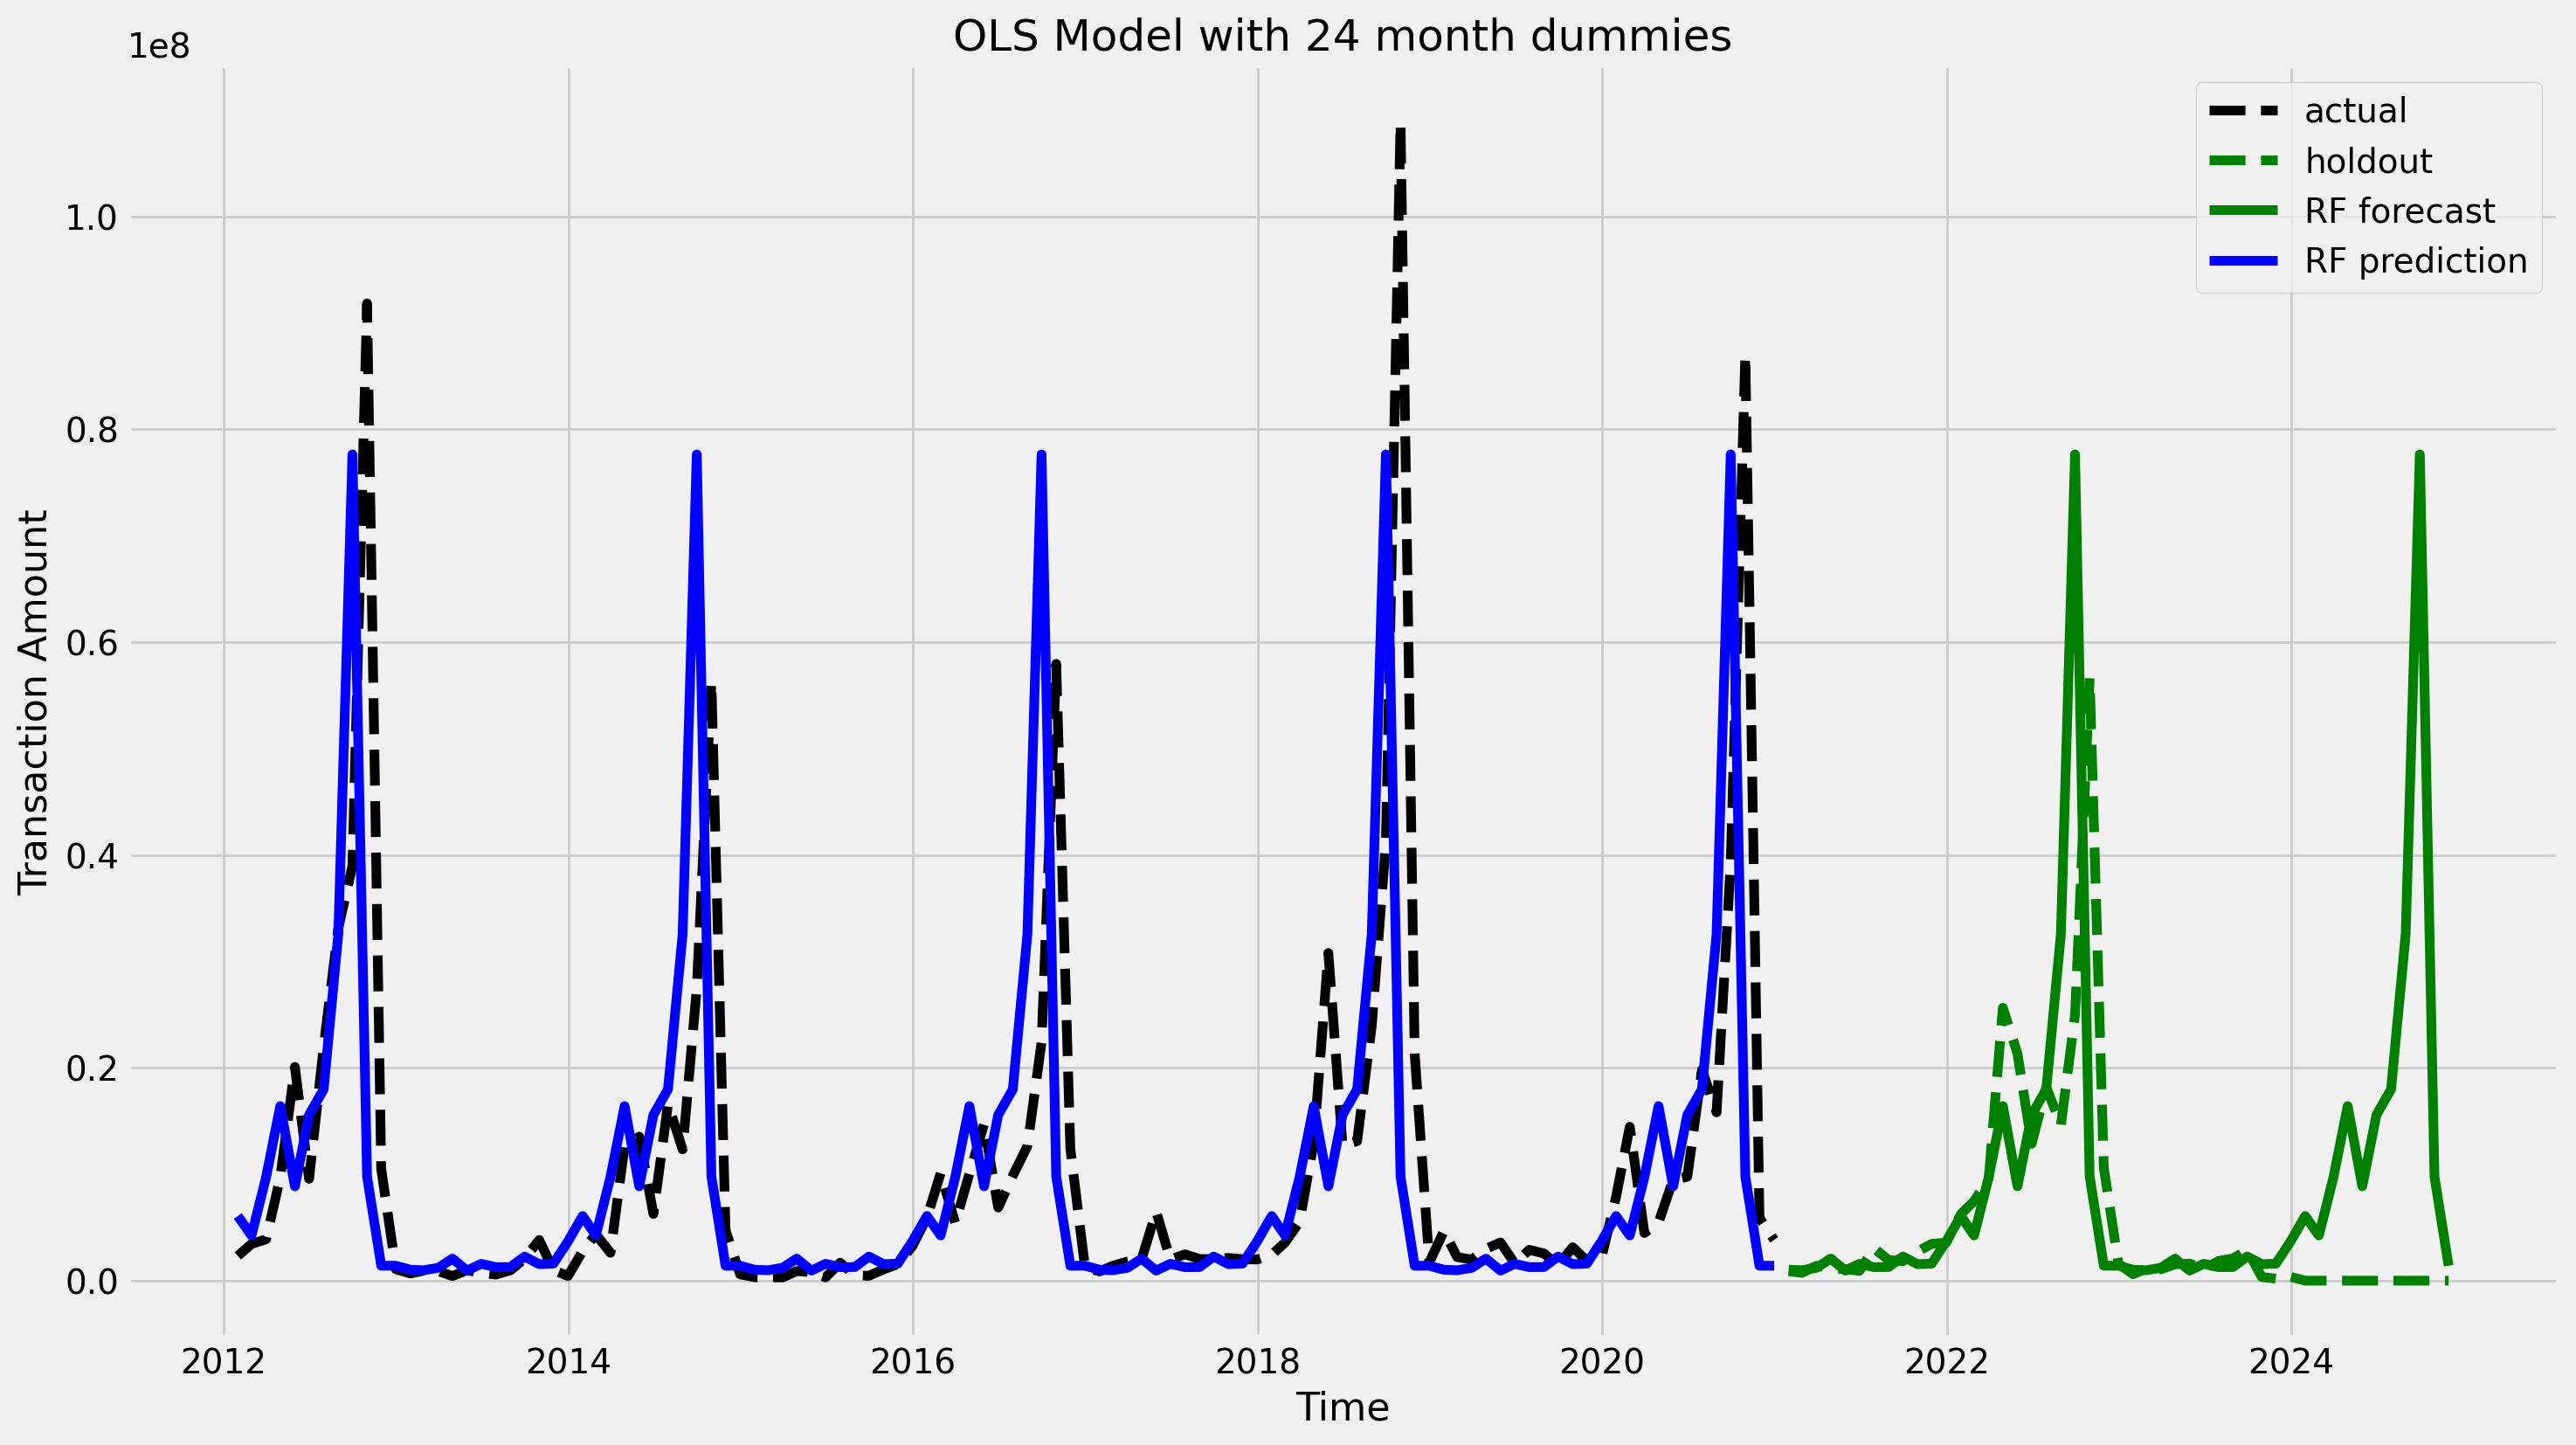

In [232]:
plt.figure(figsize=(16, 9))
#plt.plot(np.exp(model_ols.predict((timeseries[ms_2year_full]))), color='lightblue', label='prediction')
plt.plot((timeseries['TRANSACTION_AMT']), color='k', label='actual', ls='--')
#plt.plot(np.exp(model_ols.predict(holdout[ms_2year_full])), color='red', label='forecast')
plt.plot(holdout['TRANSACTION_AMT'], color='green', label='holdout', ls='--')
plt.plot(holdout.index, np.exp(rf.predict(holdout[["Shifted Months"]])), color='green', label='RF forecast')
plt.plot(timeseries.index, np.exp(rf.predict(timeseries[["Shifted Months"]])), color='blue', label='RF prediction')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Transaction Amount');
plt.title("OLS Model with 24 month dummies");


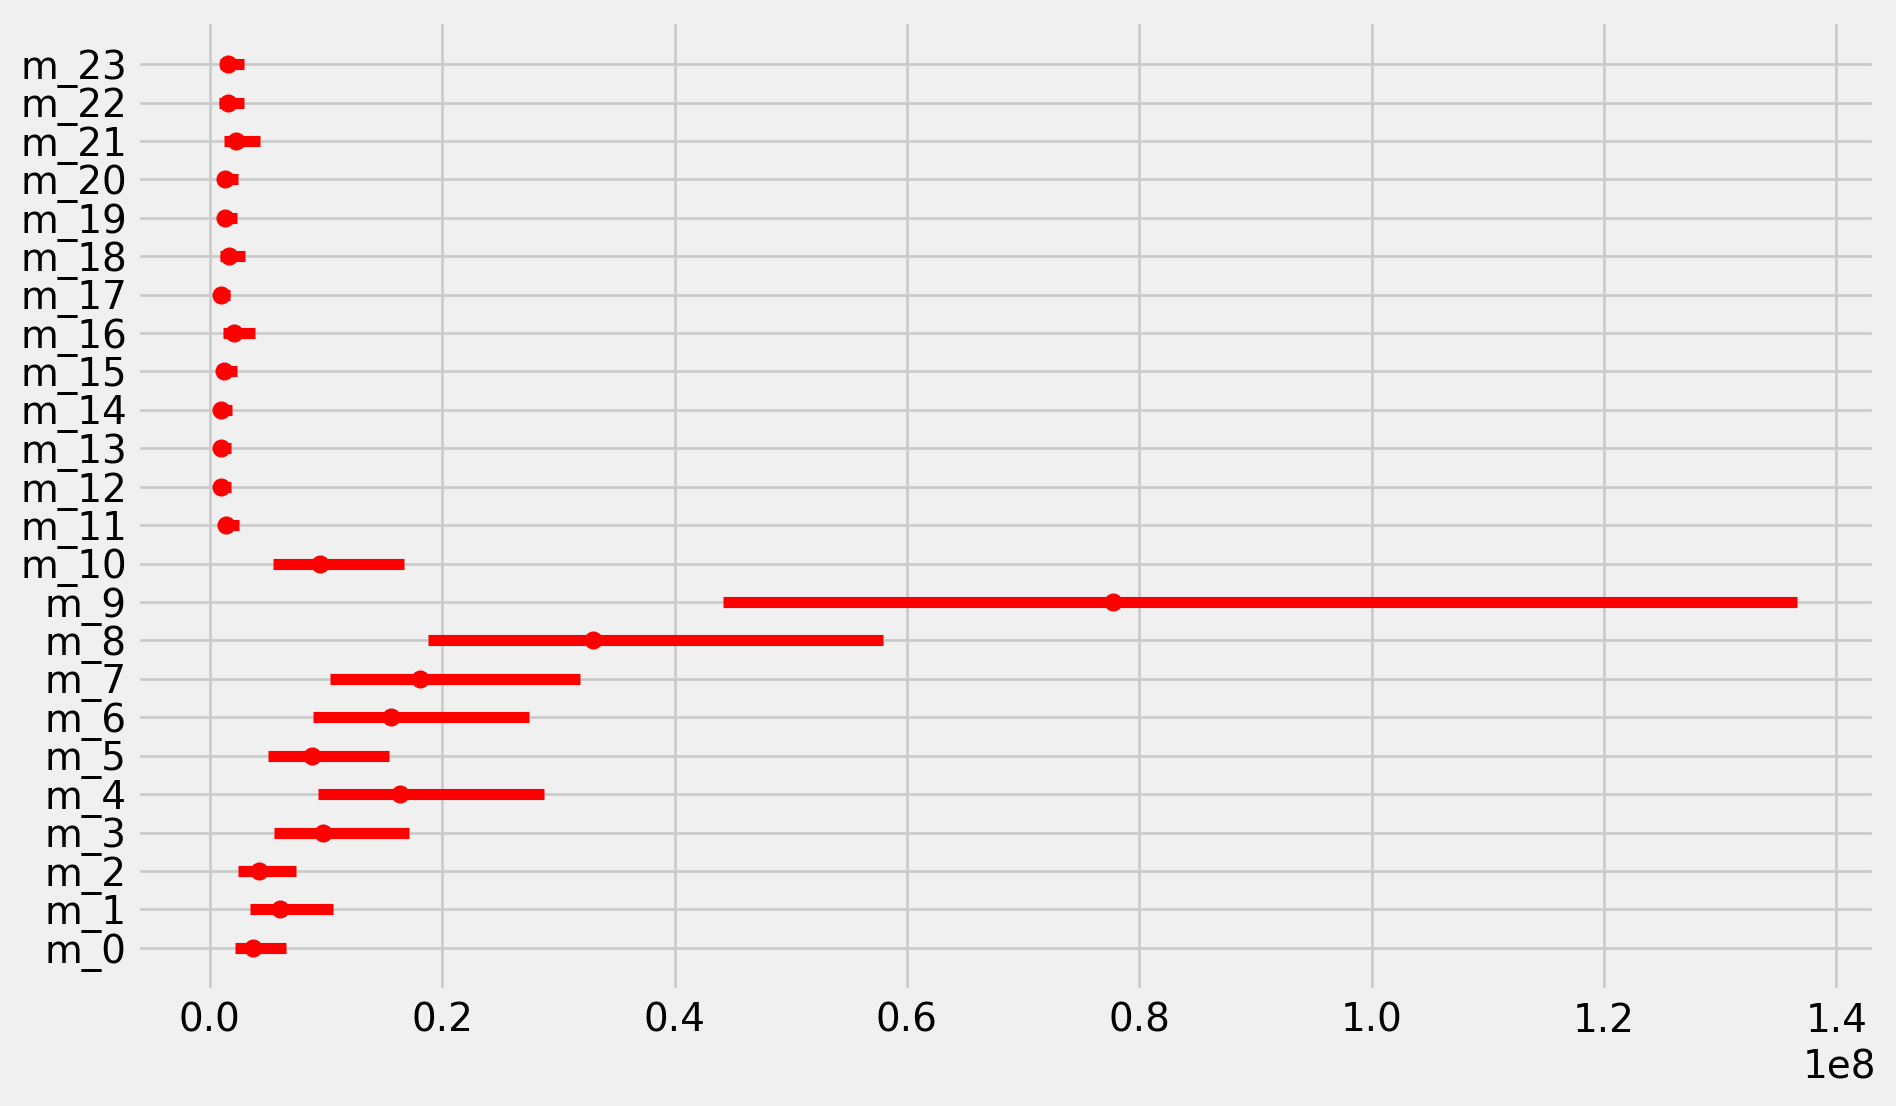

In [148]:
def plot_hdi(summary):
  const_mean = 1
  const_low = 1
  const_high = 1
  for i in range(1, len(summary.tables[1][:])):
    name = summary.tables[1][i][0].data
  
  
    mean_ = np.exp(float(summary.tables[1][i][1].data.strip()))
    low  = np.exp(float(summary.tables[1][i][5].data.strip()))
    high = np.exp(float(summary.tables[1][i][6].data.strip()))
    if name == 'const':
    
      const_mean = mean_
      const_low = low
      const_high = high
    if name != 'const':
      mean_ = mean_ * const_mean
      low = low * const_low
      high = high * const_high
  
    plt.hlines(name, low, high, color='r', label='95% CI')
    plt.scatter([mean_], [name], color='r')
plot_hdi(summary)

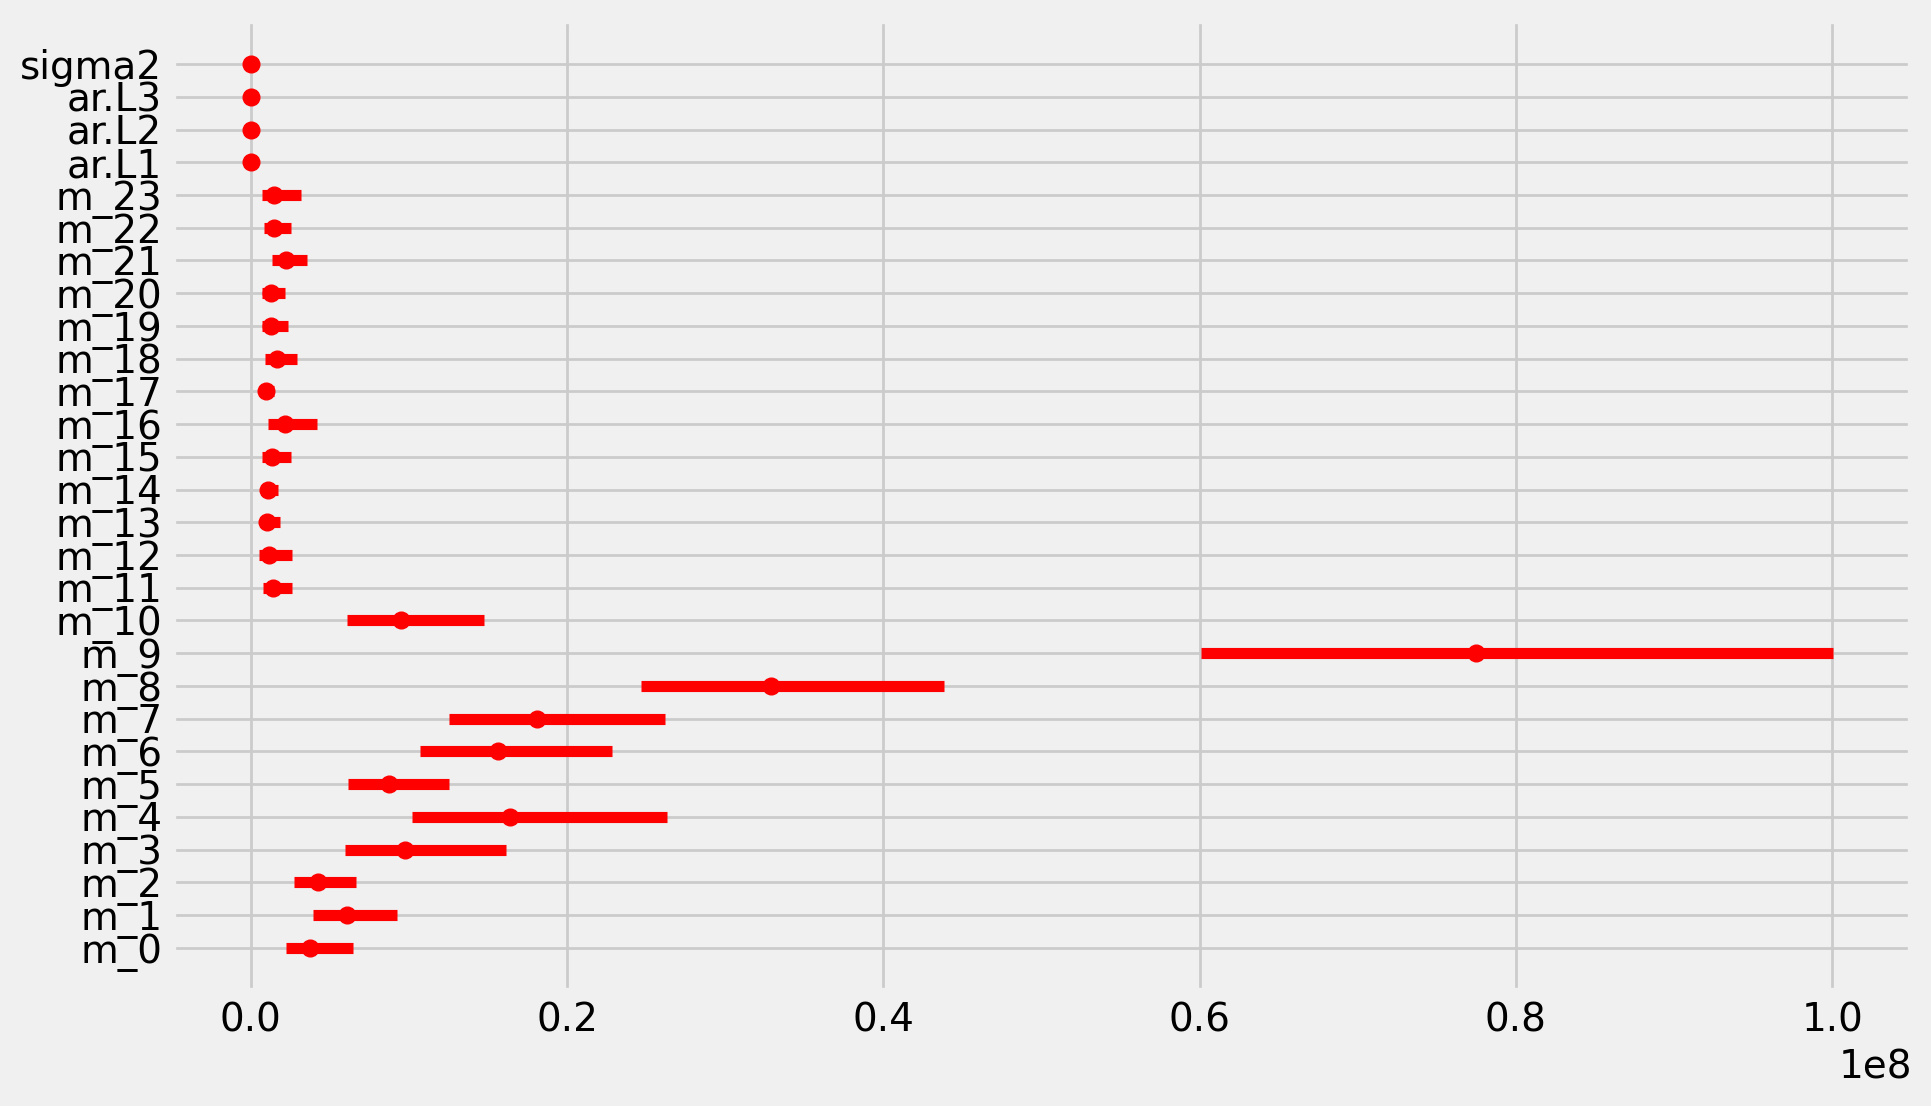

In [149]:
plot_hdi(model_2_summary)

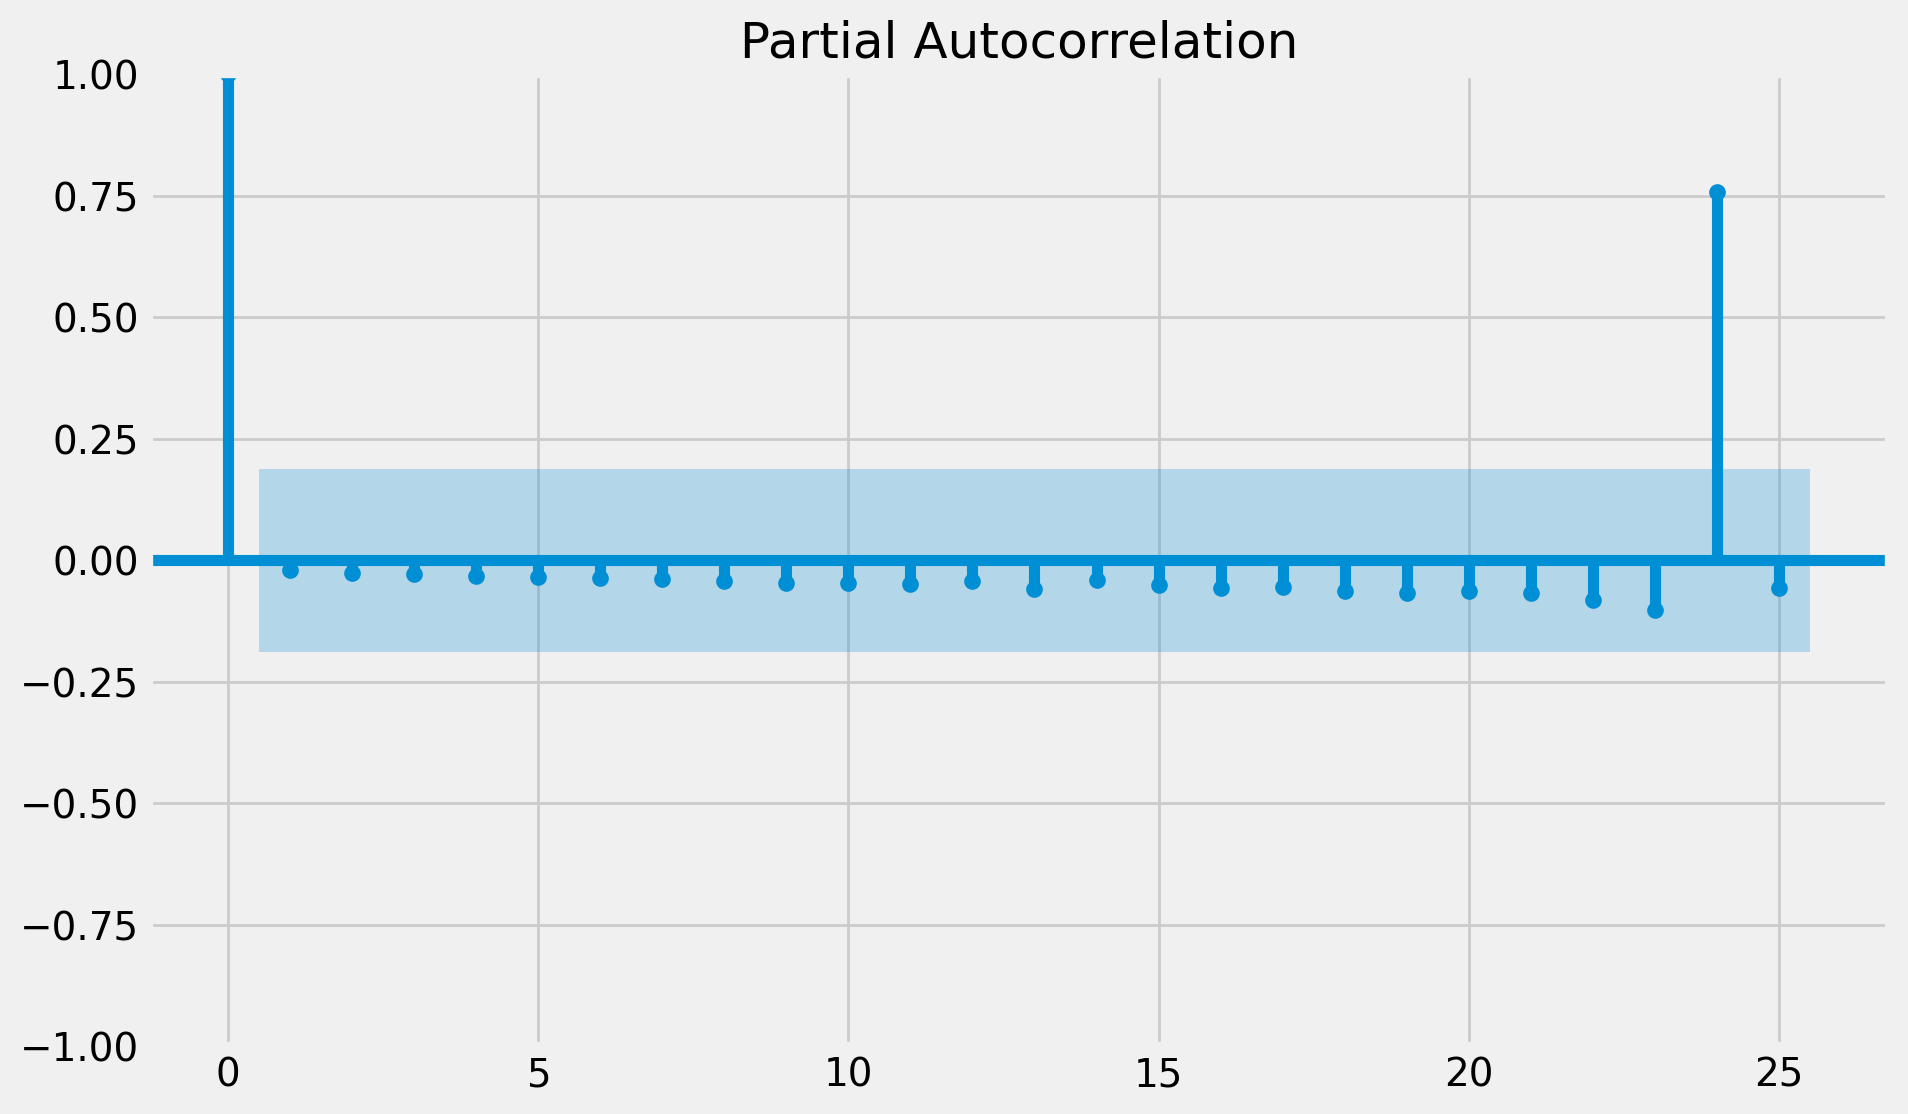

In [150]:
smt.graphics.plot_pacf((model_ols.predict(sm.add_constant(timeseries[ms_2year]))) - np.log(timeseries['TRANSACTION_AMT']), lags=25);